In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score
import numpy as np
from datetime import datetime
import lightgbm as lgb_orig
import warnings
warnings.simplefilter('ignore')
%matplotlib inline
#df2008 = pd.read_csv('data/keiba_PS2008.csv')
#df2009 = pd.read_csv('data/keiba_PS2009.csv')
#df2010 = pd.read_csv('data/keiba_PS2010.csv')
#df2011 = pd.read_csv('data/keiba_PS2011.csv')
#df2012 = pd.read_csv('data/keiba_PS2012.csv')
#df2013 = pd.read_csv('data/keiba_PS2013.csv')
#df2014 = pd.read_csv('data/keiba_PS2014.csv')
#df2015 = pd.read_csv('data/keiba_PS2015.csv')
#df2016 = pd.read_csv('data/keiba_PS2016.csv')
#df2017 = pd.read_csv('data/keiba_PS2017.csv')
#df2018 = pd.read_csv('data/keiba_PS2018.csv')
#df2019 = pd.read_csv('data/keiba_PS2019.csv')
#df2020 = pd.read_csv('data/keiba_PS2020.csv')
#df2021 = pd.read_csv('data/keiba_PS2021.csv')
#df = pd.concat([df2008, df2009, df2010, df2011, df2012, df2013, df2014, df2015, df2016, df2017, df2018, df2019, df2020, df2021])
#df.reset_index(drop=True, inplace=True)
#df = pd.concat([df2008, df2009, df2010, df2011])
df = pd.read_csv('data/preprocessed_all.csv')

In [84]:
#delete_index = df.index[(df["course"]=='障') | (df["rank"]=="中止") | (df["rank"]=='取消') | (df["rank"]=="失格") | (df['rank']=='除外') | pd.isna(df['rank'])]
#df.drop(delete_index, inplace=True)

In [85]:
def todatetime(x):
    year = int(x.split(',')[0])
    month = int(x.split(',')[1].split('/')[0])
    day = int(x.split(',')[1].split('/')[1].split('(')[0])
    return datetime(year, month, day)

def delete_lastword(x):
    if pd.isna(x):
        return float('nan')
    
    return int(x[:-1])

def delete_kg(x):
    if pd.isna(x):
        return float('nan')
    
    return int(x.split('k')[0])

def toint(x):
    if pd.isna(x):
        return float('nan')
    try:
        return int(x)
    except:
        return float('nan')

def arrange_jackie(x):
    if pd.isna(x):
        return float('nan')
    x = x.replace('\u3000', '')
    for special in ['☆', '▲', '△', '★', '◇']:
        if special in x:
            return x[1:]
    return x

def goaltime_convert(x):
    if pd.isna(x):
        return x
    try:
        minuite = int(x.split(':')[0])
    except:
        minuite = 0
    sec = float(x.split(':')[1])
    return 60 * minuite + sec

def trainerB_arrange(x):
    if pd.isna(x):
        return float('nan')
    x = x.replace('\u3000', '')
    return x

In [86]:
df['date'] = df['year'].astype(int).astype(str) + ',' + df['date']
df['date'] = df['date'].map(todatetime)
df['head_count'] = df['head_count'].map(delete_lastword)
df['distance'] = df['distance'].map(delete_lastword)
df['race'] = df['race'].map(delete_lastword)
df['weight'] = df['weight'].map(delete_kg)
df['rank'] = df['rank'].map(toint)
df['goal_time'] = df['goal_time'].map(goaltime_convert)
df["odds_popu"] = df["odds"] * df["popu"]
df["pre_weight"] = df["weight"] - df["c_weight"]
df['jackie'] = df['jackie'].map(arrange_jackie)
df['trainerB'] = df['trainerB'].map(trainerB_arrange)

In [87]:
df

,Unnamed: 0,year,date,field,race,race_name,course,head_count,rank,horse_name,gender,age,trainerA,trainerB,weight,c_weight,jackie,j_weight,odds,popu,race_num,distance,time,cond,turn,goal_time,weather,wakuban,umaban,got_money,odds_popu,pre_weight
0,0,2008,2008-08-16,札幌,1,2歳未勝利,芝,14,1.0,ディアジーナ,牝,2.0,美浦,田村,468.0,0.0,四位,54.0,4.3,2.0,200801010101,1500,10:40,良,右,89.3,曇,4.0,6.0,500.0,8.6,468.0
1,1,2008,2008-08-16,札幌,1,2歳未勝利,芝,14,2.0,アイディンパワー,牡,2.0,栗東,本田,460.0,0.0,藤田,54.0,5.2,4.0,200801010101,1500,10:40,良,右,91.0,曇,8.0,14.0,200.0,20.8,460.0
2,2,2008,2008-08-16,札幌,1,2歳未勝利,芝,14,3.0,ウインリーズン,牡,2.0,美浦,加藤征,442.0,2.0,安藤勝,54.0,3.1,1.0,200801010101,1500,10:40,良,右,91.4,曇,1.0,1.0,130.0,3.1,440.0
3,3,2008,2008-08-16,札幌,1,2歳未勝利,芝,14,4.0,ヴァンエボン,牡,2.0,栗東,山内,482.0,-4.0,小林徹,54.0,23.0,8.0,200801010101,1500,10:40,良,右,91.5,曇,7.0,11.0,75.0,184.0,486.0
4,4,2008,2008-08-16,札幌,1,2歳未勝利,芝,14,5.0,ラヴェリータ,牝,2.0,栗東,松元,484.0,-20.0,長谷川,54.0,21.9,6.0,200801010101,1500,10:40,良,右,91.6,曇,2.0,2.0,50.0,131.4,504.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
675129,675129,2021,2021-09-05,小倉,8,3歳以上1勝クラス,ダ,13,9.0,アスクドンキバック,牡,3.0,栗東,梅田,460.0,2.0,角田,52.0,71.0,12.0,202110040808,1000,13:55,稍,右,59.5,曇,6.0,9.0,0.0,852.0,458.0
675130,675130,2021,2021-09-05,小倉,8,3歳以上1勝クラス,ダ,13,10.0,フェブキラナ,牡,3.0,栗東,川村,462.0,-2.0,幸,55.0,11.8,5.0,202110040808,1000,13:55,稍,右,60.0,曇,5.0,6.0,0.0,59.0,464.0
675131,675131,2021,2021-09-05,小倉,8,3歳以上1勝クラス,ダ,13,11.0,スパークリングアイ,牡,3.0,栗東,大根田,488.0,-6.0,秋山真,55.0,63.6,11.0,202110040808,1000,13:55,稍,右,60.2,曇,3.0,3.0,0.0,699.6,494.0
675132,675132,2021,2021-09-05,小倉,8,3歳以上1勝クラス,ダ,13,12.0,ラストバリオン,牡,3.0,栗東,牧浦,492.0,0.0,永島,51.0,53.5,9.0,202110040808,1000,13:55,稍,右,60.3,曇,4.0,4.0,0.0,481.5,492.0


In [88]:
df.drop(columns=['Unnamed: 0', 'year', 'time', 'race'], inplace=True)
df = df.sort_values(['date', 'race_num'])
df.reset_index(drop=True, inplace=True)
df

,date,field,race_name,course,head_count,rank,horse_name,gender,age,trainerA,trainerB,weight,c_weight,jackie,j_weight,odds,popu,race_num,distance,cond,turn,goal_time,weather,wakuban,umaban,got_money,odds_popu,pre_weight
0,2008-01-05,中山,3歳未勝利,ダ,16,1.0,メジロアリエル,牝,3.0,美浦,大久洋,450.0,-10.0,吉田豊,54.0,8.1,4.0,200806010101,1200,良,右,69.1,曇,1.0,2.0,500.0,32.4,460.0
1,2008-01-05,中山,3歳未勝利,ダ,16,2.0,ヒロアンジェロ,牝,3.0,美浦,高木,482.0,2.0,蛯名,54.0,13.4,6.0,200806010101,1200,良,右,73.9,曇,3.0,5.0,200.0,80.4,480.0
2,2008-01-05,中山,3歳未勝利,ダ,16,3.0,キャスタスペルミー,牝,3.0,美浦,戸田,458.0,4.0,田中勝,54.0,8.2,5.0,200806010101,1200,良,右,73.9,曇,2.0,3.0,130.0,41.0,454.0
3,2008-01-05,中山,3歳未勝利,ダ,16,4.0,デルマベガ,牝,3.0,美浦,堀井,456.0,-2.0,吉田隼,54.0,2.9,1.0,200806010101,1200,良,右,74.2,曇,4.0,7.0,75.0,2.9,458.0
4,2008-01-05,中山,3歳未勝利,ダ,16,5.0,メジロフローラ,牝,3.0,美浦,柴田人,458.0,-10.0,石橋脩,54.0,4.3,2.0,200806010101,1200,良,右,74.3,曇,6.0,12.0,50.0,8.6,468.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
675129,2021-12-28,阪神,ファイナルS,芝,16,12.0,ショウナンバニラ,牝,5.0,美浦,武市,446.0,-2.0,坂井,53.0,9.6,5.0,202109060912,1200,良,右,68.8,晴,6.0,11.0,0.0,48.0,448.0
675130,2021-12-28,阪神,ファイナルS,芝,16,13.0,クルークヴァール,牡,6.0,栗東,浅見,478.0,12.0,鮫島駿,54.0,49.6,14.0,202109060912,1200,良,右,68.9,晴,4.0,7.0,0.0,694.4,466.0
675131,2021-12-28,阪神,ファイナルS,芝,16,14.0,キーダイヤ,牝,4.0,栗東,藤岡,452.0,2.0,斎藤,52.0,26.9,10.0,202109060912,1200,良,右,69.0,晴,3.0,5.0,0.0,269.0,450.0
675132,2021-12-28,阪神,ファイナルS,芝,16,15.0,ショウナンアリアナ,牝,5.0,栗東,高野,448.0,2.0,中井,54.0,41.1,12.0,202109060912,1200,良,右,69.0,晴,6.0,12.0,0.0,493.2,446.0


In [ ]:
total = len(df['horse_name'].unique())
for i, hn in enumerate(df['horse_name'].unique()):
    print(f'{i} / {total}', end='\r')
    sum_prize = 0
    pre_avg_speed = float('nan')
    pre2_avg_speed = float('nan')
    pre3_avg_speed = float('nan')
    pre4_avg_speed = float('nan')
    pre5_avg_speed = float('nan')
    last_day = 0
    pre_rank = float('nan')
    pre2_rank = float('nan')
    pre3_rank = float('nan')
    pre4_rank = float('nan')
    pre5_rank = float('nan')
    rentai = 0
    count = 0
    for idx in df[df['horse_name'] == hn].index:
        count += 1
        df.loc[idx, 'sum_prize'] = sum_prize
        df.loc[idx, 'pre_speed'] = pre_avg_speed
        df.loc[idx, 'pre2_speed'] = pre2_avg_speed
        df.loc[idx, 'pre3_speed'] = pre3_avg_speed
        df.loc[idx, 'pre4_speed'] = pre4_avg_speed
        df.loc[idx, 'pre5_speed'] = pre5_avg_speed
        df.loc[idx, 'from_last_day'] = (df.loc[idx, 'date'] - last_day).days if last_day != 0 else float('nan')
        df.loc[idx, 'pre_rank'] = pre_rank
        df.loc[idx, 'pre2_rank'] = pre2_rank
        df.loc[idx, 'pre3_rank'] = pre3_rank
        df.loc[idx, 'pre4_rank'] = pre4_rank
        df.loc[idx, 'pre5_rank'] = pre5_rank
        df.loc[idx, 'rentai'] = (rentai * (count - 1) + 1) / count if pre_rank < 3 else (rentai * (count - 1)) / count
        
        sum_prize = sum_prize + df.loc[idx, 'got_money'] if not pd.isna(df.loc[idx, 'got_money']) else sum_prize
        pre5_avg_speed = pre4_avg_speed
        pre4_avg_speed = pre3_avg_speed
        pre3_avg_speed = pre2_avg_speed
        pre2_avg_speed = pre_avg_speed
        pre_avg_speed = df.loc[idx, 'distance'] / (df.loc[idx, 'goal_time'] + 1e-8)
        last_day = df.loc[idx, 'date']
        pre5_rank = pre4_rank
        pre4_rank = pre3_rank
        pre3_rank = pre2_rank
        pre2_rank = pre_rank
        pre_rank = df.loc[idx, 'rank']
        rentai = df.loc[idx, 'rentai']

In [103]:
#df.to_csv('data/keiba_feature_preprocessed_all.csv')
df = pd.read_csv('data/keiba_feature_preprocessed_all.csv')

In [104]:
sinba = list(map(lambda x: ('新馬' in x) or ('未勝利' not in x) if not pd.isna(x) else True, df['race_name'].to_numpy()))
delete_index = df.index[(df["course"]=='障') | (df["rank"]=="中止") | (df["rank"]=='取消') | (df["rank"]=="失格") | (df['rank']=='除外') | pd.isna(df['rank'])]
df.drop(delete_index, inplace=True)
df.reset_index(drop=True, inplace=True)

In [105]:
le=LabelEncoder()
categorical = [
    'field', 
    'race_name', 
    'course', 
    'horse_name', 
    'gender', 
    'trainerA', 
    'trainerB', 
    'jackie', 
    'cond', 
    'turn', 
    'weather'
]
df[categorical] = df[categorical].fillna('nan')
keiba_categorical = df[categorical].apply(le.fit_transform).astype('category')
keiba_categorical = keiba_categorical.rename(columns={c: c+'_c' for c in categorical})
df = pd.concat([df, keiba_categorical],axis=1)
# 変換前と不要な列を削除
df.drop(columns=categorical,inplace=True)

In [41]:
#others_list = ['age', 'c_weight', 'j_weight',	'odds',	'popu',	'umaban',	'wakuban', 'weight', 'horse_name_c', 'trainerA_c',	'trainerB_c',	'jackie_c', 'odds_popu',	'pre_weight',	'sum_prize',	'pre_speed',	'pre2_speed',	'from_last_day']
#total = len(df['race_num'].unique())
#for i, race in enumerate(df['race_num'].unique()):
#    print(f'{i} / {total}')
#    idx = df[df['race_num'] == race].index
#    df_race = df.loc[idx, others_list]
#    horse_num = len(df_race)
#    new_index = sum([[element + f'{int(i)}' for element in others_list] for i in df_race['umaban']], [])
#    df_add = pd.DataFrame(df_race.to_numpy().flatten(), index=new_index)
#    df_add = pd.concat([df_add] * horse_num, axis=1).transpose()
#    df_add.set_index(df_race.index, inplace=True)
#    df.loc[idx, new_index] = df_add

In [42]:
#df.to_csv('data/preprocessed_others.csv')
df = pd.read_csv('data/preprocessed_others.csv')

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [106]:
#df = df.assign(target = ((df['rank'] >= 8).astype(int) + (df['rank'] >= 3).astype(int)))
df = df.assign(target = ((df['rank'] <= 3).astype(int)))
df

,Unnamed: 0,date,head_count,rank,age,weight,c_weight,j_weight,odds,popu,race_num,distance,goal_time,wakuban,umaban,got_money,odds_popu,pre_weight,sum_prize,pre_speed,pre2_speed,pre3_speed,pre4_speed,pre5_speed,from_last_day,pre_rank,pre2_rank,pre3_rank,pre4_rank,pre5_rank,rentai,field_c,race_name_c,course_c,horse_name_c,gender_c,trainerA_c,trainerB_c,jackie_c,cond_c,turn_c,weather_c,target
0,0,2008-01-05,16,1.0,3.0,450.0,-10.0,54.0,8.1,4.0,200806010101,1200,69.1,1.0,2.0,500.0,32.4,460.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1,16,0,61175,1,4,222,199,2,0,3,1
1,1,2008-01-05,16,2.0,3.0,482.0,2.0,54.0,13.4,6.0,200806010101,1200,73.9,3.0,5.0,200.0,80.4,480.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1,16,0,47211,1,4,757,559,2,0,3,1
2,2,2008-01-05,16,3.0,3.0,458.0,4.0,54.0,8.2,5.0,200806010101,1200,73.9,2.0,3.0,130.0,41.0,454.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1,16,0,13169,1,4,363,463,2,0,3,1
3,3,2008-01-05,16,4.0,3.0,456.0,-2.0,54.0,2.9,1.0,200806010101,1200,74.2,4.0,7.0,75.0,2.9,458.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1,16,0,38013,1,4,208,200,2,0,3,0
4,4,2008-01-05,16,5.0,3.0,458.0,-10.0,54.0,4.3,2.0,200806010101,1200,74.3,6.0,12.0,50.0,8.6,468.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1,16,0,61257,1,4,450,498,2,0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
648505,675129,2021-12-28,16,12.0,5.0,446.0,-2.0,53.0,9.6,5.0,202109060912,1200,68.8,6.0,11.0,0.0,48.0,448.0,5402.0,17.492711,17.777778,17.492711,16.371078,17.291066,178.0,5.0,1.0,3.0,2.0,8.0,0.214286,9,343,1,25104,1,4,496,219,2,0,2,0
648506,675130,2021-12-28,16,13.0,6.0,478.0,12.0,54.0,49.6,14.0,202109060912,1200,68.9,4.0,7.0,0.0,694.4,466.0,4906.0,17.761989,18.621974,17.069701,18.315018,17.241379,58.0,16.0,1.0,5.0,3.0,12.0,0.129032,9,343,1,15609,2,3,528,630,2,0,2,0
648507,675131,2021-12-28,16,14.0,4.0,452.0,2.0,52.0,26.9,10.0,202109060912,1200,69.0,3.0,5.0,0.0,269.0,450.0,3965.0,17.595308,17.953321,17.291066,17.777778,17.216643,23.0,14.0,6.0,11.0,1.0,13.0,0.352941,9,343,1,14096,1,3,673,338,2,0,2,0
648508,675132,2021-12-28,16,15.0,5.0,448.0,2.0,54.0,41.1,12.0,202109060912,1200,69.0,6.0,12.0,0.0,493.2,446.0,7995.0,17.341040,17.492711,16.835017,17.416546,17.518248,16.0,12.0,3.0,10.0,8.0,2.0,0.187500,9,343,1,24946,1,3,779,110,2,0,2,0


In [107]:
def pr_auc(pred, ans):
    
    pr_auc = average_precision_score(ans.get_label(), pred)
    return 'pr_auc', pr_auc, True

def mpr_auc(pred, ans):
    
    pr_auc = average_precision_score(ans.get_label(), pred)
    return 'pr_auc', -pr_auc, False

In [121]:
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit

leakage_list = ['Unnamed: 0', 'date', 'goal_time', 'got_money', 'rank', 'target', 'race_num']
odds_popu_list = ['odds', 'popu', 'odds_popu'] #+ [f'odds{i}' for i in range(1, 19)] + [f'popu{i}' for i in range(1, 19)] + [f'odds_popu{i}' for i in range(1, 19)]+ [f'horse_name_c{i}' for i in range(1, 19)] #
X = df.drop(leakage_list + odds_popu_list, axis=1)
y = df['target']

train_num = int(len(df) * 4/5)

while 1:
    if df.iloc[train_num-1]['race_num'] == df.iloc[train_num]['race_num']:
        train_num += 1
    else:
        break

val_num = int((len(df) - train_num)/2)

while 1:
    if df.iloc[train_num+val_num-1]['race_num'] == df.iloc[train_num+val_num]['race_num']:
        val_num += 1
    else:
        break

test_num = len(df) - train_num - val_num

weight = np.where(df['rank']<=3, 3, 1)#df['odds'].to_numpy()#np.where(df['rank']<=3, np.sqrt(df['odds'].to_numpy()), 1)

df_train, df_val, df_test = df.iloc[:train_num], df.iloc[train_num:train_num+val_num], df.iloc[-test_num:]

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)
X_train, X_val, X_test, y_train, y_val, y_test = X.iloc[:train_num], X.iloc[train_num:train_num+val_num], X.iloc[-test_num:], \
                                                                                  y.iloc[:train_num], y.iloc[train_num:train_num+val_num], y.iloc[-test_num:]
# データの変換
lgb_train = lgb.Dataset(X_train, y_train, weight=weight[:train_num])
lgb_eval = lgb.Dataset(X_val, y_val, weight=weight[train_num:train_num+val_num])
X_train

,head_count,age,weight,c_weight,j_weight,distance,wakuban,umaban,pre_weight,sum_prize,pre_speed,pre2_speed,pre3_speed,pre4_speed,pre5_speed,from_last_day,pre_rank,pre2_rank,pre3_rank,pre4_rank,pre5_rank,rentai,field_c,race_name_c,course_c,horse_name_c,gender_c,trainerA_c,trainerB_c,jackie_c,cond_c,turn_c,weather_c
0,16,3.0,450.0,-10.0,54.0,1200,1.0,2.0,460.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1,16,0,61175,1,4,222,199,2,0,3
1,16,3.0,482.0,2.0,54.0,1200,3.0,5.0,480.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1,16,0,47211,1,4,757,559,2,0,3
2,16,3.0,458.0,4.0,54.0,1200,2.0,3.0,454.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1,16,0,13169,1,4,363,463,2,0,3
3,16,3.0,456.0,-2.0,54.0,1200,4.0,7.0,458.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1,16,0,38013,1,4,208,200,2,0,3
4,16,3.0,458.0,-10.0,54.0,1200,6.0,12.0,468.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1,16,0,61257,1,4,450,498,2,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
518807,12,5.0,450.0,0.0,55.0,1400,8.0,12.0,450.0,1555.0,16.489988,17.434620,15.977444,15.638575,16.222480,28.0,5.0,1.0,4.0,6.0,10.0,0.058824,0,545,0,22169,1,3,700,110,1,1,3
518808,12,6.0,474.0,4.0,55.0,1400,8.0,11.0,470.0,3085.0,15.740741,16.412661,16.627078,15.962441,16.715831,189.0,12.0,7.0,14.0,8.0,1.0,0.148148,0,545,0,1103,1,3,643,403,1,1,3
518809,12,6.0,478.0,2.0,57.0,1400,6.0,7.0,476.0,4095.0,16.506190,16.203704,16.574586,17.135863,15.813953,14.0,14.0,16.0,10.0,12.0,9.0,0.142857,0,545,0,11476,2,4,120,123,1,1,3
518810,12,4.0,496.0,4.0,57.0,1400,6.0,8.0,492.0,1065.0,17.177914,15.693112,15.945330,NaN,NaN,91.0,1.0,5.0,2.0,NaN,NaN,0.500000,0,545,0,39738,2,4,571,630,1,1,3


In [122]:
params = {
    'objective': 'binary',
    'metric': 'auc'
    #'metric': 'binary_logloss'
    #'metric': 'pr_auc',
    #"metric" : "recovery"
}

multi_params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'multiclassova',
        'num_class': 3,
        'metric': 'multi_error',
}

best_params, history = {}, []
#from optuna.integration import lightgbm as lgb
#model = lgb.train(params, lgb_train, valid_sets=[lgb_train, lgb_eval],
#                    #verbose_eval=False,
#                    num_boost_round=500,
#                    early_stopping_rounds=30,
#                    feval=mpr_auc,
#                    #feval=mrecovery,
#                    )
best_params_ = params #model.params #

# モデルの作成

model = lgb_orig.train(best_params_, 
                       lgb_train,
                       valid_sets=lgb_eval,
                       num_boost_round=500,
                       early_stopping_rounds=30,
                       #feval=pr_auc,
                       #feval=recovery,
                      )

[LightGBM] [Info] Number of positive: 108319, number of negative: 410493
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032118 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 30970
[LightGBM] [Info] Number of data points in the train set: 518812, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.441848 -> initscore=-0.233666
[LightGBM] [Info] Start training from score -0.233666
[1]	valid_0's auc: 0.717614
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.725862
[3]	valid_0's auc: 0.727052
[4]	valid_0's auc: 0.729625
[5]	valid_0's auc: 0.730654
[6]	valid_0's auc: 0.732029
[7]	valid_0's auc: 0.733116
[8]	valid_0's auc: 0.733819
[9]	valid_0's auc: 0.735547
[10]	valid_0's auc: 0.736095
[11]	valid_0's auc: 0.73727
[12]	valid_0's auc: 0.737678
[13]	valid_0's auc: 0.7387
[14]	valid_0's auc: 0.739026
[15]	valid_0's auc: 0.739752
[16]	valid_0's 

In [110]:
score = model.predict(X_train, num_iteration=model.best_iteration)
if len(score.shape) > 1:
    score = score[:, 0]
df_calc = df_train
win = (df_calc['rank']==1).to_numpy()

In [111]:
#score_thresh_list, flag_list = [], []
#alls = len(df_calc['race_num'].unique())
#for i, race_num in enumerate(df_calc['race_num'].unique()):
#    print(f'{i} / {alls}', end='\r')
#    max_score = np.sort(score[(df_calc['race_num'] == race_num)])[-1] #score[(df_test['race_num'] == race_num)].max() #
#    second_score = np.sort(score[(df_calc['race_num'] == race_num)])[-2]
#    if max_score - second_score > 0.3:
#        flag = True
#    else:
#        flag = False
#    if pd.isna(df_calc[(df_calc['race_num'] == race_num)]['pre2_speed']).sum() > len(df_calc[(df_calc['race_num'] == race_num)]) / 2:
#        flag = False
#    flag_list.extend([flag] * sum((df_calc['race_num'] == race_num)))
#    score_thresh_list.extend([max_score] * sum((df_calc['race_num'] == race_num)))
#flag_list = np.array(flag_list)
#score_thresh_list = np.array(score_thresh_list)
#
thresh = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

for th in thresh:
    buy_bool = (score >= th) & (df_calc['odds'] > 3)#& flag_list & (score >= score_thresh_list)
    cost = buy_bool.sum() + 1e-8
    get = (df_calc[buy_bool & win]['odds']).sum()
    recovery = get / cost * 100
    acc = (buy_bool & win).sum() / (buy_bool.sum() + 1e-8)
    hit = (buy_bool & win).sum()
    buy = buy_bool.sum()
    print(f'thresh = {th}, recovery = {recovery}, hit = {hit}, buy = {buy}, acc = {acc}')

thresh = 0.0, recovery = 72.07519121148933, hit = 26196, buy = 491733, acc = 0.05327281268493159
thresh = 0.1, recovery = 77.47874731775556, hit = 26153, buy = 450649, acc = 0.05803407973833165
thresh = 0.2, recovery = 87.19459039968157, hit = 25599, buy = 359509, acc = 0.07120544965494408
thresh = 0.3, recovery = 94.56324054220816, hit = 24217, buy = 276571, acc = 0.08756160262644719
thresh = 0.4, recovery = 101.92726947819367, hit = 21745, buy = 201456, acc = 0.10793920260502998
thresh = 0.5, recovery = 108.16552894671389, hit = 17927, buy = 134333, acc = 0.13345194404947902
thresh = 0.6, recovery = 112.1993145129494, hit = 12603, buy = 76442, acc = 0.16487009759030835
thresh = 0.7, recovery = 120.75489636809256, hit = 6612, buy = 31554, acc = 0.2095455409773057
thresh = 0.8, recovery = 146.74916943497215, hit = 1723, buy = 6020, acc = 0.2862126245842422
thresh = 0.9, recovery = 188.287292807277, hit = 62, buy = 181, acc = 0.34254143644516344


In [112]:
score = model.predict(X_val, num_iteration=model.best_iteration)
if len(score.shape) > 1:
    score = score[:, 0]
df_calc = df_val
win = (df_calc['rank']==1).to_numpy()

In [113]:
score_thresh_list, flag_list = [], []
alls = len(df_calc['race_num'].unique())
for i, race_num in enumerate(df_calc['race_num'].unique()):
    print(f'{i} / {alls}', end='\r')
    max_score = np.sort(score[(df_calc['race_num'] == race_num)])[-1] #score[(df_test['race_num'] == race_num)].max() #
    second_score = np.sort(score[(df_calc['race_num'] == race_num)])[-2]
    if max_score - second_score > 0.3:
        flag = True
    else:
        flag = False
    if pd.isna(df_calc[(df_calc['race_num'] == race_num)]['pre2_speed']).sum() > len(df_calc[(df_calc['race_num'] == race_num)]) / 2:
        flag = False
    flag_list.extend([flag] * sum((df_calc['race_num'] == race_num)))
    score_thresh_list.extend([max_score] * sum((df_calc['race_num'] == race_num)))
flag_list = np.array(flag_list)
score_thresh_list = np.array(score_thresh_list)

thresh = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

for th in thresh:
    buy_bool = (score >= th)  & (df_calc['odds'] > 3)#& flag_list & (score >= score_thresh_list) 
    cost = buy_bool.sum() + 1e-8
    get = (df_calc[buy_bool & win]['odds']).sum()
    recovery = get / cost * 100
    acc = (buy_bool & win).sum() / (buy_bool.sum() + 1e-8)
    hit = (buy_bool & win).sum()
    buy = buy_bool.sum()
    print(f'thresh = {th}, recovery = {recovery}, hit = {hit}, buy = {buy}, acc = {acc}')

thresh = 0.0, recovery = 74.25301814972731, hit = 3372, buy = 61213, acc = 0.05508633786939783
thresh = 0.1, recovery = 76.52024565419721, hit = 3358, buy = 57642, acc = 0.05825613268102109
thresh = 0.2, recovery = 79.86556228096424, hit = 3221, buy = 47085, acc = 0.06840819793988141
thresh = 0.3, recovery = 81.00028003358136, hit = 2910, buy = 35710, acc = 0.08148977877343
thresh = 0.4, recovery = 79.20555156732902, hit = 2430, buy = 25074, acc = 0.09691313711410349
thresh = 0.5, recovery = 77.41059104023252, hit = 1827, buy = 15938, acc = 0.11463169782901579
thresh = 0.6, recovery = 75.02760441661663, hit = 1089, buy = 8332, acc = 0.13070091214578647
thresh = 0.7, recovery = 75.69183464272056, hit = 438, buy = 2927, acc = 0.14964127092535143
thresh = 0.8, recovery = 83.73040752088619, hit = 57, buy = 319, acc = 0.17868338557433594
thresh = 0.9, recovery = 0.0, hit = 0, buy = 1, acc = 0.0


In [100]:
score = model.predict(X_test, num_iteration=model.best_iteration)
if len(score.shape) > 1:
    score = score[:, 0]
df_calc = df_test
win = (df_calc['rank']==1).to_numpy()
easy_dif = ed_model.predict(X_test, num_iteration=ed_model.best_iteration)

In [102]:
score_thresh_list, flag_list = [], []
alls = len(df_calc['race_num'].unique())
for i, race_num in enumerate(df_calc['race_num'].unique()):
    print(f'{i} / {alls}', end='\r')
    max_score = np.sort(score[(df_calc['race_num'] == race_num)])[-1] #score[(df_test['race_num'] == race_num)].max() #
    second_score = np.sort(score[(df_calc['race_num'] == race_num)])[-2]
    if max_score - second_score > 0.3:
        flag = True
    else:
        flag = False
    if pd.isna(df_calc[(df_calc['race_num'] == race_num)]['pre2_speed']).sum() > len(df_calc[(df_calc['race_num'] == race_num)]) / 2:
        flag = False
    flag_list.extend([flag] * sum((df_calc['race_num'] == race_num)))
    score_thresh_list.extend([max_score] * sum((df_calc['race_num'] == race_num)))
flag_list = np.array(flag_list)
score_thresh_list = np.array(score_thresh_list)

thresh = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

for th in thresh:
    buy_bool = (score >= th) & flag_list #(score >= score_thresh_list) 
    cost = buy_bool.sum() + 1e-8
    get = (df_calc[buy_bool & win]['odds']).sum()
    recovery = get / cost * 100
    acc = (buy_bool & win).sum() / (buy_bool.sum() + 1e-8)
    hit = (buy_bool & win).sum()
    buy = buy_bool.sum()
    print(f'thresh = {th}, recovery = {recovery}, hit = {hit}, buy = {buy}, acc = {acc}')

thresh = 0.0, recovery = 54.29347825791883, hit = 12, buy = 184, acc = 0.0652173913008034
thresh = 0.1, recovery = 63.91891891460006, hit = 11, buy = 148, acc = 0.0743243243193024
thresh = 0.2, recovery = 69.69387754390878, hit = 10, buy = 98, acc = 0.10204081631611829
thresh = 0.3, recovery = 72.45614033816558, hit = 9, buy = 57, acc = 0.15789473681440444
thresh = 0.4, recovery = 88.7096773907388, hit = 7, buy = 31, acc = 0.22580645154006243
thresh = 0.5, recovery = 59.33333329377778, hit = 5, buy = 15, acc = 0.3333333331111111
thresh = 0.6, recovery = 74.1666666048611, hit = 5, buy = 12, acc = 0.41666666631944443
thresh = 0.7, recovery = 74.1666666048611, hit = 5, buy = 12, acc = 0.41666666631944443
thresh = 0.8, recovery = 96.66666650555557, hit = 3, buy = 6, acc = 0.49999999916666665
thresh = 0.9, recovery = 0.0, hit = 0, buy = 0, acc = 0.0


In [72]:
for th in thresh:
    buy_bool = (score >= th) & (easy_dif <=0.6)#& flag_list & (score >= score_thresh_list) 
    cost = buy_bool.sum() + 1e-8
    get = (df_calc[buy_bool & win]['odds']).sum()
    recovery = get / cost * 100
    acc = (buy_bool & win).sum() / (buy_bool.sum() + 1e-8)
    hit = (buy_bool & win).sum()
    buy = buy_bool.sum()
    print(f'thresh = {th}, recovery = {recovery}, hit = {hit}, buy = {buy}, acc = {acc}')

thresh = 0.0, recovery = 73.24664306817037, hit = 2542, buy = 34183, acc = 0.07436445016526509
thresh = 0.1, recovery = 72.38812187572235, hit = 2539, buy = 33608, acc = 0.07554748869314581
thresh = 0.2, recovery = 75.29374803641733, hit = 2475, buy = 28647, acc = 0.08639648130691298
thresh = 0.3, recovery = 75.83848130943056, hit = 2289, buy = 22177, acc = 0.10321504261166829
thresh = 0.4, recovery = 77.23694171077639, hit = 1989, buy = 15852, acc = 0.12547312641930009
thresh = 0.5, recovery = 73.38312474760457, hit = 1518, buy = 9908, acc = 0.15320952765426601
thresh = 0.6, recovery = 74.70694864033291, hit = 978, buy = 4965, acc = 0.1969788519633495
thresh = 0.7, recovery = 77.94594594541928, hit = 387, buy = 1480, acc = 0.2614864864847197
thresh = 0.8, recovery = 76.33027522235501, hit = 38, buy = 109, acc = 0.34862385317902533
thresh = 0.9, recovery = 0.0, hit = 0, buy = 0, acc = 0.0


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

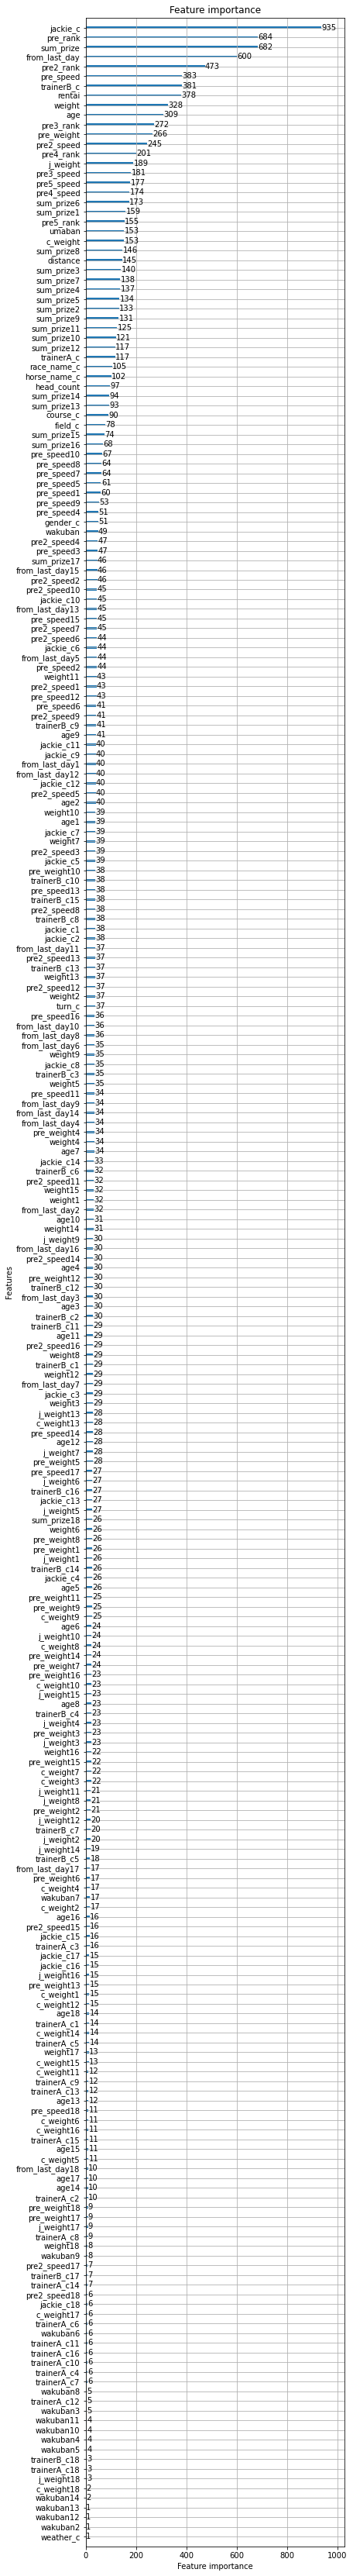

In [150]:
lgb_orig.plot_importance(model, figsize=(6, 60))

In [46]:
def test_one_day(X_orig, y, df, test_date, trial=5, frac=0.9, multi=False):
    
    score_sum = 0
    w = 0
    for seed in range(trial):
        X = X_orig.sample(frac=frac, axis=1)
        X_test, y_test, df_test = X[df['date']==test_date], y[df['date']==test_date], df[df['date']==test_date]
        trainval_num = (df['date'] < test_date).sum()
        val_num = int(trainval_num / 5)
        train_num = trainval_num - val_num
        while 1:
            if df.iloc[train_num-1]['race_num'] == df.iloc[train_num]['race_num']:
                train_num += 1
            else:
                break
        X_train, y_train, df_train = X[:train_num], y[:train_num], df[:train_num]
        X_val, y_val, df_val = X[train_num:trainval_num], y[train_num:trainval_num], df[train_num:trainval_num]

        X_trainval, y_trainval = X[:trainval_num], y[:trainval_num]
        
        lgb_train = lgb.Dataset(X_train, y_train)
        lgb_eval = lgb.Dataset(X_val, y_val)
    
        lgb_trainval = lgb.Dataset(X_trainval, y_trainval)
        
        params = {
            'objective': 'binary',
            #'metric': 'auc',
            #'metric': 'binary_logloss',
            'metric': 'pr_auc',
            #"metric" : "recovery",
            'random_seed': seed,
        }
        multi_params = {
            'objective': 'multiclassova',
            'num_class': 3,
            'metric': 'multi_error',
        }
        
        if not multi:
            best_params_ = params #model.params #
            feval = pr_auc
        else:
            best_params_ = multi_params
            feval = None
        
        model = lgb_orig.train(
            best_params_, 
            lgb_train,
            valid_sets=lgb_eval,
            num_boost_round=500,
            early_stopping_rounds=20,
            feval=feval,
            #feval=recovery,
        )
        
        score = model.predict(X_test, num_iteration=model.best_iteration)
        
        if not multi:
            score_sum += score * (model.best_score['valid_0'][best_params_['metric']])
            w += model.best_score['valid_0'][best_params_['metric']]
        else:
            score_sum += score[:, 0] * (1 - model.best_score['valid_0'][best_params_['metric']])
            w += 1 - model.best_score['valid_0'][best_params_['metric']]
    
    return score_sum / w

In [47]:
test_scores = np.array([])
test_from = 100

for i, tday in enumerate(np.sort(df['date'].unique()[-test_from:])):
    print(f'{i} / {len(np.sort(df["date"].unique()[-test_from:]))}')
    s = test_one_day(X, y, df, tday, trial=1, frac=1, multi=False)
    test_scores = np.append(test_scores, s)

0 / 100
[LightGBM] [Info] Number of positive: 101002, number of negative: 384189
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.417758 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51075
[LightGBM] [Info] Number of data points in the train set: 485191, number of used features: 357
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.208170 -> initscore=-1.335994
[LightGBM] [Info] Start training from score -1.335994
[1]	valid_0's pr_auc: 0.394734
Training until validation scores don't improve for 20 rounds
[2]	valid_0's pr_auc: 0.409705
[3]	valid_0's pr_auc: 0.41432
[4]	valid_0's pr_auc: 0.419112
[5]	valid_0's pr_auc: 0.42233
[6]	valid_0's pr_auc: 0.423702
[7]	valid_0's pr_auc: 0.425527
[8]	valid_0's pr_auc: 0.427007
[9]	valid_0's pr_auc: 0.428419
[10]	valid_0's pr_auc: 0.430075
[11]	valid_0's pr_auc: 0.431656
[12]	valid_0's pr_auc: 0.432717
[13]	valid_0's pr_auc: 0.433831
[14]	valid_0's pr_auc: 0

[237]	valid_0's pr_auc: 0.477784
[238]	valid_0's pr_auc: 0.477799
[239]	valid_0's pr_auc: 0.47777
[240]	valid_0's pr_auc: 0.477801
[241]	valid_0's pr_auc: 0.477775
[242]	valid_0's pr_auc: 0.47784
[243]	valid_0's pr_auc: 0.477878
[244]	valid_0's pr_auc: 0.477865
[245]	valid_0's pr_auc: 0.477865
[246]	valid_0's pr_auc: 0.477839
[247]	valid_0's pr_auc: 0.47791
[248]	valid_0's pr_auc: 0.477944
[249]	valid_0's pr_auc: 0.477988
[250]	valid_0's pr_auc: 0.477986
[251]	valid_0's pr_auc: 0.477988
[252]	valid_0's pr_auc: 0.477984
[253]	valid_0's pr_auc: 0.477967
[254]	valid_0's pr_auc: 0.477982
[255]	valid_0's pr_auc: 0.478005
[256]	valid_0's pr_auc: 0.477974
[257]	valid_0's pr_auc: 0.47797
[258]	valid_0's pr_auc: 0.477963
[259]	valid_0's pr_auc: 0.477946
[260]	valid_0's pr_auc: 0.477849
[261]	valid_0's pr_auc: 0.477857
[262]	valid_0's pr_auc: 0.477858
[263]	valid_0's pr_auc: 0.477845
[264]	valid_0's pr_auc: 0.47786
[265]	valid_0's pr_auc: 0.477827
[266]	valid_0's pr_auc: 0.477882
[267]	valid_0's

[197]	valid_0's pr_auc: 0.476864
[198]	valid_0's pr_auc: 0.476825
[199]	valid_0's pr_auc: 0.476814
[200]	valid_0's pr_auc: 0.476941
[201]	valid_0's pr_auc: 0.476935
[202]	valid_0's pr_auc: 0.476944
[203]	valid_0's pr_auc: 0.476943
[204]	valid_0's pr_auc: 0.477035
[205]	valid_0's pr_auc: 0.477326
[206]	valid_0's pr_auc: 0.477319
[207]	valid_0's pr_auc: 0.477351
[208]	valid_0's pr_auc: 0.477473
[209]	valid_0's pr_auc: 0.477503
[210]	valid_0's pr_auc: 0.477472
[211]	valid_0's pr_auc: 0.477473
[212]	valid_0's pr_auc: 0.477485
[213]	valid_0's pr_auc: 0.477447
[214]	valid_0's pr_auc: 0.47747
[215]	valid_0's pr_auc: 0.477414
[216]	valid_0's pr_auc: 0.477465
[217]	valid_0's pr_auc: 0.477533
[218]	valid_0's pr_auc: 0.477481
[219]	valid_0's pr_auc: 0.477455
[220]	valid_0's pr_auc: 0.477529
[221]	valid_0's pr_auc: 0.477533
[222]	valid_0's pr_auc: 0.477544
[223]	valid_0's pr_auc: 0.477588
[224]	valid_0's pr_auc: 0.477586
[225]	valid_0's pr_auc: 0.477664
[226]	valid_0's pr_auc: 0.477682
[227]	valid

[159]	valid_0's pr_auc: 0.475639
[160]	valid_0's pr_auc: 0.475646
[161]	valid_0's pr_auc: 0.475742
[162]	valid_0's pr_auc: 0.475766
[163]	valid_0's pr_auc: 0.475899
[164]	valid_0's pr_auc: 0.475948
[165]	valid_0's pr_auc: 0.476388
[166]	valid_0's pr_auc: 0.476511
[167]	valid_0's pr_auc: 0.476547
[168]	valid_0's pr_auc: 0.476509
[169]	valid_0's pr_auc: 0.47652
[170]	valid_0's pr_auc: 0.476525
[171]	valid_0's pr_auc: 0.476479
[172]	valid_0's pr_auc: 0.4765
[173]	valid_0's pr_auc: 0.47653
[174]	valid_0's pr_auc: 0.476547
[175]	valid_0's pr_auc: 0.476538
[176]	valid_0's pr_auc: 0.476602
[177]	valid_0's pr_auc: 0.476627
[178]	valid_0's pr_auc: 0.476649
[179]	valid_0's pr_auc: 0.476639
[180]	valid_0's pr_auc: 0.476617
[181]	valid_0's pr_auc: 0.476683
[182]	valid_0's pr_auc: 0.476831
[183]	valid_0's pr_auc: 0.476835
[184]	valid_0's pr_auc: 0.476999
[185]	valid_0's pr_auc: 0.476973
[186]	valid_0's pr_auc: 0.477039
[187]	valid_0's pr_auc: 0.477032
[188]	valid_0's pr_auc: 0.477069
[189]	valid_0'

[120]	valid_0's pr_auc: 0.472682
[121]	valid_0's pr_auc: 0.472796
[122]	valid_0's pr_auc: 0.472862
[123]	valid_0's pr_auc: 0.472964
[124]	valid_0's pr_auc: 0.473128
[125]	valid_0's pr_auc: 0.47317
[126]	valid_0's pr_auc: 0.473188
[127]	valid_0's pr_auc: 0.473354
[128]	valid_0's pr_auc: 0.473299
[129]	valid_0's pr_auc: 0.473343
[130]	valid_0's pr_auc: 0.473462
[131]	valid_0's pr_auc: 0.473515
[132]	valid_0's pr_auc: 0.473571
[133]	valid_0's pr_auc: 0.473672
[134]	valid_0's pr_auc: 0.473729
[135]	valid_0's pr_auc: 0.473761
[136]	valid_0's pr_auc: 0.473748
[137]	valid_0's pr_auc: 0.473815
[138]	valid_0's pr_auc: 0.473795
[139]	valid_0's pr_auc: 0.47388
[140]	valid_0's pr_auc: 0.473871
[141]	valid_0's pr_auc: 0.473969
[142]	valid_0's pr_auc: 0.47403
[143]	valid_0's pr_auc: 0.474079
[144]	valid_0's pr_auc: 0.474144
[145]	valid_0's pr_auc: 0.47422
[146]	valid_0's pr_auc: 0.474308
[147]	valid_0's pr_auc: 0.47436
[148]	valid_0's pr_auc: 0.474479
[149]	valid_0's pr_auc: 0.474551
[150]	valid_0's

[74]	valid_0's pr_auc: 0.465223
[75]	valid_0's pr_auc: 0.465465
[76]	valid_0's pr_auc: 0.466056
[77]	valid_0's pr_auc: 0.466125
[78]	valid_0's pr_auc: 0.466348
[79]	valid_0's pr_auc: 0.466477
[80]	valid_0's pr_auc: 0.466873
[81]	valid_0's pr_auc: 0.466951
[82]	valid_0's pr_auc: 0.467272
[83]	valid_0's pr_auc: 0.467527
[84]	valid_0's pr_auc: 0.467763
[85]	valid_0's pr_auc: 0.46797
[86]	valid_0's pr_auc: 0.46817
[87]	valid_0's pr_auc: 0.468147
[88]	valid_0's pr_auc: 0.468171
[89]	valid_0's pr_auc: 0.468355
[90]	valid_0's pr_auc: 0.468456
[91]	valid_0's pr_auc: 0.468643
[92]	valid_0's pr_auc: 0.468846
[93]	valid_0's pr_auc: 0.468938
[94]	valid_0's pr_auc: 0.469175
[95]	valid_0's pr_auc: 0.469216
[96]	valid_0's pr_auc: 0.469456
[97]	valid_0's pr_auc: 0.469472
[98]	valid_0's pr_auc: 0.469549
[99]	valid_0's pr_auc: 0.469937
[100]	valid_0's pr_auc: 0.470041
[101]	valid_0's pr_auc: 0.470231
[102]	valid_0's pr_auc: 0.470357
[103]	valid_0's pr_auc: 0.470498
[104]	valid_0's pr_auc: 0.470655
[105]

[2]	valid_0's pr_auc: 0.409939
[3]	valid_0's pr_auc: 0.414872
[4]	valid_0's pr_auc: 0.418843
[5]	valid_0's pr_auc: 0.421876
[6]	valid_0's pr_auc: 0.423897
[7]	valid_0's pr_auc: 0.425874
[8]	valid_0's pr_auc: 0.427049
[9]	valid_0's pr_auc: 0.428747
[10]	valid_0's pr_auc: 0.430125
[11]	valid_0's pr_auc: 0.431141
[12]	valid_0's pr_auc: 0.431925
[13]	valid_0's pr_auc: 0.43297
[14]	valid_0's pr_auc: 0.434273
[15]	valid_0's pr_auc: 0.43536
[16]	valid_0's pr_auc: 0.43622
[17]	valid_0's pr_auc: 0.437126
[18]	valid_0's pr_auc: 0.438001
[19]	valid_0's pr_auc: 0.438664
[20]	valid_0's pr_auc: 0.439986
[21]	valid_0's pr_auc: 0.440642
[22]	valid_0's pr_auc: 0.441412
[23]	valid_0's pr_auc: 0.442258
[24]	valid_0's pr_auc: 0.442784
[25]	valid_0's pr_auc: 0.443438
[26]	valid_0's pr_auc: 0.444004
[27]	valid_0's pr_auc: 0.445047
[28]	valid_0's pr_auc: 0.446258
[29]	valid_0's pr_auc: 0.447132
[30]	valid_0's pr_auc: 0.447408
[31]	valid_0's pr_auc: 0.448548
[32]	valid_0's pr_auc: 0.44913
[33]	valid_0's pr_au

[255]	valid_0's pr_auc: 0.477371
[256]	valid_0's pr_auc: 0.477385
[257]	valid_0's pr_auc: 0.477407
[258]	valid_0's pr_auc: 0.477429
[259]	valid_0's pr_auc: 0.477437
[260]	valid_0's pr_auc: 0.477447
[261]	valid_0's pr_auc: 0.477494
[262]	valid_0's pr_auc: 0.47756
[263]	valid_0's pr_auc: 0.477559
[264]	valid_0's pr_auc: 0.477635
[265]	valid_0's pr_auc: 0.477617
[266]	valid_0's pr_auc: 0.477582
[267]	valid_0's pr_auc: 0.477629
[268]	valid_0's pr_auc: 0.47757
[269]	valid_0's pr_auc: 0.477573
[270]	valid_0's pr_auc: 0.477532
[271]	valid_0's pr_auc: 0.477529
[272]	valid_0's pr_auc: 0.477629
[273]	valid_0's pr_auc: 0.477637
[274]	valid_0's pr_auc: 0.477543
[275]	valid_0's pr_auc: 0.477529
[276]	valid_0's pr_auc: 0.477542
[277]	valid_0's pr_auc: 0.477546
[278]	valid_0's pr_auc: 0.477556
[279]	valid_0's pr_auc: 0.477559
[280]	valid_0's pr_auc: 0.477483
[281]	valid_0's pr_auc: 0.477485
[282]	valid_0's pr_auc: 0.477483
[283]	valid_0's pr_auc: 0.477578
[284]	valid_0's pr_auc: 0.477506
[285]	valid_

[196]	valid_0's pr_auc: 0.475851
[197]	valid_0's pr_auc: 0.475872
[198]	valid_0's pr_auc: 0.475858
[199]	valid_0's pr_auc: 0.47588
[200]	valid_0's pr_auc: 0.475998
[201]	valid_0's pr_auc: 0.475999
[202]	valid_0's pr_auc: 0.475993
[203]	valid_0's pr_auc: 0.476106
[204]	valid_0's pr_auc: 0.476098
[205]	valid_0's pr_auc: 0.476066
[206]	valid_0's pr_auc: 0.476068
[207]	valid_0's pr_auc: 0.476115
[208]	valid_0's pr_auc: 0.476205
[209]	valid_0's pr_auc: 0.476221
[210]	valid_0's pr_auc: 0.476433
[211]	valid_0's pr_auc: 0.476427
[212]	valid_0's pr_auc: 0.476354
[213]	valid_0's pr_auc: 0.476345
[214]	valid_0's pr_auc: 0.476417
[215]	valid_0's pr_auc: 0.476394
[216]	valid_0's pr_auc: 0.476285
[217]	valid_0's pr_auc: 0.476345
[218]	valid_0's pr_auc: 0.476359
[219]	valid_0's pr_auc: 0.476376
[220]	valid_0's pr_auc: 0.476367
[221]	valid_0's pr_auc: 0.47635
[222]	valid_0's pr_auc: 0.476351
[223]	valid_0's pr_auc: 0.476345
[224]	valid_0's pr_auc: 0.476289
[225]	valid_0's pr_auc: 0.476301
[226]	valid_

[200]	valid_0's pr_auc: 0.476394
[201]	valid_0's pr_auc: 0.476542
[202]	valid_0's pr_auc: 0.476642
[203]	valid_0's pr_auc: 0.47663
[204]	valid_0's pr_auc: 0.476614
[205]	valid_0's pr_auc: 0.476988
[206]	valid_0's pr_auc: 0.477016
[207]	valid_0's pr_auc: 0.47705
[208]	valid_0's pr_auc: 0.477048
[209]	valid_0's pr_auc: 0.477053
[210]	valid_0's pr_auc: 0.477056
[211]	valid_0's pr_auc: 0.477057
[212]	valid_0's pr_auc: 0.477052
[213]	valid_0's pr_auc: 0.477089
[214]	valid_0's pr_auc: 0.477069
[215]	valid_0's pr_auc: 0.477047
[216]	valid_0's pr_auc: 0.47703
[217]	valid_0's pr_auc: 0.477035
[218]	valid_0's pr_auc: 0.477098
[219]	valid_0's pr_auc: 0.477094
[220]	valid_0's pr_auc: 0.477114
[221]	valid_0's pr_auc: 0.477107
[222]	valid_0's pr_auc: 0.477141
[223]	valid_0's pr_auc: 0.477189
[224]	valid_0's pr_auc: 0.477164
[225]	valid_0's pr_auc: 0.47721
[226]	valid_0's pr_auc: 0.47736
[227]	valid_0's pr_auc: 0.477373
[228]	valid_0's pr_auc: 0.477371
[229]	valid_0's pr_auc: 0.477333
[230]	valid_0's

[176]	valid_0's pr_auc: 0.47491
[177]	valid_0's pr_auc: 0.474964
[178]	valid_0's pr_auc: 0.474933
[179]	valid_0's pr_auc: 0.474938
[180]	valid_0's pr_auc: 0.474955
[181]	valid_0's pr_auc: 0.474965
[182]	valid_0's pr_auc: 0.474957
[183]	valid_0's pr_auc: 0.475021
[184]	valid_0's pr_auc: 0.475054
[185]	valid_0's pr_auc: 0.47502
[186]	valid_0's pr_auc: 0.474986
[187]	valid_0's pr_auc: 0.475013
[188]	valid_0's pr_auc: 0.475005
[189]	valid_0's pr_auc: 0.475049
[190]	valid_0's pr_auc: 0.475094
[191]	valid_0's pr_auc: 0.475114
[192]	valid_0's pr_auc: 0.475104
[193]	valid_0's pr_auc: 0.475115
[194]	valid_0's pr_auc: 0.475158
[195]	valid_0's pr_auc: 0.475118
[196]	valid_0's pr_auc: 0.475236
[197]	valid_0's pr_auc: 0.475194
[198]	valid_0's pr_auc: 0.47531
[199]	valid_0's pr_auc: 0.475315
[200]	valid_0's pr_auc: 0.475319
[201]	valid_0's pr_auc: 0.475313
[202]	valid_0's pr_auc: 0.475319
[203]	valid_0's pr_auc: 0.475326
[204]	valid_0's pr_auc: 0.475348
[205]	valid_0's pr_auc: 0.475388
[206]	valid_0

[148]	valid_0's pr_auc: 0.473988
[149]	valid_0's pr_auc: 0.474022
[150]	valid_0's pr_auc: 0.474073
[151]	valid_0's pr_auc: 0.474231
[152]	valid_0's pr_auc: 0.474211
[153]	valid_0's pr_auc: 0.474484
[154]	valid_0's pr_auc: 0.47455
[155]	valid_0's pr_auc: 0.474498
[156]	valid_0's pr_auc: 0.474583
[157]	valid_0's pr_auc: 0.474571
[158]	valid_0's pr_auc: 0.474616
[159]	valid_0's pr_auc: 0.47473
[160]	valid_0's pr_auc: 0.4747
[161]	valid_0's pr_auc: 0.474745
[162]	valid_0's pr_auc: 0.474958
[163]	valid_0's pr_auc: 0.474917
[164]	valid_0's pr_auc: 0.475313
[165]	valid_0's pr_auc: 0.475328
[166]	valid_0's pr_auc: 0.475353
[167]	valid_0's pr_auc: 0.475422
[168]	valid_0's pr_auc: 0.475455
[169]	valid_0's pr_auc: 0.475503
[170]	valid_0's pr_auc: 0.475705
[171]	valid_0's pr_auc: 0.475768
[172]	valid_0's pr_auc: 0.475999
[173]	valid_0's pr_auc: 0.475977
[174]	valid_0's pr_auc: 0.475993
[175]	valid_0's pr_auc: 0.476006
[176]	valid_0's pr_auc: 0.475988
[177]	valid_0's pr_auc: 0.476038
[178]	valid_0'

[102]	valid_0's pr_auc: 0.468616
[103]	valid_0's pr_auc: 0.468684
[104]	valid_0's pr_auc: 0.468826
[105]	valid_0's pr_auc: 0.468835
[106]	valid_0's pr_auc: 0.468908
[107]	valid_0's pr_auc: 0.469063
[108]	valid_0's pr_auc: 0.469808
[109]	valid_0's pr_auc: 0.470056
[110]	valid_0's pr_auc: 0.470163
[111]	valid_0's pr_auc: 0.47063
[112]	valid_0's pr_auc: 0.470659
[113]	valid_0's pr_auc: 0.470797
[114]	valid_0's pr_auc: 0.470936
[115]	valid_0's pr_auc: 0.470992
[116]	valid_0's pr_auc: 0.471038
[117]	valid_0's pr_auc: 0.471162
[118]	valid_0's pr_auc: 0.471395
[119]	valid_0's pr_auc: 0.471569
[120]	valid_0's pr_auc: 0.471681
[121]	valid_0's pr_auc: 0.471768
[122]	valid_0's pr_auc: 0.471785
[123]	valid_0's pr_auc: 0.471859
[124]	valid_0's pr_auc: 0.472088
[125]	valid_0's pr_auc: 0.472113
[126]	valid_0's pr_auc: 0.472238
[127]	valid_0's pr_auc: 0.472217
[128]	valid_0's pr_auc: 0.472284
[129]	valid_0's pr_auc: 0.472313
[130]	valid_0's pr_auc: 0.473205
[131]	valid_0's pr_auc: 0.473167
[132]	valid

[38]	valid_0's pr_auc: 0.452189
[39]	valid_0's pr_auc: 0.452734
[40]	valid_0's pr_auc: 0.45339
[41]	valid_0's pr_auc: 0.454193
[42]	valid_0's pr_auc: 0.454858
[43]	valid_0's pr_auc: 0.455074
[44]	valid_0's pr_auc: 0.4555
[45]	valid_0's pr_auc: 0.455901
[46]	valid_0's pr_auc: 0.456714
[47]	valid_0's pr_auc: 0.456997
[48]	valid_0's pr_auc: 0.457413
[49]	valid_0's pr_auc: 0.45766
[50]	valid_0's pr_auc: 0.457947
[51]	valid_0's pr_auc: 0.458761
[52]	valid_0's pr_auc: 0.459063
[53]	valid_0's pr_auc: 0.459339
[54]	valid_0's pr_auc: 0.459655
[55]	valid_0's pr_auc: 0.459946
[56]	valid_0's pr_auc: 0.460425
[57]	valid_0's pr_auc: 0.460789
[58]	valid_0's pr_auc: 0.461
[59]	valid_0's pr_auc: 0.461984
[60]	valid_0's pr_auc: 0.462176
[61]	valid_0's pr_auc: 0.462377
[62]	valid_0's pr_auc: 0.462576
[63]	valid_0's pr_auc: 0.462824
[64]	valid_0's pr_auc: 0.463099
[65]	valid_0's pr_auc: 0.463309
[66]	valid_0's pr_auc: 0.463613
[67]	valid_0's pr_auc: 0.463687
[68]	valid_0's pr_auc: 0.464383
[69]	valid_0's 

[24]	valid_0's pr_auc: 0.441174
[25]	valid_0's pr_auc: 0.442627
[26]	valid_0's pr_auc: 0.443851
[27]	valid_0's pr_auc: 0.444613
[28]	valid_0's pr_auc: 0.445223
[29]	valid_0's pr_auc: 0.44663
[30]	valid_0's pr_auc: 0.447696
[31]	valid_0's pr_auc: 0.448134
[32]	valid_0's pr_auc: 0.448683
[33]	valid_0's pr_auc: 0.44921
[34]	valid_0's pr_auc: 0.449702
[35]	valid_0's pr_auc: 0.450371
[36]	valid_0's pr_auc: 0.450605
[37]	valid_0's pr_auc: 0.451663
[38]	valid_0's pr_auc: 0.452473
[39]	valid_0's pr_auc: 0.453024
[40]	valid_0's pr_auc: 0.453305
[41]	valid_0's pr_auc: 0.453693
[42]	valid_0's pr_auc: 0.454465
[43]	valid_0's pr_auc: 0.455103
[44]	valid_0's pr_auc: 0.45542
[45]	valid_0's pr_auc: 0.455853
[46]	valid_0's pr_auc: 0.456244
[47]	valid_0's pr_auc: 0.456899
[48]	valid_0's pr_auc: 0.457196
[49]	valid_0's pr_auc: 0.457799
[50]	valid_0's pr_auc: 0.458109
[51]	valid_0's pr_auc: 0.458401
[52]	valid_0's pr_auc: 0.458794
[53]	valid_0's pr_auc: 0.459293
[54]	valid_0's pr_auc: 0.459586
[55]	valid_

[67]	valid_0's pr_auc: 0.462403
[68]	valid_0's pr_auc: 0.462535
[69]	valid_0's pr_auc: 0.462895
[70]	valid_0's pr_auc: 0.462992
[71]	valid_0's pr_auc: 0.463105
[72]	valid_0's pr_auc: 0.463227
[73]	valid_0's pr_auc: 0.463252
[74]	valid_0's pr_auc: 0.46343
[75]	valid_0's pr_auc: 0.464283
[76]	valid_0's pr_auc: 0.464352
[77]	valid_0's pr_auc: 0.464485
[78]	valid_0's pr_auc: 0.464698
[79]	valid_0's pr_auc: 0.464873
[80]	valid_0's pr_auc: 0.464924
[81]	valid_0's pr_auc: 0.465
[82]	valid_0's pr_auc: 0.465148
[83]	valid_0's pr_auc: 0.465309
[84]	valid_0's pr_auc: 0.465674
[85]	valid_0's pr_auc: 0.466067
[86]	valid_0's pr_auc: 0.466213
[87]	valid_0's pr_auc: 0.466349
[88]	valid_0's pr_auc: 0.46673
[89]	valid_0's pr_auc: 0.466797
[90]	valid_0's pr_auc: 0.466861
[91]	valid_0's pr_auc: 0.466957
[92]	valid_0's pr_auc: 0.46722
[93]	valid_0's pr_auc: 0.467408
[94]	valid_0's pr_auc: 0.467665
[95]	valid_0's pr_auc: 0.468025
[96]	valid_0's pr_auc: 0.468117
[97]	valid_0's pr_auc: 0.468298
[98]	valid_0's

[57]	valid_0's pr_auc: 0.45879
[58]	valid_0's pr_auc: 0.458943
[59]	valid_0's pr_auc: 0.459106
[60]	valid_0's pr_auc: 0.459575
[61]	valid_0's pr_auc: 0.459804
[62]	valid_0's pr_auc: 0.460737
[63]	valid_0's pr_auc: 0.460992
[64]	valid_0's pr_auc: 0.46124
[65]	valid_0's pr_auc: 0.461935
[66]	valid_0's pr_auc: 0.46256
[67]	valid_0's pr_auc: 0.463044
[68]	valid_0's pr_auc: 0.463134
[69]	valid_0's pr_auc: 0.463513
[70]	valid_0's pr_auc: 0.463744
[71]	valid_0's pr_auc: 0.464293
[72]	valid_0's pr_auc: 0.464528
[73]	valid_0's pr_auc: 0.464664
[74]	valid_0's pr_auc: 0.464997
[75]	valid_0's pr_auc: 0.465168
[76]	valid_0's pr_auc: 0.465279
[77]	valid_0's pr_auc: 0.465323
[78]	valid_0's pr_auc: 0.46586
[79]	valid_0's pr_auc: 0.466087
[80]	valid_0's pr_auc: 0.466243
[81]	valid_0's pr_auc: 0.46632
[82]	valid_0's pr_auc: 0.466458
[83]	valid_0's pr_auc: 0.466616
[84]	valid_0's pr_auc: 0.466876
[85]	valid_0's pr_auc: 0.466962
[86]	valid_0's pr_auc: 0.467094
[87]	valid_0's pr_auc: 0.467316
[88]	valid_0'

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.208183 -> initscore=-1.335915
[LightGBM] [Info] Start training from score -1.335915
[1]	valid_0's pr_auc: 0.395132
Training until validation scores don't improve for 20 rounds
[2]	valid_0's pr_auc: 0.408961
[3]	valid_0's pr_auc: 0.413878
[4]	valid_0's pr_auc: 0.418359
[5]	valid_0's pr_auc: 0.420923
[6]	valid_0's pr_auc: 0.422665
[7]	valid_0's pr_auc: 0.423778
[8]	valid_0's pr_auc: 0.425148
[9]	valid_0's pr_auc: 0.426728
[10]	valid_0's pr_auc: 0.428348
[11]	valid_0's pr_auc: 0.429766
[12]	valid_0's pr_auc: 0.430937
[13]	valid_0's pr_auc: 0.432055
[14]	valid_0's pr_auc: 0.433006
[15]	valid_0's pr_auc: 0.43378
[16]	valid_0's pr_auc: 0.435007
[17]	valid_0's pr_auc: 0.435885
[18]	valid_0's pr_auc: 0.437116
[19]	valid_0's pr_auc: 0.438049
[20]	valid_0's pr_auc: 0.438721
[21]	valid_0's pr_auc: 0.439595
[22]	valid_0's pr_auc: 0.440045
[23]	valid_0's pr_auc: 0.44066
[24]	valid_0's pr_auc: 0.441337
[25]	valid_0's pr_auc: 0.441959
[26]	valid_0's p

[248]	valid_0's pr_auc: 0.476974
[249]	valid_0's pr_auc: 0.476968
[250]	valid_0's pr_auc: 0.476954
[251]	valid_0's pr_auc: 0.476915
[252]	valid_0's pr_auc: 0.476841
[253]	valid_0's pr_auc: 0.476873
[254]	valid_0's pr_auc: 0.476851
[255]	valid_0's pr_auc: 0.476886
[256]	valid_0's pr_auc: 0.476894
[257]	valid_0's pr_auc: 0.47687
[258]	valid_0's pr_auc: 0.477092
[259]	valid_0's pr_auc: 0.477026
[260]	valid_0's pr_auc: 0.476993
[261]	valid_0's pr_auc: 0.476985
[262]	valid_0's pr_auc: 0.476953
[263]	valid_0's pr_auc: 0.476968
[264]	valid_0's pr_auc: 0.476976
[265]	valid_0's pr_auc: 0.476972
[266]	valid_0's pr_auc: 0.477006
[267]	valid_0's pr_auc: 0.477056
[268]	valid_0's pr_auc: 0.477045
[269]	valid_0's pr_auc: 0.477
[270]	valid_0's pr_auc: 0.476985
[271]	valid_0's pr_auc: 0.476984
[272]	valid_0's pr_auc: 0.476977
[273]	valid_0's pr_auc: 0.477024
[274]	valid_0's pr_auc: 0.47699
[275]	valid_0's pr_auc: 0.476892
[276]	valid_0's pr_auc: 0.47686
[277]	valid_0's pr_auc: 0.476856
[278]	valid_0's 

[204]	valid_0's pr_auc: 0.476405
[205]	valid_0's pr_auc: 0.476397
[206]	valid_0's pr_auc: 0.476455
[207]	valid_0's pr_auc: 0.476397
[208]	valid_0's pr_auc: 0.476403
[209]	valid_0's pr_auc: 0.476461
[210]	valid_0's pr_auc: 0.476512
[211]	valid_0's pr_auc: 0.476448
[212]	valid_0's pr_auc: 0.47649
[213]	valid_0's pr_auc: 0.476491
[214]	valid_0's pr_auc: 0.476487
[215]	valid_0's pr_auc: 0.476488
[216]	valid_0's pr_auc: 0.476457
[217]	valid_0's pr_auc: 0.476452
[218]	valid_0's pr_auc: 0.476394
[219]	valid_0's pr_auc: 0.476411
[220]	valid_0's pr_auc: 0.476385
[221]	valid_0's pr_auc: 0.476411
[222]	valid_0's pr_auc: 0.476357
[223]	valid_0's pr_auc: 0.476334
[224]	valid_0's pr_auc: 0.476449
[225]	valid_0's pr_auc: 0.476545
[226]	valid_0's pr_auc: 0.476507
[227]	valid_0's pr_auc: 0.476617
[228]	valid_0's pr_auc: 0.476624
[229]	valid_0's pr_auc: 0.476634
[230]	valid_0's pr_auc: 0.476657
[231]	valid_0's pr_auc: 0.476637
[232]	valid_0's pr_auc: 0.476627
[233]	valid_0's pr_auc: 0.476652
[234]	valid

[81]	valid_0's pr_auc: 0.466168
[82]	valid_0's pr_auc: 0.466333
[83]	valid_0's pr_auc: 0.466456
[84]	valid_0's pr_auc: 0.466622
[85]	valid_0's pr_auc: 0.466779
[86]	valid_0's pr_auc: 0.466964
[87]	valid_0's pr_auc: 0.466995
[88]	valid_0's pr_auc: 0.46723
[89]	valid_0's pr_auc: 0.467354
[90]	valid_0's pr_auc: 0.46789
[91]	valid_0's pr_auc: 0.467964
[92]	valid_0's pr_auc: 0.468261
[93]	valid_0's pr_auc: 0.468347
[94]	valid_0's pr_auc: 0.468413
[95]	valid_0's pr_auc: 0.468437
[96]	valid_0's pr_auc: 0.468609
[97]	valid_0's pr_auc: 0.468789
[98]	valid_0's pr_auc: 0.469096
[99]	valid_0's pr_auc: 0.469119
[100]	valid_0's pr_auc: 0.469245
[101]	valid_0's pr_auc: 0.469259
[102]	valid_0's pr_auc: 0.469286
[103]	valid_0's pr_auc: 0.469482
[104]	valid_0's pr_auc: 0.469552
[105]	valid_0's pr_auc: 0.469647
[106]	valid_0's pr_auc: 0.469734
[107]	valid_0's pr_auc: 0.469871
[108]	valid_0's pr_auc: 0.469871
[109]	valid_0's pr_auc: 0.469934
[110]	valid_0's pr_auc: 0.469991
[111]	valid_0's pr_auc: 0.47002

[99]	valid_0's pr_auc: 0.46943
[100]	valid_0's pr_auc: 0.469464
[101]	valid_0's pr_auc: 0.469554
[102]	valid_0's pr_auc: 0.469849
[103]	valid_0's pr_auc: 0.469902
[104]	valid_0's pr_auc: 0.470015
[105]	valid_0's pr_auc: 0.470167
[106]	valid_0's pr_auc: 0.47012
[107]	valid_0's pr_auc: 0.470207
[108]	valid_0's pr_auc: 0.470389
[109]	valid_0's pr_auc: 0.470479
[110]	valid_0's pr_auc: 0.471058
[111]	valid_0's pr_auc: 0.471214
[112]	valid_0's pr_auc: 0.471253
[113]	valid_0's pr_auc: 0.471258
[114]	valid_0's pr_auc: 0.471442
[115]	valid_0's pr_auc: 0.471457
[116]	valid_0's pr_auc: 0.471484
[117]	valid_0's pr_auc: 0.47154
[118]	valid_0's pr_auc: 0.471486
[119]	valid_0's pr_auc: 0.471595
[120]	valid_0's pr_auc: 0.47181
[121]	valid_0's pr_auc: 0.471761
[122]	valid_0's pr_auc: 0.471905
[123]	valid_0's pr_auc: 0.471971
[124]	valid_0's pr_auc: 0.472103
[125]	valid_0's pr_auc: 0.472209
[126]	valid_0's pr_auc: 0.472204
[127]	valid_0's pr_auc: 0.472206
[128]	valid_0's pr_auc: 0.472257
[129]	valid_0's

[10]	valid_0's pr_auc: 0.428384
[11]	valid_0's pr_auc: 0.430181
[12]	valid_0's pr_auc: 0.43122
[13]	valid_0's pr_auc: 0.432315
[14]	valid_0's pr_auc: 0.43356
[15]	valid_0's pr_auc: 0.434547
[16]	valid_0's pr_auc: 0.435486
[17]	valid_0's pr_auc: 0.436468
[18]	valid_0's pr_auc: 0.437576
[19]	valid_0's pr_auc: 0.438696
[20]	valid_0's pr_auc: 0.439593
[21]	valid_0's pr_auc: 0.440125
[22]	valid_0's pr_auc: 0.44079
[23]	valid_0's pr_auc: 0.441496
[24]	valid_0's pr_auc: 0.441974
[25]	valid_0's pr_auc: 0.442914
[26]	valid_0's pr_auc: 0.443936
[27]	valid_0's pr_auc: 0.444994
[28]	valid_0's pr_auc: 0.445649
[29]	valid_0's pr_auc: 0.446523
[30]	valid_0's pr_auc: 0.447623
[31]	valid_0's pr_auc: 0.448194
[32]	valid_0's pr_auc: 0.448897
[33]	valid_0's pr_auc: 0.449226
[34]	valid_0's pr_auc: 0.449562
[35]	valid_0's pr_auc: 0.451039
[36]	valid_0's pr_auc: 0.451895
[37]	valid_0's pr_auc: 0.452065
[38]	valid_0's pr_auc: 0.452543
[39]	valid_0's pr_auc: 0.452965
[40]	valid_0's pr_auc: 0.453394
[41]	valid_

[LightGBM] [Info] Number of positive: 102526, number of negative: 389849
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.410776 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51107
[LightGBM] [Info] Number of data points in the train set: 492375, number of used features: 357
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.208227 -> initscore=-1.335643
[LightGBM] [Info] Start training from score -1.335643
[1]	valid_0's pr_auc: 0.394672
Training until validation scores don't improve for 20 rounds
[2]	valid_0's pr_auc: 0.409447
[3]	valid_0's pr_auc: 0.413561
[4]	valid_0's pr_auc: 0.418069
[5]	valid_0's pr_auc: 0.420554
[6]	valid_0's pr_auc: 0.422493
[7]	valid_0's pr_auc: 0.42497
[8]	valid_0's pr_auc: 0.425811
[9]	valid_0's pr_auc: 0.427625
[10]	valid_0's pr_auc: 0.429243
[11]	valid_0's pr_auc: 0.430338
[12]	valid_0's pr_auc: 0.431906
[13]	valid_0's pr_auc: 0.433205
[14]	valid_0's pr_auc: 0.434348

[239]	valid_0's pr_auc: 0.47542
[240]	valid_0's pr_auc: 0.475445
[241]	valid_0's pr_auc: 0.475484
[242]	valid_0's pr_auc: 0.475508
[243]	valid_0's pr_auc: 0.475479
[244]	valid_0's pr_auc: 0.475502
[245]	valid_0's pr_auc: 0.475465
[246]	valid_0's pr_auc: 0.475472
[247]	valid_0's pr_auc: 0.475428
[248]	valid_0's pr_auc: 0.475366
[249]	valid_0's pr_auc: 0.475363
[250]	valid_0's pr_auc: 0.47533
[251]	valid_0's pr_auc: 0.475329
[252]	valid_0's pr_auc: 0.475376
[253]	valid_0's pr_auc: 0.475372
[254]	valid_0's pr_auc: 0.475386
[255]	valid_0's pr_auc: 0.475382
[256]	valid_0's pr_auc: 0.4754
[257]	valid_0's pr_auc: 0.475409
[258]	valid_0's pr_auc: 0.475406
[259]	valid_0's pr_auc: 0.475379
[260]	valid_0's pr_auc: 0.475468
[261]	valid_0's pr_auc: 0.475443
[262]	valid_0's pr_auc: 0.475513
[263]	valid_0's pr_auc: 0.475457
[264]	valid_0's pr_auc: 0.47543
[265]	valid_0's pr_auc: 0.47546
[266]	valid_0's pr_auc: 0.475426
[267]	valid_0's pr_auc: 0.47547
[268]	valid_0's pr_auc: 0.47543
[269]	valid_0's pr

[190]	valid_0's pr_auc: 0.474275
[191]	valid_0's pr_auc: 0.474246
[192]	valid_0's pr_auc: 0.474252
[193]	valid_0's pr_auc: 0.474321
[194]	valid_0's pr_auc: 0.474292
[195]	valid_0's pr_auc: 0.474309
[196]	valid_0's pr_auc: 0.474306
[197]	valid_0's pr_auc: 0.474226
[198]	valid_0's pr_auc: 0.474257
[199]	valid_0's pr_auc: 0.474254
[200]	valid_0's pr_auc: 0.47434
[201]	valid_0's pr_auc: 0.474348
[202]	valid_0's pr_auc: 0.474376
[203]	valid_0's pr_auc: 0.474463
[204]	valid_0's pr_auc: 0.474506
[205]	valid_0's pr_auc: 0.474505
[206]	valid_0's pr_auc: 0.474572
[207]	valid_0's pr_auc: 0.47458
[208]	valid_0's pr_auc: 0.474596
[209]	valid_0's pr_auc: 0.474601
[210]	valid_0's pr_auc: 0.474552
[211]	valid_0's pr_auc: 0.474564
[212]	valid_0's pr_auc: 0.474556
[213]	valid_0's pr_auc: 0.47453
[214]	valid_0's pr_auc: 0.47451
[215]	valid_0's pr_auc: 0.474481
[216]	valid_0's pr_auc: 0.474474
[217]	valid_0's pr_auc: 0.474504
[218]	valid_0's pr_auc: 0.474554
[219]	valid_0's pr_auc: 0.474568
[220]	valid_0'

[195]	valid_0's pr_auc: 0.477388
[196]	valid_0's pr_auc: 0.477363
[197]	valid_0's pr_auc: 0.477285
[198]	valid_0's pr_auc: 0.477252
[199]	valid_0's pr_auc: 0.477255
[200]	valid_0's pr_auc: 0.477239
[201]	valid_0's pr_auc: 0.477389
[202]	valid_0's pr_auc: 0.477385
[203]	valid_0's pr_auc: 0.477434
[204]	valid_0's pr_auc: 0.477448
[205]	valid_0's pr_auc: 0.47739
[206]	valid_0's pr_auc: 0.4774
[207]	valid_0's pr_auc: 0.477392
[208]	valid_0's pr_auc: 0.477397
[209]	valid_0's pr_auc: 0.47738
[210]	valid_0's pr_auc: 0.477396
[211]	valid_0's pr_auc: 0.477444
[212]	valid_0's pr_auc: 0.477709
[213]	valid_0's pr_auc: 0.477722
[214]	valid_0's pr_auc: 0.477789
[215]	valid_0's pr_auc: 0.47778
[216]	valid_0's pr_auc: 0.477775
[217]	valid_0's pr_auc: 0.477792
[218]	valid_0's pr_auc: 0.47777
[219]	valid_0's pr_auc: 0.477771
[220]	valid_0's pr_auc: 0.477776
[221]	valid_0's pr_auc: 0.477869
[222]	valid_0's pr_auc: 0.477861
[223]	valid_0's pr_auc: 0.477876
[224]	valid_0's pr_auc: 0.477916
[225]	valid_0's 

[108]	valid_0's pr_auc: 0.471385
[109]	valid_0's pr_auc: 0.471439
[110]	valid_0's pr_auc: 0.471512
[111]	valid_0's pr_auc: 0.471616
[112]	valid_0's pr_auc: 0.471698
[113]	valid_0's pr_auc: 0.47178
[114]	valid_0's pr_auc: 0.471865
[115]	valid_0's pr_auc: 0.471975
[116]	valid_0's pr_auc: 0.472005
[117]	valid_0's pr_auc: 0.47202
[118]	valid_0's pr_auc: 0.472062
[119]	valid_0's pr_auc: 0.472158
[120]	valid_0's pr_auc: 0.472272
[121]	valid_0's pr_auc: 0.472387
[122]	valid_0's pr_auc: 0.472533
[123]	valid_0's pr_auc: 0.47257
[124]	valid_0's pr_auc: 0.472638
[125]	valid_0's pr_auc: 0.472708
[126]	valid_0's pr_auc: 0.472697
[127]	valid_0's pr_auc: 0.472836
[128]	valid_0's pr_auc: 0.473052
[129]	valid_0's pr_auc: 0.473081
[130]	valid_0's pr_auc: 0.473302
[131]	valid_0's pr_auc: 0.473301
[132]	valid_0's pr_auc: 0.473451
[133]	valid_0's pr_auc: 0.473545
[134]	valid_0's pr_auc: 0.473548
[135]	valid_0's pr_auc: 0.473517
[136]	valid_0's pr_auc: 0.473598
[137]	valid_0's pr_auc: 0.473631
[138]	valid_0

[116]	valid_0's pr_auc: 0.472571
[117]	valid_0's pr_auc: 0.473003
[118]	valid_0's pr_auc: 0.473137
[119]	valid_0's pr_auc: 0.473258
[120]	valid_0's pr_auc: 0.473266
[121]	valid_0's pr_auc: 0.473337
[122]	valid_0's pr_auc: 0.473455
[123]	valid_0's pr_auc: 0.473419
[124]	valid_0's pr_auc: 0.473479
[125]	valid_0's pr_auc: 0.473585
[126]	valid_0's pr_auc: 0.473871
[127]	valid_0's pr_auc: 0.473944
[128]	valid_0's pr_auc: 0.474046
[129]	valid_0's pr_auc: 0.47405
[130]	valid_0's pr_auc: 0.474097
[131]	valid_0's pr_auc: 0.47437
[132]	valid_0's pr_auc: 0.474505
[133]	valid_0's pr_auc: 0.474766
[134]	valid_0's pr_auc: 0.474842
[135]	valid_0's pr_auc: 0.474886
[136]	valid_0's pr_auc: 0.474902
[137]	valid_0's pr_auc: 0.47492
[138]	valid_0's pr_auc: 0.475008
[139]	valid_0's pr_auc: 0.475062
[140]	valid_0's pr_auc: 0.475143
[141]	valid_0's pr_auc: 0.475169
[142]	valid_0's pr_auc: 0.475146
[143]	valid_0's pr_auc: 0.475155
[144]	valid_0's pr_auc: 0.475234
[145]	valid_0's pr_auc: 0.475355
[146]	valid_0

[139]	valid_0's pr_auc: 0.475006
[140]	valid_0's pr_auc: 0.475021
[141]	valid_0's pr_auc: 0.475028
[142]	valid_0's pr_auc: 0.47505
[143]	valid_0's pr_auc: 0.475027
[144]	valid_0's pr_auc: 0.47505
[145]	valid_0's pr_auc: 0.475023
[146]	valid_0's pr_auc: 0.475088
[147]	valid_0's pr_auc: 0.475157
[148]	valid_0's pr_auc: 0.475182
[149]	valid_0's pr_auc: 0.475407
[150]	valid_0's pr_auc: 0.475594
[151]	valid_0's pr_auc: 0.475682
[152]	valid_0's pr_auc: 0.475738
[153]	valid_0's pr_auc: 0.475761
[154]	valid_0's pr_auc: 0.475811
[155]	valid_0's pr_auc: 0.475835
[156]	valid_0's pr_auc: 0.475779
[157]	valid_0's pr_auc: 0.475839
[158]	valid_0's pr_auc: 0.475849
[159]	valid_0's pr_auc: 0.475822
[160]	valid_0's pr_auc: 0.47579
[161]	valid_0's pr_auc: 0.475851
[162]	valid_0's pr_auc: 0.475822
[163]	valid_0's pr_auc: 0.47579
[164]	valid_0's pr_auc: 0.475811
[165]	valid_0's pr_auc: 0.47588
[166]	valid_0's pr_auc: 0.475852
[167]	valid_0's pr_auc: 0.475853
[168]	valid_0's pr_auc: 0.475929
[169]	valid_0's

[69]	valid_0's pr_auc: 0.463608
[70]	valid_0's pr_auc: 0.464314
[71]	valid_0's pr_auc: 0.464441
[72]	valid_0's pr_auc: 0.464568
[73]	valid_0's pr_auc: 0.464732
[74]	valid_0's pr_auc: 0.465022
[75]	valid_0's pr_auc: 0.465819
[76]	valid_0's pr_auc: 0.465952
[77]	valid_0's pr_auc: 0.466171
[78]	valid_0's pr_auc: 0.466303
[79]	valid_0's pr_auc: 0.466465
[80]	valid_0's pr_auc: 0.466561
[81]	valid_0's pr_auc: 0.466787
[82]	valid_0's pr_auc: 0.46698
[83]	valid_0's pr_auc: 0.467163
[84]	valid_0's pr_auc: 0.46725
[85]	valid_0's pr_auc: 0.46756
[86]	valid_0's pr_auc: 0.46804
[87]	valid_0's pr_auc: 0.468154
[88]	valid_0's pr_auc: 0.46828
[89]	valid_0's pr_auc: 0.468414
[90]	valid_0's pr_auc: 0.468477
[91]	valid_0's pr_auc: 0.468866
[92]	valid_0's pr_auc: 0.46888
[93]	valid_0's pr_auc: 0.468949
[94]	valid_0's pr_auc: 0.469118
[95]	valid_0's pr_auc: 0.469375
[96]	valid_0's pr_auc: 0.469428
[97]	valid_0's pr_auc: 0.469707
[98]	valid_0's pr_auc: 0.469807
[99]	valid_0's pr_auc: 0.469855
[100]	valid_0'

[321]	valid_0's pr_auc: 0.477883
[322]	valid_0's pr_auc: 0.477893
[323]	valid_0's pr_auc: 0.47788
[324]	valid_0's pr_auc: 0.477887
[325]	valid_0's pr_auc: 0.47787
[326]	valid_0's pr_auc: 0.477827
[327]	valid_0's pr_auc: 0.477828
[328]	valid_0's pr_auc: 0.477749
[329]	valid_0's pr_auc: 0.47773
[330]	valid_0's pr_auc: 0.477741
[331]	valid_0's pr_auc: 0.477722
[332]	valid_0's pr_auc: 0.477723
[333]	valid_0's pr_auc: 0.477721
[334]	valid_0's pr_auc: 0.477776
[335]	valid_0's pr_auc: 0.477786
[336]	valid_0's pr_auc: 0.477755
[337]	valid_0's pr_auc: 0.477752
[338]	valid_0's pr_auc: 0.477747
[339]	valid_0's pr_auc: 0.47766
[340]	valid_0's pr_auc: 0.477669
[341]	valid_0's pr_auc: 0.477671
[342]	valid_0's pr_auc: 0.477691
Early stopping, best iteration is:
[322]	valid_0's pr_auc: 0.477893
27 / 100
[LightGBM] [Info] Number of positive: 103075, number of negative: 391746
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.505512 seconds.
You can set `force_co

[212]	valid_0's pr_auc: 0.47755
[213]	valid_0's pr_auc: 0.477478
[214]	valid_0's pr_auc: 0.477457
[215]	valid_0's pr_auc: 0.477492
[216]	valid_0's pr_auc: 0.477499
[217]	valid_0's pr_auc: 0.477528
[218]	valid_0's pr_auc: 0.477538
[219]	valid_0's pr_auc: 0.477521
[220]	valid_0's pr_auc: 0.477519
[221]	valid_0's pr_auc: 0.477496
[222]	valid_0's pr_auc: 0.477525
[223]	valid_0's pr_auc: 0.477555
[224]	valid_0's pr_auc: 0.477565
[225]	valid_0's pr_auc: 0.477594
[226]	valid_0's pr_auc: 0.477618
[227]	valid_0's pr_auc: 0.477625
[228]	valid_0's pr_auc: 0.477621
[229]	valid_0's pr_auc: 0.477573
[230]	valid_0's pr_auc: 0.477593
[231]	valid_0's pr_auc: 0.477687
[232]	valid_0's pr_auc: 0.477626
[233]	valid_0's pr_auc: 0.477578
[234]	valid_0's pr_auc: 0.477556
[235]	valid_0's pr_auc: 0.477552
[236]	valid_0's pr_auc: 0.477579
[237]	valid_0's pr_auc: 0.477591
[238]	valid_0's pr_auc: 0.477649
[239]	valid_0's pr_auc: 0.477666
[240]	valid_0's pr_auc: 0.477766
[241]	valid_0's pr_auc: 0.477901
[242]	valid

[178]	valid_0's pr_auc: 0.475516
[179]	valid_0's pr_auc: 0.475483
[180]	valid_0's pr_auc: 0.475471
[181]	valid_0's pr_auc: 0.475461
[182]	valid_0's pr_auc: 0.475459
[183]	valid_0's pr_auc: 0.475494
[184]	valid_0's pr_auc: 0.475936
[185]	valid_0's pr_auc: 0.475915
[186]	valid_0's pr_auc: 0.475934
[187]	valid_0's pr_auc: 0.475886
[188]	valid_0's pr_auc: 0.47585
[189]	valid_0's pr_auc: 0.475841
[190]	valid_0's pr_auc: 0.476021
[191]	valid_0's pr_auc: 0.476035
[192]	valid_0's pr_auc: 0.476065
[193]	valid_0's pr_auc: 0.476079
[194]	valid_0's pr_auc: 0.476176
[195]	valid_0's pr_auc: 0.476189
[196]	valid_0's pr_auc: 0.476323
[197]	valid_0's pr_auc: 0.476321
[198]	valid_0's pr_auc: 0.476457
[199]	valid_0's pr_auc: 0.476528
[200]	valid_0's pr_auc: 0.476546
[201]	valid_0's pr_auc: 0.47678
[202]	valid_0's pr_auc: 0.476827
[203]	valid_0's pr_auc: 0.476796
[204]	valid_0's pr_auc: 0.476784
[205]	valid_0's pr_auc: 0.476749
[206]	valid_0's pr_auc: 0.476759
[207]	valid_0's pr_auc: 0.47677
[208]	valid_0

[190]	valid_0's pr_auc: 0.475465
[191]	valid_0's pr_auc: 0.475453
[192]	valid_0's pr_auc: 0.475462
[193]	valid_0's pr_auc: 0.475462
[194]	valid_0's pr_auc: 0.475414
[195]	valid_0's pr_auc: 0.475489
[196]	valid_0's pr_auc: 0.475541
[197]	valid_0's pr_auc: 0.475507
[198]	valid_0's pr_auc: 0.475566
[199]	valid_0's pr_auc: 0.475582
[200]	valid_0's pr_auc: 0.475537
[201]	valid_0's pr_auc: 0.475581
[202]	valid_0's pr_auc: 0.475789
[203]	valid_0's pr_auc: 0.475828
[204]	valid_0's pr_auc: 0.475866
[205]	valid_0's pr_auc: 0.475835
[206]	valid_0's pr_auc: 0.475814
[207]	valid_0's pr_auc: 0.475823
[208]	valid_0's pr_auc: 0.475824
[209]	valid_0's pr_auc: 0.475796
[210]	valid_0's pr_auc: 0.475886
[211]	valid_0's pr_auc: 0.475852
[212]	valid_0's pr_auc: 0.475916
[213]	valid_0's pr_auc: 0.475978
[214]	valid_0's pr_auc: 0.47603
[215]	valid_0's pr_auc: 0.476055
[216]	valid_0's pr_auc: 0.476095
[217]	valid_0's pr_auc: 0.476087
[218]	valid_0's pr_auc: 0.476094
[219]	valid_0's pr_auc: 0.476121
[220]	valid

[169]	valid_0's pr_auc: 0.476601
[170]	valid_0's pr_auc: 0.476667
[171]	valid_0's pr_auc: 0.476647
[172]	valid_0's pr_auc: 0.476649
[173]	valid_0's pr_auc: 0.476901
[174]	valid_0's pr_auc: 0.476895
[175]	valid_0's pr_auc: 0.476949
[176]	valid_0's pr_auc: 0.477027
[177]	valid_0's pr_auc: 0.477069
[178]	valid_0's pr_auc: 0.477038
[179]	valid_0's pr_auc: 0.477086
[180]	valid_0's pr_auc: 0.477086
[181]	valid_0's pr_auc: 0.477094
[182]	valid_0's pr_auc: 0.477094
[183]	valid_0's pr_auc: 0.477087
[184]	valid_0's pr_auc: 0.477148
[185]	valid_0's pr_auc: 0.477176
[186]	valid_0's pr_auc: 0.477207
[187]	valid_0's pr_auc: 0.477273
[188]	valid_0's pr_auc: 0.477311
[189]	valid_0's pr_auc: 0.47731
[190]	valid_0's pr_auc: 0.477273
[191]	valid_0's pr_auc: 0.477252
[192]	valid_0's pr_auc: 0.477269
[193]	valid_0's pr_auc: 0.477232
[194]	valid_0's pr_auc: 0.4772
[195]	valid_0's pr_auc: 0.477246
[196]	valid_0's pr_auc: 0.477317
[197]	valid_0's pr_auc: 0.477286
[198]	valid_0's pr_auc: 0.477548
[199]	valid_0

[158]	valid_0's pr_auc: 0.474746
[159]	valid_0's pr_auc: 0.474794
[160]	valid_0's pr_auc: 0.474844
[161]	valid_0's pr_auc: 0.474884
[162]	valid_0's pr_auc: 0.474899
[163]	valid_0's pr_auc: 0.475
[164]	valid_0's pr_auc: 0.47498
[165]	valid_0's pr_auc: 0.474967
[166]	valid_0's pr_auc: 0.474949
[167]	valid_0's pr_auc: 0.474948
[168]	valid_0's pr_auc: 0.475291
[169]	valid_0's pr_auc: 0.475382
[170]	valid_0's pr_auc: 0.475395
[171]	valid_0's pr_auc: 0.475358
[172]	valid_0's pr_auc: 0.475425
[173]	valid_0's pr_auc: 0.475511
[174]	valid_0's pr_auc: 0.475833
[175]	valid_0's pr_auc: 0.475833
[176]	valid_0's pr_auc: 0.475806
[177]	valid_0's pr_auc: 0.475816
[178]	valid_0's pr_auc: 0.475808
[179]	valid_0's pr_auc: 0.475777
[180]	valid_0's pr_auc: 0.475767
[181]	valid_0's pr_auc: 0.475795
[182]	valid_0's pr_auc: 0.475959
[183]	valid_0's pr_auc: 0.47631
[184]	valid_0's pr_auc: 0.476298
[185]	valid_0's pr_auc: 0.476309
[186]	valid_0's pr_auc: 0.476325
[187]	valid_0's pr_auc: 0.476417
[188]	valid_0's

[76]	valid_0's pr_auc: 0.465465
[77]	valid_0's pr_auc: 0.465619
[78]	valid_0's pr_auc: 0.465786
[79]	valid_0's pr_auc: 0.465935
[80]	valid_0's pr_auc: 0.466026
[81]	valid_0's pr_auc: 0.466206
[82]	valid_0's pr_auc: 0.46628
[83]	valid_0's pr_auc: 0.466324
[84]	valid_0's pr_auc: 0.466491
[85]	valid_0's pr_auc: 0.466494
[86]	valid_0's pr_auc: 0.466708
[87]	valid_0's pr_auc: 0.466931
[88]	valid_0's pr_auc: 0.467364
[89]	valid_0's pr_auc: 0.467447
[90]	valid_0's pr_auc: 0.467559
[91]	valid_0's pr_auc: 0.467615
[92]	valid_0's pr_auc: 0.467783
[93]	valid_0's pr_auc: 0.467855
[94]	valid_0's pr_auc: 0.467866
[95]	valid_0's pr_auc: 0.468052
[96]	valid_0's pr_auc: 0.46815
[97]	valid_0's pr_auc: 0.468473
[98]	valid_0's pr_auc: 0.468488
[99]	valid_0's pr_auc: 0.468607
[100]	valid_0's pr_auc: 0.46944
[101]	valid_0's pr_auc: 0.469537
[102]	valid_0's pr_auc: 0.469564
[103]	valid_0's pr_auc: 0.469667
[104]	valid_0's pr_auc: 0.470452
[105]	valid_0's pr_auc: 0.470524
[106]	valid_0's pr_auc: 0.470651
[107

[84]	valid_0's pr_auc: 0.466705
[85]	valid_0's pr_auc: 0.46683
[86]	valid_0's pr_auc: 0.466876
[87]	valid_0's pr_auc: 0.467228
[88]	valid_0's pr_auc: 0.467477
[89]	valid_0's pr_auc: 0.467458
[90]	valid_0's pr_auc: 0.467888
[91]	valid_0's pr_auc: 0.468164
[92]	valid_0's pr_auc: 0.468155
[93]	valid_0's pr_auc: 0.468187
[94]	valid_0's pr_auc: 0.468292
[95]	valid_0's pr_auc: 0.468648
[96]	valid_0's pr_auc: 0.468755
[97]	valid_0's pr_auc: 0.468831
[98]	valid_0's pr_auc: 0.468909
[99]	valid_0's pr_auc: 0.469047
[100]	valid_0's pr_auc: 0.469085
[101]	valid_0's pr_auc: 0.469111
[102]	valid_0's pr_auc: 0.469306
[103]	valid_0's pr_auc: 0.469403
[104]	valid_0's pr_auc: 0.469532
[105]	valid_0's pr_auc: 0.46963
[106]	valid_0's pr_auc: 0.469726
[107]	valid_0's pr_auc: 0.469884
[108]	valid_0's pr_auc: 0.470382
[109]	valid_0's pr_auc: 0.470391
[110]	valid_0's pr_auc: 0.470478
[111]	valid_0's pr_auc: 0.470523
[112]	valid_0's pr_auc: 0.470721
[113]	valid_0's pr_auc: 0.470845
[114]	valid_0's pr_auc: 0.47

[93]	valid_0's pr_auc: 0.469367
[94]	valid_0's pr_auc: 0.469536
[95]	valid_0's pr_auc: 0.469842
[96]	valid_0's pr_auc: 0.469939
[97]	valid_0's pr_auc: 0.469972
[98]	valid_0's pr_auc: 0.469982
[99]	valid_0's pr_auc: 0.470231
[100]	valid_0's pr_auc: 0.470379
[101]	valid_0's pr_auc: 0.47044
[102]	valid_0's pr_auc: 0.470475
[103]	valid_0's pr_auc: 0.470647
[104]	valid_0's pr_auc: 0.470699
[105]	valid_0's pr_auc: 0.470709
[106]	valid_0's pr_auc: 0.470873
[107]	valid_0's pr_auc: 0.470945
[108]	valid_0's pr_auc: 0.470942
[109]	valid_0's pr_auc: 0.470971
[110]	valid_0's pr_auc: 0.470982
[111]	valid_0's pr_auc: 0.471029
[112]	valid_0's pr_auc: 0.471045
[113]	valid_0's pr_auc: 0.471131
[114]	valid_0's pr_auc: 0.471366
[115]	valid_0's pr_auc: 0.471393
[116]	valid_0's pr_auc: 0.471449
[117]	valid_0's pr_auc: 0.471564
[118]	valid_0's pr_auc: 0.4717
[119]	valid_0's pr_auc: 0.471804
[120]	valid_0's pr_auc: 0.471816
[121]	valid_0's pr_auc: 0.471998
[122]	valid_0's pr_auc: 0.472125
[123]	valid_0's pr_a

[147]	valid_0's pr_auc: 0.473496
[148]	valid_0's pr_auc: 0.473664
[149]	valid_0's pr_auc: 0.473705
[150]	valid_0's pr_auc: 0.473677
[151]	valid_0's pr_auc: 0.473748
[152]	valid_0's pr_auc: 0.473732
[153]	valid_0's pr_auc: 0.473732
[154]	valid_0's pr_auc: 0.473836
[155]	valid_0's pr_auc: 0.473881
[156]	valid_0's pr_auc: 0.473899
[157]	valid_0's pr_auc: 0.473905
[158]	valid_0's pr_auc: 0.473889
[159]	valid_0's pr_auc: 0.47394
[160]	valid_0's pr_auc: 0.473981
[161]	valid_0's pr_auc: 0.474038
[162]	valid_0's pr_auc: 0.474059
[163]	valid_0's pr_auc: 0.474004
[164]	valid_0's pr_auc: 0.473949
[165]	valid_0's pr_auc: 0.473916
[166]	valid_0's pr_auc: 0.473961
[167]	valid_0's pr_auc: 0.473957
[168]	valid_0's pr_auc: 0.473972
[169]	valid_0's pr_auc: 0.47399
[170]	valid_0's pr_auc: 0.474021
[171]	valid_0's pr_auc: 0.474032
[172]	valid_0's pr_auc: 0.47404
[173]	valid_0's pr_auc: 0.474008
[174]	valid_0's pr_auc: 0.47399
[175]	valid_0's pr_auc: 0.473946
[176]	valid_0's pr_auc: 0.474051
[177]	valid_0'

[111]	valid_0's pr_auc: 0.47101
[112]	valid_0's pr_auc: 0.471026
[113]	valid_0's pr_auc: 0.471156
[114]	valid_0's pr_auc: 0.471295
[115]	valid_0's pr_auc: 0.471368
[116]	valid_0's pr_auc: 0.471417
[117]	valid_0's pr_auc: 0.471412
[118]	valid_0's pr_auc: 0.471456
[119]	valid_0's pr_auc: 0.471748
[120]	valid_0's pr_auc: 0.471761
[121]	valid_0's pr_auc: 0.471846
[122]	valid_0's pr_auc: 0.471875
[123]	valid_0's pr_auc: 0.471987
[124]	valid_0's pr_auc: 0.472073
[125]	valid_0's pr_auc: 0.472192
[126]	valid_0's pr_auc: 0.472216
[127]	valid_0's pr_auc: 0.472438
[128]	valid_0's pr_auc: 0.472532
[129]	valid_0's pr_auc: 0.472654
[130]	valid_0's pr_auc: 0.472749
[131]	valid_0's pr_auc: 0.472802
[132]	valid_0's pr_auc: 0.472915
[133]	valid_0's pr_auc: 0.472912
[134]	valid_0's pr_auc: 0.473013
[135]	valid_0's pr_auc: 0.473114
[136]	valid_0's pr_auc: 0.473162
[137]	valid_0's pr_auc: 0.473138
[138]	valid_0's pr_auc: 0.473158
[139]	valid_0's pr_auc: 0.473292
[140]	valid_0's pr_auc: 0.473244
[141]	valid

[13]	valid_0's pr_auc: 0.432899
[14]	valid_0's pr_auc: 0.433818
[15]	valid_0's pr_auc: 0.435083
[16]	valid_0's pr_auc: 0.436151
[17]	valid_0's pr_auc: 0.437305
[18]	valid_0's pr_auc: 0.438268
[19]	valid_0's pr_auc: 0.439199
[20]	valid_0's pr_auc: 0.440065
[21]	valid_0's pr_auc: 0.441018
[22]	valid_0's pr_auc: 0.441729
[23]	valid_0's pr_auc: 0.443011
[24]	valid_0's pr_auc: 0.443431
[25]	valid_0's pr_auc: 0.444834
[26]	valid_0's pr_auc: 0.445399
[27]	valid_0's pr_auc: 0.446027
[28]	valid_0's pr_auc: 0.447556
[29]	valid_0's pr_auc: 0.448023
[30]	valid_0's pr_auc: 0.448811
[31]	valid_0's pr_auc: 0.449872
[32]	valid_0's pr_auc: 0.450359
[33]	valid_0's pr_auc: 0.450903
[34]	valid_0's pr_auc: 0.451239
[35]	valid_0's pr_auc: 0.451668
[36]	valid_0's pr_auc: 0.451956
[37]	valid_0's pr_auc: 0.453096
[38]	valid_0's pr_auc: 0.453401
[39]	valid_0's pr_auc: 0.453967
[40]	valid_0's pr_auc: 0.45442
[41]	valid_0's pr_auc: 0.454805
[42]	valid_0's pr_auc: 0.455109
[43]	valid_0's pr_auc: 0.455414
[44]	vali

[10]	valid_0's pr_auc: 0.42964
[11]	valid_0's pr_auc: 0.430739
[12]	valid_0's pr_auc: 0.432052
[13]	valid_0's pr_auc: 0.433352
[14]	valid_0's pr_auc: 0.434123
[15]	valid_0's pr_auc: 0.434961
[16]	valid_0's pr_auc: 0.435573
[17]	valid_0's pr_auc: 0.436818
[18]	valid_0's pr_auc: 0.437724
[19]	valid_0's pr_auc: 0.438889
[20]	valid_0's pr_auc: 0.440206
[21]	valid_0's pr_auc: 0.440718
[22]	valid_0's pr_auc: 0.441738
[23]	valid_0's pr_auc: 0.442489
[24]	valid_0's pr_auc: 0.443076
[25]	valid_0's pr_auc: 0.443681
[26]	valid_0's pr_auc: 0.444366
[27]	valid_0's pr_auc: 0.445997
[28]	valid_0's pr_auc: 0.446945
[29]	valid_0's pr_auc: 0.448273
[30]	valid_0's pr_auc: 0.448709
[31]	valid_0's pr_auc: 0.449048
[32]	valid_0's pr_auc: 0.44996
[33]	valid_0's pr_auc: 0.450795
[34]	valid_0's pr_auc: 0.451184
[35]	valid_0's pr_auc: 0.451685
[36]	valid_0's pr_auc: 0.452226
[37]	valid_0's pr_auc: 0.452419
[38]	valid_0's pr_auc: 0.453059
[39]	valid_0's pr_auc: 0.45384
[40]	valid_0's pr_auc: 0.454153
[41]	valid_

[22]	valid_0's pr_auc: 0.441803
[23]	valid_0's pr_auc: 0.442509
[24]	valid_0's pr_auc: 0.442982
[25]	valid_0's pr_auc: 0.443558
[26]	valid_0's pr_auc: 0.444316
[27]	valid_0's pr_auc: 0.445072
[28]	valid_0's pr_auc: 0.446566
[29]	valid_0's pr_auc: 0.447318
[30]	valid_0's pr_auc: 0.448451
[31]	valid_0's pr_auc: 0.448832
[32]	valid_0's pr_auc: 0.449198
[33]	valid_0's pr_auc: 0.450381
[34]	valid_0's pr_auc: 0.450833
[35]	valid_0's pr_auc: 0.45123
[36]	valid_0's pr_auc: 0.451555
[37]	valid_0's pr_auc: 0.45256
[38]	valid_0's pr_auc: 0.45348
[39]	valid_0's pr_auc: 0.454041
[40]	valid_0's pr_auc: 0.454522
[41]	valid_0's pr_auc: 0.45498
[42]	valid_0's pr_auc: 0.455251
[43]	valid_0's pr_auc: 0.455509
[44]	valid_0's pr_auc: 0.455916
[45]	valid_0's pr_auc: 0.456263
[46]	valid_0's pr_auc: 0.456735
[47]	valid_0's pr_auc: 0.457151
[48]	valid_0's pr_auc: 0.457274
[49]	valid_0's pr_auc: 0.457687
[50]	valid_0's pr_auc: 0.457906
[51]	valid_0's pr_auc: 0.458288
[52]	valid_0's pr_auc: 0.458606
[53]	valid_0

[24]	valid_0's pr_auc: 0.442346
[25]	valid_0's pr_auc: 0.443754
[26]	valid_0's pr_auc: 0.444403
[27]	valid_0's pr_auc: 0.444777
[28]	valid_0's pr_auc: 0.446088
[29]	valid_0's pr_auc: 0.447507
[30]	valid_0's pr_auc: 0.44812
[31]	valid_0's pr_auc: 0.448815
[32]	valid_0's pr_auc: 0.449862
[33]	valid_0's pr_auc: 0.450238
[34]	valid_0's pr_auc: 0.450649
[35]	valid_0's pr_auc: 0.451255
[36]	valid_0's pr_auc: 0.451955
[37]	valid_0's pr_auc: 0.45245
[38]	valid_0's pr_auc: 0.452847
[39]	valid_0's pr_auc: 0.453363
[40]	valid_0's pr_auc: 0.453955
[41]	valid_0's pr_auc: 0.454233
[42]	valid_0's pr_auc: 0.454526
[43]	valid_0's pr_auc: 0.455218
[44]	valid_0's pr_auc: 0.455752
[45]	valid_0's pr_auc: 0.456034
[46]	valid_0's pr_auc: 0.456448
[47]	valid_0's pr_auc: 0.456735
[48]	valid_0's pr_auc: 0.457014
[49]	valid_0's pr_auc: 0.457264
[50]	valid_0's pr_auc: 0.457619
[51]	valid_0's pr_auc: 0.458031
[52]	valid_0's pr_auc: 0.458137
[53]	valid_0's pr_auc: 0.458611
[54]	valid_0's pr_auc: 0.458907
[55]	valid

41 / 100
[LightGBM] [Info] Number of positive: 104048, number of negative: 395099
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.422617 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51114
[LightGBM] [Info] Number of data points in the train set: 499147, number of used features: 357
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.208452 -> initscore=-1.334284
[LightGBM] [Info] Start training from score -1.334284
[1]	valid_0's pr_auc: 0.39612
Training until validation scores don't improve for 20 rounds
[2]	valid_0's pr_auc: 0.410434
[3]	valid_0's pr_auc: 0.41478
[4]	valid_0's pr_auc: 0.418407
[5]	valid_0's pr_auc: 0.420307
[6]	valid_0's pr_auc: 0.422587
[7]	valid_0's pr_auc: 0.424448
[8]	valid_0's pr_auc: 0.426219
[9]	valid_0's pr_auc: 0.427837
[10]	valid_0's pr_auc: 0.429441
[11]	valid_0's pr_auc: 0.431006
[12]	valid_0's pr_auc: 0.4318
[13]	valid_0's pr_auc: 0.433045
[14]	valid_0's pr_auc: 0.

[4]	valid_0's pr_auc: 0.417983
[5]	valid_0's pr_auc: 0.420342
[6]	valid_0's pr_auc: 0.422497
[7]	valid_0's pr_auc: 0.424282
[8]	valid_0's pr_auc: 0.425686
[9]	valid_0's pr_auc: 0.427297
[10]	valid_0's pr_auc: 0.429177
[11]	valid_0's pr_auc: 0.430552
[12]	valid_0's pr_auc: 0.431465
[13]	valid_0's pr_auc: 0.433009
[14]	valid_0's pr_auc: 0.434145
[15]	valid_0's pr_auc: 0.435064
[16]	valid_0's pr_auc: 0.436063
[17]	valid_0's pr_auc: 0.436777
[18]	valid_0's pr_auc: 0.43759
[19]	valid_0's pr_auc: 0.438783
[20]	valid_0's pr_auc: 0.439676
[21]	valid_0's pr_auc: 0.440305
[22]	valid_0's pr_auc: 0.441185
[23]	valid_0's pr_auc: 0.442146
[24]	valid_0's pr_auc: 0.443281
[25]	valid_0's pr_auc: 0.44426
[26]	valid_0's pr_auc: 0.444927
[27]	valid_0's pr_auc: 0.445381
[28]	valid_0's pr_auc: 0.445914
[29]	valid_0's pr_auc: 0.447519
[30]	valid_0's pr_auc: 0.448303
[31]	valid_0's pr_auc: 0.448735
[32]	valid_0's pr_auc: 0.450096
[33]	valid_0's pr_auc: 0.450747
[34]	valid_0's pr_auc: 0.451461
[35]	valid_0's p

[5]	valid_0's pr_auc: 0.419742
[6]	valid_0's pr_auc: 0.422535
[7]	valid_0's pr_auc: 0.424089
[8]	valid_0's pr_auc: 0.425649
[9]	valid_0's pr_auc: 0.427133
[10]	valid_0's pr_auc: 0.42887
[11]	valid_0's pr_auc: 0.430575
[12]	valid_0's pr_auc: 0.431658
[13]	valid_0's pr_auc: 0.433143
[14]	valid_0's pr_auc: 0.434289
[15]	valid_0's pr_auc: 0.435364
[16]	valid_0's pr_auc: 0.436855
[17]	valid_0's pr_auc: 0.437475
[18]	valid_0's pr_auc: 0.438127
[19]	valid_0's pr_auc: 0.438858
[20]	valid_0's pr_auc: 0.439539
[21]	valid_0's pr_auc: 0.440965
[22]	valid_0's pr_auc: 0.441699
[23]	valid_0's pr_auc: 0.442299
[24]	valid_0's pr_auc: 0.442962
[25]	valid_0's pr_auc: 0.443982
[26]	valid_0's pr_auc: 0.444853
[27]	valid_0's pr_auc: 0.445978
[28]	valid_0's pr_auc: 0.446573
[29]	valid_0's pr_auc: 0.447014
[30]	valid_0's pr_auc: 0.448068
[31]	valid_0's pr_auc: 0.448529
[32]	valid_0's pr_auc: 0.449751
[33]	valid_0's pr_auc: 0.450288
[34]	valid_0's pr_auc: 0.450539
[35]	valid_0's pr_auc: 0.450975
[36]	valid_0's

[258]	valid_0's pr_auc: 0.476082
[259]	valid_0's pr_auc: 0.476091
[260]	valid_0's pr_auc: 0.476099
[261]	valid_0's pr_auc: 0.476071
[262]	valid_0's pr_auc: 0.47607
[263]	valid_0's pr_auc: 0.476083
[264]	valid_0's pr_auc: 0.476129
[265]	valid_0's pr_auc: 0.476117
[266]	valid_0's pr_auc: 0.476135
[267]	valid_0's pr_auc: 0.476131
[268]	valid_0's pr_auc: 0.476148
[269]	valid_0's pr_auc: 0.476144
[270]	valid_0's pr_auc: 0.476128
[271]	valid_0's pr_auc: 0.476179
[272]	valid_0's pr_auc: 0.476157
[273]	valid_0's pr_auc: 0.476146
[274]	valid_0's pr_auc: 0.476155
[275]	valid_0's pr_auc: 0.476108
[276]	valid_0's pr_auc: 0.476104
[277]	valid_0's pr_auc: 0.476132
[278]	valid_0's pr_auc: 0.476092
[279]	valid_0's pr_auc: 0.476516
[280]	valid_0's pr_auc: 0.476519
[281]	valid_0's pr_auc: 0.476525
[282]	valid_0's pr_auc: 0.476532
[283]	valid_0's pr_auc: 0.476516
[284]	valid_0's pr_auc: 0.476565
[285]	valid_0's pr_auc: 0.476544
[286]	valid_0's pr_auc: 0.476492
[287]	valid_0's pr_auc: 0.476496
[288]	valid

[167]	valid_0's pr_auc: 0.473757
[168]	valid_0's pr_auc: 0.473728
[169]	valid_0's pr_auc: 0.473711
[170]	valid_0's pr_auc: 0.473719
[171]	valid_0's pr_auc: 0.473957
[172]	valid_0's pr_auc: 0.47397
[173]	valid_0's pr_auc: 0.474021
[174]	valid_0's pr_auc: 0.474103
[175]	valid_0's pr_auc: 0.474155
[176]	valid_0's pr_auc: 0.474163
[177]	valid_0's pr_auc: 0.474103
[178]	valid_0's pr_auc: 0.474148
[179]	valid_0's pr_auc: 0.474115
[180]	valid_0's pr_auc: 0.474242
[181]	valid_0's pr_auc: 0.474262
[182]	valid_0's pr_auc: 0.474284
[183]	valid_0's pr_auc: 0.474346
[184]	valid_0's pr_auc: 0.474378
[185]	valid_0's pr_auc: 0.474351
[186]	valid_0's pr_auc: 0.474385
[187]	valid_0's pr_auc: 0.474486
[188]	valid_0's pr_auc: 0.474524
[189]	valid_0's pr_auc: 0.474523
[190]	valid_0's pr_auc: 0.474601
[191]	valid_0's pr_auc: 0.474609
[192]	valid_0's pr_auc: 0.474533
[193]	valid_0's pr_auc: 0.47457
[194]	valid_0's pr_auc: 0.474613
[195]	valid_0's pr_auc: 0.474634
[196]	valid_0's pr_auc: 0.474711
[197]	valid_

[117]	valid_0's pr_auc: 0.47052
[118]	valid_0's pr_auc: 0.470569
[119]	valid_0's pr_auc: 0.470756
[120]	valid_0's pr_auc: 0.470817
[121]	valid_0's pr_auc: 0.470858
[122]	valid_0's pr_auc: 0.470982
[123]	valid_0's pr_auc: 0.471032
[124]	valid_0's pr_auc: 0.471087
[125]	valid_0's pr_auc: 0.47135
[126]	valid_0's pr_auc: 0.471403
[127]	valid_0's pr_auc: 0.471478
[128]	valid_0's pr_auc: 0.471654
[129]	valid_0's pr_auc: 0.471739
[130]	valid_0's pr_auc: 0.471811
[131]	valid_0's pr_auc: 0.471883
[132]	valid_0's pr_auc: 0.471913
[133]	valid_0's pr_auc: 0.472065
[134]	valid_0's pr_auc: 0.472081
[135]	valid_0's pr_auc: 0.472234
[136]	valid_0's pr_auc: 0.472269
[137]	valid_0's pr_auc: 0.472292
[138]	valid_0's pr_auc: 0.472395
[139]	valid_0's pr_auc: 0.472435
[140]	valid_0's pr_auc: 0.472582
[141]	valid_0's pr_auc: 0.472586
[142]	valid_0's pr_auc: 0.472566
[143]	valid_0's pr_auc: 0.472662
[144]	valid_0's pr_auc: 0.472714
[145]	valid_0's pr_auc: 0.472758
[146]	valid_0's pr_auc: 0.47283
[147]	valid_0

[75]	valid_0's pr_auc: 0.462911
[76]	valid_0's pr_auc: 0.463089
[77]	valid_0's pr_auc: 0.463347
[78]	valid_0's pr_auc: 0.463386
[79]	valid_0's pr_auc: 0.463402
[80]	valid_0's pr_auc: 0.463664
[81]	valid_0's pr_auc: 0.464512
[82]	valid_0's pr_auc: 0.464748
[83]	valid_0's pr_auc: 0.464934
[84]	valid_0's pr_auc: 0.464992
[85]	valid_0's pr_auc: 0.465226
[86]	valid_0's pr_auc: 0.465349
[87]	valid_0's pr_auc: 0.465587
[88]	valid_0's pr_auc: 0.465742
[89]	valid_0's pr_auc: 0.465848
[90]	valid_0's pr_auc: 0.466023
[91]	valid_0's pr_auc: 0.466278
[92]	valid_0's pr_auc: 0.46635
[93]	valid_0's pr_auc: 0.466484
[94]	valid_0's pr_auc: 0.466596
[95]	valid_0's pr_auc: 0.466632
[96]	valid_0's pr_auc: 0.466808
[97]	valid_0's pr_auc: 0.46681
[98]	valid_0's pr_auc: 0.466979
[99]	valid_0's pr_auc: 0.466994
[100]	valid_0's pr_auc: 0.467124
[101]	valid_0's pr_auc: 0.467891
[102]	valid_0's pr_auc: 0.467982
[103]	valid_0's pr_auc: 0.468028
[104]	valid_0's pr_auc: 0.468256
[105]	valid_0's pr_auc: 0.468323
[106

[14]	valid_0's pr_auc: 0.433713
[15]	valid_0's pr_auc: 0.43446
[16]	valid_0's pr_auc: 0.435586
[17]	valid_0's pr_auc: 0.436538
[18]	valid_0's pr_auc: 0.437245
[19]	valid_0's pr_auc: 0.437933
[20]	valid_0's pr_auc: 0.438623
[21]	valid_0's pr_auc: 0.439705
[22]	valid_0's pr_auc: 0.440843
[23]	valid_0's pr_auc: 0.441538
[24]	valid_0's pr_auc: 0.442149
[25]	valid_0's pr_auc: 0.443945
[26]	valid_0's pr_auc: 0.444592
[27]	valid_0's pr_auc: 0.445162
[28]	valid_0's pr_auc: 0.446012
[29]	valid_0's pr_auc: 0.446533
[30]	valid_0's pr_auc: 0.446965
[31]	valid_0's pr_auc: 0.448229
[32]	valid_0's pr_auc: 0.449246
[33]	valid_0's pr_auc: 0.449703
[34]	valid_0's pr_auc: 0.450617
[35]	valid_0's pr_auc: 0.450952
[36]	valid_0's pr_auc: 0.451259
[37]	valid_0's pr_auc: 0.451947
[38]	valid_0's pr_auc: 0.452225
[39]	valid_0's pr_auc: 0.452595
[40]	valid_0's pr_auc: 0.452784
[41]	valid_0's pr_auc: 0.453349
[42]	valid_0's pr_auc: 0.453803
[43]	valid_0's pr_auc: 0.454224
[44]	valid_0's pr_auc: 0.454607
[45]	vali

[266]	valid_0's pr_auc: 0.475493
[267]	valid_0's pr_auc: 0.47556
[268]	valid_0's pr_auc: 0.475615
[269]	valid_0's pr_auc: 0.475602
[270]	valid_0's pr_auc: 0.475594
[271]	valid_0's pr_auc: 0.475594
[272]	valid_0's pr_auc: 0.475589
[273]	valid_0's pr_auc: 0.47554
[274]	valid_0's pr_auc: 0.47553
[275]	valid_0's pr_auc: 0.47552
[276]	valid_0's pr_auc: 0.475494
[277]	valid_0's pr_auc: 0.475444
[278]	valid_0's pr_auc: 0.475424
[279]	valid_0's pr_auc: 0.475376
[280]	valid_0's pr_auc: 0.475398
[281]	valid_0's pr_auc: 0.475314
[282]	valid_0's pr_auc: 0.475362
[283]	valid_0's pr_auc: 0.475368
[284]	valid_0's pr_auc: 0.475348
[285]	valid_0's pr_auc: 0.475337
[286]	valid_0's pr_auc: 0.475337
[287]	valid_0's pr_auc: 0.475386
[288]	valid_0's pr_auc: 0.475411
Early stopping, best iteration is:
[268]	valid_0's pr_auc: 0.475615
48 / 100
[LightGBM] [Info] Number of positive: 104630, number of negative: 397127
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.4250

[LightGBM] [Info] Number of positive: 104705, number of negative: 397401
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.175539 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 51132
[LightGBM] [Info] Number of data points in the train set: 502106, number of used features: 357
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.208532 -> initscore=-1.333799
[LightGBM] [Info] Start training from score -1.333799
[1]	valid_0's pr_auc: 0.395686
Training until validation scores don't improve for 20 rounds
[2]	valid_0's pr_auc: 0.409845
[3]	valid_0's pr_auc: 0.414129
[4]	valid_0's pr_auc: 0.417728
[5]	valid_0's pr_auc: 0.419257
[6]	valid_0's pr_auc: 0.421481
[7]	valid_0's pr_auc: 0.423267
[8]	valid_0's pr_auc: 0.424976
[9]	valid_0's pr_auc: 0.426712
[10]	valid_0's pr_auc: 0.428351
[11]	valid_0's pr_auc: 0.429724
[12]	valid_0's pr_auc: 0.43086

[237]	valid_0's pr_auc: 0.476841
[238]	valid_0's pr_auc: 0.476823
[239]	valid_0's pr_auc: 0.477061
[240]	valid_0's pr_auc: 0.477079
[241]	valid_0's pr_auc: 0.477075
[242]	valid_0's pr_auc: 0.477067
[243]	valid_0's pr_auc: 0.477104
[244]	valid_0's pr_auc: 0.477051
[245]	valid_0's pr_auc: 0.47705
[246]	valid_0's pr_auc: 0.477044
[247]	valid_0's pr_auc: 0.477045
[248]	valid_0's pr_auc: 0.477065
[249]	valid_0's pr_auc: 0.477084
[250]	valid_0's pr_auc: 0.477079
[251]	valid_0's pr_auc: 0.477061
[252]	valid_0's pr_auc: 0.47705
[253]	valid_0's pr_auc: 0.477028
[254]	valid_0's pr_auc: 0.477077
[255]	valid_0's pr_auc: 0.477141
[256]	valid_0's pr_auc: 0.477181
[257]	valid_0's pr_auc: 0.477137
[258]	valid_0's pr_auc: 0.47718
[259]	valid_0's pr_auc: 0.477227
[260]	valid_0's pr_auc: 0.477214
[261]	valid_0's pr_auc: 0.477215
[262]	valid_0's pr_auc: 0.477176
[263]	valid_0's pr_auc: 0.477161
[264]	valid_0's pr_auc: 0.477105
[265]	valid_0's pr_auc: 0.477111
[266]	valid_0's pr_auc: 0.477127
[267]	valid_0

[191]	valid_0's pr_auc: 0.473915
[192]	valid_0's pr_auc: 0.473899
[193]	valid_0's pr_auc: 0.473958
[194]	valid_0's pr_auc: 0.473958
[195]	valid_0's pr_auc: 0.47392
[196]	valid_0's pr_auc: 0.47397
[197]	valid_0's pr_auc: 0.474001
[198]	valid_0's pr_auc: 0.474036
[199]	valid_0's pr_auc: 0.474023
[200]	valid_0's pr_auc: 0.474054
[201]	valid_0's pr_auc: 0.474089
[202]	valid_0's pr_auc: 0.47411
[203]	valid_0's pr_auc: 0.474043
[204]	valid_0's pr_auc: 0.474059
[205]	valid_0's pr_auc: 0.474035
[206]	valid_0's pr_auc: 0.474049
[207]	valid_0's pr_auc: 0.474053
[208]	valid_0's pr_auc: 0.47399
[209]	valid_0's pr_auc: 0.474071
[210]	valid_0's pr_auc: 0.474044
[211]	valid_0's pr_auc: 0.474021
[212]	valid_0's pr_auc: 0.473988
[213]	valid_0's pr_auc: 0.473944
[214]	valid_0's pr_auc: 0.474218
[215]	valid_0's pr_auc: 0.474232
[216]	valid_0's pr_auc: 0.47427
[217]	valid_0's pr_auc: 0.474303
[218]	valid_0's pr_auc: 0.474314
[219]	valid_0's pr_auc: 0.474385
[220]	valid_0's pr_auc: 0.474524
[221]	valid_0's

[178]	valid_0's pr_auc: 0.474363
[179]	valid_0's pr_auc: 0.47436
[180]	valid_0's pr_auc: 0.4746
[181]	valid_0's pr_auc: 0.474647
[182]	valid_0's pr_auc: 0.474774
[183]	valid_0's pr_auc: 0.474815
[184]	valid_0's pr_auc: 0.474854
[185]	valid_0's pr_auc: 0.474914
[186]	valid_0's pr_auc: 0.47496
[187]	valid_0's pr_auc: 0.474975
[188]	valid_0's pr_auc: 0.474977
[189]	valid_0's pr_auc: 0.474973
[190]	valid_0's pr_auc: 0.475006
[191]	valid_0's pr_auc: 0.474942
[192]	valid_0's pr_auc: 0.475026
[193]	valid_0's pr_auc: 0.474985
[194]	valid_0's pr_auc: 0.474981
[195]	valid_0's pr_auc: 0.474929
[196]	valid_0's pr_auc: 0.474923
[197]	valid_0's pr_auc: 0.47493
[198]	valid_0's pr_auc: 0.474943
[199]	valid_0's pr_auc: 0.474919
[200]	valid_0's pr_auc: 0.474886
[201]	valid_0's pr_auc: 0.47498
[202]	valid_0's pr_auc: 0.474933
[203]	valid_0's pr_auc: 0.474935
[204]	valid_0's pr_auc: 0.474946
[205]	valid_0's pr_auc: 0.474992
[206]	valid_0's pr_auc: 0.474995
[207]	valid_0's pr_auc: 0.474985
[208]	valid_0's 

[127]	valid_0's pr_auc: 0.47241
[128]	valid_0's pr_auc: 0.472506
[129]	valid_0's pr_auc: 0.472551
[130]	valid_0's pr_auc: 0.472612
[131]	valid_0's pr_auc: 0.472714
[132]	valid_0's pr_auc: 0.472673
[133]	valid_0's pr_auc: 0.472742
[134]	valid_0's pr_auc: 0.472811
[135]	valid_0's pr_auc: 0.472825
[136]	valid_0's pr_auc: 0.472962
[137]	valid_0's pr_auc: 0.472945
[138]	valid_0's pr_auc: 0.472991
[139]	valid_0's pr_auc: 0.473127
[140]	valid_0's pr_auc: 0.473134
[141]	valid_0's pr_auc: 0.473215
[142]	valid_0's pr_auc: 0.473272
[143]	valid_0's pr_auc: 0.473366
[144]	valid_0's pr_auc: 0.473331
[145]	valid_0's pr_auc: 0.473412
[146]	valid_0's pr_auc: 0.473462
[147]	valid_0's pr_auc: 0.47354
[148]	valid_0's pr_auc: 0.473571
[149]	valid_0's pr_auc: 0.473566
[150]	valid_0's pr_auc: 0.473782
[151]	valid_0's pr_auc: 0.473956
[152]	valid_0's pr_auc: 0.473948
[153]	valid_0's pr_auc: 0.474017
[154]	valid_0's pr_auc: 0.474085
[155]	valid_0's pr_auc: 0.474745
[156]	valid_0's pr_auc: 0.474776
[157]	valid_

[150]	valid_0's pr_auc: 0.472534
[151]	valid_0's pr_auc: 0.47253
[152]	valid_0's pr_auc: 0.472558
[153]	valid_0's pr_auc: 0.472628
[154]	valid_0's pr_auc: 0.472665
[155]	valid_0's pr_auc: 0.472579
[156]	valid_0's pr_auc: 0.472699
[157]	valid_0's pr_auc: 0.472698
[158]	valid_0's pr_auc: 0.472712
[159]	valid_0's pr_auc: 0.472736
[160]	valid_0's pr_auc: 0.472798
[161]	valid_0's pr_auc: 0.472886
[162]	valid_0's pr_auc: 0.47284
[163]	valid_0's pr_auc: 0.472863
[164]	valid_0's pr_auc: 0.472902
[165]	valid_0's pr_auc: 0.472861
[166]	valid_0's pr_auc: 0.472905
[167]	valid_0's pr_auc: 0.47281
[168]	valid_0's pr_auc: 0.472812
[169]	valid_0's pr_auc: 0.472891
[170]	valid_0's pr_auc: 0.472845
[171]	valid_0's pr_auc: 0.472905
[172]	valid_0's pr_auc: 0.472878
[173]	valid_0's pr_auc: 0.472874
[174]	valid_0's pr_auc: 0.472927
[175]	valid_0's pr_auc: 0.472959
[176]	valid_0's pr_auc: 0.472937
[177]	valid_0's pr_auc: 0.472893
[178]	valid_0's pr_auc: 0.472914
[179]	valid_0's pr_auc: 0.47293
[180]	valid_0'

[159]	valid_0's pr_auc: 0.473817
[160]	valid_0's pr_auc: 0.47382
[161]	valid_0's pr_auc: 0.47387
[162]	valid_0's pr_auc: 0.473836
[163]	valid_0's pr_auc: 0.473826
[164]	valid_0's pr_auc: 0.473928
[165]	valid_0's pr_auc: 0.473888
[166]	valid_0's pr_auc: 0.473905
[167]	valid_0's pr_auc: 0.473997
[168]	valid_0's pr_auc: 0.474078
[169]	valid_0's pr_auc: 0.47405
[170]	valid_0's pr_auc: 0.473953
[171]	valid_0's pr_auc: 0.474001
[172]	valid_0's pr_auc: 0.474029
[173]	valid_0's pr_auc: 0.474032
[174]	valid_0's pr_auc: 0.474004
[175]	valid_0's pr_auc: 0.474024
[176]	valid_0's pr_auc: 0.474086
[177]	valid_0's pr_auc: 0.474041
[178]	valid_0's pr_auc: 0.474053
[179]	valid_0's pr_auc: 0.474048
[180]	valid_0's pr_auc: 0.474077
[181]	valid_0's pr_auc: 0.474106
[182]	valid_0's pr_auc: 0.474116
[183]	valid_0's pr_auc: 0.47413
[184]	valid_0's pr_auc: 0.474182
[185]	valid_0's pr_auc: 0.474172
[186]	valid_0's pr_auc: 0.474148
[187]	valid_0's pr_auc: 0.474211
[188]	valid_0's pr_auc: 0.474558
[189]	valid_0'

[158]	valid_0's pr_auc: 0.473401
[159]	valid_0's pr_auc: 0.473487
[160]	valid_0's pr_auc: 0.473487
[161]	valid_0's pr_auc: 0.473536
[162]	valid_0's pr_auc: 0.473477
[163]	valid_0's pr_auc: 0.473457
[164]	valid_0's pr_auc: 0.473496
[165]	valid_0's pr_auc: 0.473521
[166]	valid_0's pr_auc: 0.473587
[167]	valid_0's pr_auc: 0.473631
[168]	valid_0's pr_auc: 0.473617
[169]	valid_0's pr_auc: 0.473655
[170]	valid_0's pr_auc: 0.473699
[171]	valid_0's pr_auc: 0.473711
[172]	valid_0's pr_auc: 0.473748
[173]	valid_0's pr_auc: 0.473905
[174]	valid_0's pr_auc: 0.473945
[175]	valid_0's pr_auc: 0.473943
[176]	valid_0's pr_auc: 0.473878
[177]	valid_0's pr_auc: 0.47386
[178]	valid_0's pr_auc: 0.473885
[179]	valid_0's pr_auc: 0.473903
[180]	valid_0's pr_auc: 0.473926
[181]	valid_0's pr_auc: 0.474
[182]	valid_0's pr_auc: 0.474025
[183]	valid_0's pr_auc: 0.474116
[184]	valid_0's pr_auc: 0.474146
[185]	valid_0's pr_auc: 0.474172
[186]	valid_0's pr_auc: 0.474179
[187]	valid_0's pr_auc: 0.474175
[188]	valid_0'

[122]	valid_0's pr_auc: 0.470944
[123]	valid_0's pr_auc: 0.470928
[124]	valid_0's pr_auc: 0.471053
[125]	valid_0's pr_auc: 0.471029
[126]	valid_0's pr_auc: 0.471268
[127]	valid_0's pr_auc: 0.471441
[128]	valid_0's pr_auc: 0.471442
[129]	valid_0's pr_auc: 0.471526
[130]	valid_0's pr_auc: 0.47168
[131]	valid_0's pr_auc: 0.471694
[132]	valid_0's pr_auc: 0.471775
[133]	valid_0's pr_auc: 0.471844
[134]	valid_0's pr_auc: 0.471839
[135]	valid_0's pr_auc: 0.471966
[136]	valid_0's pr_auc: 0.471972
[137]	valid_0's pr_auc: 0.471963
[138]	valid_0's pr_auc: 0.471956
[139]	valid_0's pr_auc: 0.472048
[140]	valid_0's pr_auc: 0.472058
[141]	valid_0's pr_auc: 0.472083
[142]	valid_0's pr_auc: 0.472068
[143]	valid_0's pr_auc: 0.472108
[144]	valid_0's pr_auc: 0.472277
[145]	valid_0's pr_auc: 0.472295
[146]	valid_0's pr_auc: 0.472377
[147]	valid_0's pr_auc: 0.472427
[148]	valid_0's pr_auc: 0.472428
[149]	valid_0's pr_auc: 0.47243
[150]	valid_0's pr_auc: 0.472499
[151]	valid_0's pr_auc: 0.472536
[152]	valid_

[113]	valid_0's pr_auc: 0.468598
[114]	valid_0's pr_auc: 0.46863
[115]	valid_0's pr_auc: 0.468813
[116]	valid_0's pr_auc: 0.468907
[117]	valid_0's pr_auc: 0.468932
[118]	valid_0's pr_auc: 0.468965
[119]	valid_0's pr_auc: 0.469034
[120]	valid_0's pr_auc: 0.469082
[121]	valid_0's pr_auc: 0.469261
[122]	valid_0's pr_auc: 0.46942
[123]	valid_0's pr_auc: 0.469516
[124]	valid_0's pr_auc: 0.469663
[125]	valid_0's pr_auc: 0.469772
[126]	valid_0's pr_auc: 0.469769
[127]	valid_0's pr_auc: 0.469898
[128]	valid_0's pr_auc: 0.469943
[129]	valid_0's pr_auc: 0.470033
[130]	valid_0's pr_auc: 0.470102
[131]	valid_0's pr_auc: 0.47015
[132]	valid_0's pr_auc: 0.470141
[133]	valid_0's pr_auc: 0.470171
[134]	valid_0's pr_auc: 0.470245
[135]	valid_0's pr_auc: 0.470299
[136]	valid_0's pr_auc: 0.470284
[137]	valid_0's pr_auc: 0.471112
[138]	valid_0's pr_auc: 0.47125
[139]	valid_0's pr_auc: 0.47132
[140]	valid_0's pr_auc: 0.471376
[141]	valid_0's pr_auc: 0.472239
[142]	valid_0's pr_auc: 0.472303
[143]	valid_0's

[120]	valid_0's pr_auc: 0.470627
[121]	valid_0's pr_auc: 0.470647
[122]	valid_0's pr_auc: 0.470617
[123]	valid_0's pr_auc: 0.470602
[124]	valid_0's pr_auc: 0.470886
[125]	valid_0's pr_auc: 0.47092
[126]	valid_0's pr_auc: 0.471009
[127]	valid_0's pr_auc: 0.471013
[128]	valid_0's pr_auc: 0.471048
[129]	valid_0's pr_auc: 0.471054
[130]	valid_0's pr_auc: 0.471224
[131]	valid_0's pr_auc: 0.471245
[132]	valid_0's pr_auc: 0.471285
[133]	valid_0's pr_auc: 0.471407
[134]	valid_0's pr_auc: 0.471615
[135]	valid_0's pr_auc: 0.471569
[136]	valid_0's pr_auc: 0.471662
[137]	valid_0's pr_auc: 0.471702
[138]	valid_0's pr_auc: 0.471742
[139]	valid_0's pr_auc: 0.471897
[140]	valid_0's pr_auc: 0.471954
[141]	valid_0's pr_auc: 0.472167
[142]	valid_0's pr_auc: 0.472216
[143]	valid_0's pr_auc: 0.472289
[144]	valid_0's pr_auc: 0.472296
[145]	valid_0's pr_auc: 0.472387
[146]	valid_0's pr_auc: 0.47244
[147]	valid_0's pr_auc: 0.472412
[148]	valid_0's pr_auc: 0.472478
[149]	valid_0's pr_auc: 0.47251
[150]	valid_0

[16]	valid_0's pr_auc: 0.434871
[17]	valid_0's pr_auc: 0.436052
[18]	valid_0's pr_auc: 0.436949
[19]	valid_0's pr_auc: 0.437529
[20]	valid_0's pr_auc: 0.438947
[21]	valid_0's pr_auc: 0.43961
[22]	valid_0's pr_auc: 0.440147
[23]	valid_0's pr_auc: 0.440611
[24]	valid_0's pr_auc: 0.441573
[25]	valid_0's pr_auc: 0.442735
[26]	valid_0's pr_auc: 0.443122
[27]	valid_0's pr_auc: 0.443752
[28]	valid_0's pr_auc: 0.444301
[29]	valid_0's pr_auc: 0.444807
[30]	valid_0's pr_auc: 0.446244
[31]	valid_0's pr_auc: 0.44741
[32]	valid_0's pr_auc: 0.447697
[33]	valid_0's pr_auc: 0.448048
[34]	valid_0's pr_auc: 0.449073
[35]	valid_0's pr_auc: 0.449657
[36]	valid_0's pr_auc: 0.450055
[37]	valid_0's pr_auc: 0.450509
[38]	valid_0's pr_auc: 0.450944
[39]	valid_0's pr_auc: 0.451322
[40]	valid_0's pr_auc: 0.452133
[41]	valid_0's pr_auc: 0.452469
[42]	valid_0's pr_auc: 0.452729
[43]	valid_0's pr_auc: 0.453007
[44]	valid_0's pr_auc: 0.453751
[45]	valid_0's pr_auc: 0.454168
[46]	valid_0's pr_auc: 0.454484
[47]	valid

[269]	valid_0's pr_auc: 0.473893
[270]	valid_0's pr_auc: 0.473894
[271]	valid_0's pr_auc: 0.473871
[272]	valid_0's pr_auc: 0.473792
[273]	valid_0's pr_auc: 0.473756
[274]	valid_0's pr_auc: 0.473776
[275]	valid_0's pr_auc: 0.473804
[276]	valid_0's pr_auc: 0.473801
[277]	valid_0's pr_auc: 0.473781
[278]	valid_0's pr_auc: 0.473788
[279]	valid_0's pr_auc: 0.473791
[280]	valid_0's pr_auc: 0.473809
[281]	valid_0's pr_auc: 0.473805
Early stopping, best iteration is:
[261]	valid_0's pr_auc: 0.473956
60 / 100
[LightGBM] [Info] Number of positive: 105435, number of negative: 399901
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.697988 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51148
[LightGBM] [Info] Number of data points in the train set: 505336, number of used features: 357
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.208643 -> initscore=-1.333122
[LightGBM] [Info] Start training from score -1

[222]	valid_0's pr_auc: 0.471904
[223]	valid_0's pr_auc: 0.471913
[224]	valid_0's pr_auc: 0.471897
[225]	valid_0's pr_auc: 0.47193
[226]	valid_0's pr_auc: 0.47194
[227]	valid_0's pr_auc: 0.472001
[228]	valid_0's pr_auc: 0.472023
[229]	valid_0's pr_auc: 0.472048
[230]	valid_0's pr_auc: 0.472132
[231]	valid_0's pr_auc: 0.472151
[232]	valid_0's pr_auc: 0.472265
[233]	valid_0's pr_auc: 0.472267
[234]	valid_0's pr_auc: 0.472284
[235]	valid_0's pr_auc: 0.472294
[236]	valid_0's pr_auc: 0.472285
[237]	valid_0's pr_auc: 0.472251
[238]	valid_0's pr_auc: 0.472278
[239]	valid_0's pr_auc: 0.472292
[240]	valid_0's pr_auc: 0.472294
[241]	valid_0's pr_auc: 0.472309
[242]	valid_0's pr_auc: 0.4723
[243]	valid_0's pr_auc: 0.472321
[244]	valid_0's pr_auc: 0.472313
[245]	valid_0's pr_auc: 0.472311
[246]	valid_0's pr_auc: 0.47253
[247]	valid_0's pr_auc: 0.472514
[248]	valid_0's pr_auc: 0.472536
[249]	valid_0's pr_auc: 0.472583
[250]	valid_0's pr_auc: 0.472523
[251]	valid_0's pr_auc: 0.472481
[252]	valid_0's

[126]	valid_0's pr_auc: 0.468815
[127]	valid_0's pr_auc: 0.468982
[128]	valid_0's pr_auc: 0.469017
[129]	valid_0's pr_auc: 0.469064
[130]	valid_0's pr_auc: 0.469139
[131]	valid_0's pr_auc: 0.469333
[132]	valid_0's pr_auc: 0.469376
[133]	valid_0's pr_auc: 0.469424
[134]	valid_0's pr_auc: 0.469455
[135]	valid_0's pr_auc: 0.469466
[136]	valid_0's pr_auc: 0.469465
[137]	valid_0's pr_auc: 0.469479
[138]	valid_0's pr_auc: 0.469566
[139]	valid_0's pr_auc: 0.469643
[140]	valid_0's pr_auc: 0.46974
[141]	valid_0's pr_auc: 0.469921
[142]	valid_0's pr_auc: 0.470271
[143]	valid_0's pr_auc: 0.470401
[144]	valid_0's pr_auc: 0.470392
[145]	valid_0's pr_auc: 0.470469
[146]	valid_0's pr_auc: 0.470563
[147]	valid_0's pr_auc: 0.470615
[148]	valid_0's pr_auc: 0.4706
[149]	valid_0's pr_auc: 0.470792
[150]	valid_0's pr_auc: 0.470909
[151]	valid_0's pr_auc: 0.470977
[152]	valid_0's pr_auc: 0.471025
[153]	valid_0's pr_auc: 0.471141
[154]	valid_0's pr_auc: 0.471211
[155]	valid_0's pr_auc: 0.471229
[156]	valid_0

[166]	valid_0's pr_auc: 0.46947
[167]	valid_0's pr_auc: 0.469513
[168]	valid_0's pr_auc: 0.469561
[169]	valid_0's pr_auc: 0.469567
[170]	valid_0's pr_auc: 0.469556
[171]	valid_0's pr_auc: 0.469555
[172]	valid_0's pr_auc: 0.469658
[173]	valid_0's pr_auc: 0.469614
[174]	valid_0's pr_auc: 0.469567
[175]	valid_0's pr_auc: 0.469561
[176]	valid_0's pr_auc: 0.469535
[177]	valid_0's pr_auc: 0.469547
[178]	valid_0's pr_auc: 0.46954
[179]	valid_0's pr_auc: 0.469683
[180]	valid_0's pr_auc: 0.469741
[181]	valid_0's pr_auc: 0.469746
[182]	valid_0's pr_auc: 0.469814
[183]	valid_0's pr_auc: 0.469821
[184]	valid_0's pr_auc: 0.469766
[185]	valid_0's pr_auc: 0.469783
[186]	valid_0's pr_auc: 0.469767
[187]	valid_0's pr_auc: 0.469739
[188]	valid_0's pr_auc: 0.469705
[189]	valid_0's pr_auc: 0.46972
[190]	valid_0's pr_auc: 0.469716
[191]	valid_0's pr_auc: 0.469753
[192]	valid_0's pr_auc: 0.469723
[193]	valid_0's pr_auc: 0.469787
[194]	valid_0's pr_auc: 0.469823
[195]	valid_0's pr_auc: 0.469933
[196]	valid_0

[178]	valid_0's pr_auc: 0.469982
[179]	valid_0's pr_auc: 0.470023
[180]	valid_0's pr_auc: 0.470097
[181]	valid_0's pr_auc: 0.470375
[182]	valid_0's pr_auc: 0.470574
[183]	valid_0's pr_auc: 0.470591
[184]	valid_0's pr_auc: 0.470617
[185]	valid_0's pr_auc: 0.470629
[186]	valid_0's pr_auc: 0.470638
[187]	valid_0's pr_auc: 0.470636
[188]	valid_0's pr_auc: 0.470676
[189]	valid_0's pr_auc: 0.470673
[190]	valid_0's pr_auc: 0.470666
[191]	valid_0's pr_auc: 0.470668
[192]	valid_0's pr_auc: 0.47073
[193]	valid_0's pr_auc: 0.470731
[194]	valid_0's pr_auc: 0.470748
[195]	valid_0's pr_auc: 0.47092
[196]	valid_0's pr_auc: 0.470961
[197]	valid_0's pr_auc: 0.470994
[198]	valid_0's pr_auc: 0.471334
[199]	valid_0's pr_auc: 0.471327
[200]	valid_0's pr_auc: 0.471333
[201]	valid_0's pr_auc: 0.471355
[202]	valid_0's pr_auc: 0.471383
[203]	valid_0's pr_auc: 0.471453
[204]	valid_0's pr_auc: 0.471496
[205]	valid_0's pr_auc: 0.471511
[206]	valid_0's pr_auc: 0.47154
[207]	valid_0's pr_auc: 0.471492
[208]	valid_0

[159]	valid_0's pr_auc: 0.470843
[160]	valid_0's pr_auc: 0.470886
[161]	valid_0's pr_auc: 0.470936
[162]	valid_0's pr_auc: 0.471006
[163]	valid_0's pr_auc: 0.471064
[164]	valid_0's pr_auc: 0.471023
[165]	valid_0's pr_auc: 0.471038
[166]	valid_0's pr_auc: 0.471028
[167]	valid_0's pr_auc: 0.471098
[168]	valid_0's pr_auc: 0.471102
[169]	valid_0's pr_auc: 0.47116
[170]	valid_0's pr_auc: 0.471266
[171]	valid_0's pr_auc: 0.471258
[172]	valid_0's pr_auc: 0.471284
[173]	valid_0's pr_auc: 0.471329
[174]	valid_0's pr_auc: 0.471359
[175]	valid_0's pr_auc: 0.471357
[176]	valid_0's pr_auc: 0.471301
[177]	valid_0's pr_auc: 0.471326
[178]	valid_0's pr_auc: 0.471301
[179]	valid_0's pr_auc: 0.471389
[180]	valid_0's pr_auc: 0.471442
[181]	valid_0's pr_auc: 0.471424
[182]	valid_0's pr_auc: 0.471384
[183]	valid_0's pr_auc: 0.47141
[184]	valid_0's pr_auc: 0.471764
[185]	valid_0's pr_auc: 0.471784
[186]	valid_0's pr_auc: 0.471832
[187]	valid_0's pr_auc: 0.47187
[188]	valid_0's pr_auc: 0.471824
[189]	valid_0

[120]	valid_0's pr_auc: 0.468079
[121]	valid_0's pr_auc: 0.468124
[122]	valid_0's pr_auc: 0.468356
[123]	valid_0's pr_auc: 0.4684
[124]	valid_0's pr_auc: 0.468492
[125]	valid_0's pr_auc: 0.468534
[126]	valid_0's pr_auc: 0.468526
[127]	valid_0's pr_auc: 0.468546
[128]	valid_0's pr_auc: 0.468618
[129]	valid_0's pr_auc: 0.468615
[130]	valid_0's pr_auc: 0.468695
[131]	valid_0's pr_auc: 0.468651
[132]	valid_0's pr_auc: 0.468766
[133]	valid_0's pr_auc: 0.468793
[134]	valid_0's pr_auc: 0.468816
[135]	valid_0's pr_auc: 0.468886
[136]	valid_0's pr_auc: 0.468979
[137]	valid_0's pr_auc: 0.468978
[138]	valid_0's pr_auc: 0.46905
[139]	valid_0's pr_auc: 0.469036
[140]	valid_0's pr_auc: 0.469042
[141]	valid_0's pr_auc: 0.469163
[142]	valid_0's pr_auc: 0.469161
[143]	valid_0's pr_auc: 0.469187
[144]	valid_0's pr_auc: 0.469192
[145]	valid_0's pr_auc: 0.469234
[146]	valid_0's pr_auc: 0.469222
[147]	valid_0's pr_auc: 0.469284
[148]	valid_0's pr_auc: 0.469224
[149]	valid_0's pr_auc: 0.469231
[150]	valid_0

[32]	valid_0's pr_auc: 0.446447
[33]	valid_0's pr_auc: 0.446794
[34]	valid_0's pr_auc: 0.447471
[35]	valid_0's pr_auc: 0.447712
[36]	valid_0's pr_auc: 0.448221
[37]	valid_0's pr_auc: 0.448641
[38]	valid_0's pr_auc: 0.449145
[39]	valid_0's pr_auc: 0.44947
[40]	valid_0's pr_auc: 0.449893
[41]	valid_0's pr_auc: 0.450372
[42]	valid_0's pr_auc: 0.451175
[43]	valid_0's pr_auc: 0.451532
[44]	valid_0's pr_auc: 0.451811
[45]	valid_0's pr_auc: 0.452002
[46]	valid_0's pr_auc: 0.452198
[47]	valid_0's pr_auc: 0.452564
[48]	valid_0's pr_auc: 0.452876
[49]	valid_0's pr_auc: 0.453525
[50]	valid_0's pr_auc: 0.453845
[51]	valid_0's pr_auc: 0.454022
[52]	valid_0's pr_auc: 0.454403
[53]	valid_0's pr_auc: 0.454736
[54]	valid_0's pr_auc: 0.454988
[55]	valid_0's pr_auc: 0.455108
[56]	valid_0's pr_auc: 0.455731
[57]	valid_0's pr_auc: 0.456089
[58]	valid_0's pr_auc: 0.456182
[59]	valid_0's pr_auc: 0.456444
[60]	valid_0's pr_auc: 0.456723
[61]	valid_0's pr_auc: 0.456872
[62]	valid_0's pr_auc: 0.457033
[63]	vali

[42]	valid_0's pr_auc: 0.451596
[43]	valid_0's pr_auc: 0.451882
[44]	valid_0's pr_auc: 0.452184
[45]	valid_0's pr_auc: 0.452583
[46]	valid_0's pr_auc: 0.452952
[47]	valid_0's pr_auc: 0.453533
[48]	valid_0's pr_auc: 0.453887
[49]	valid_0's pr_auc: 0.454
[50]	valid_0's pr_auc: 0.455087
[51]	valid_0's pr_auc: 0.455522
[52]	valid_0's pr_auc: 0.455846
[53]	valid_0's pr_auc: 0.456263
[54]	valid_0's pr_auc: 0.456391
[55]	valid_0's pr_auc: 0.456654
[56]	valid_0's pr_auc: 0.456739
[57]	valid_0's pr_auc: 0.457022
[58]	valid_0's pr_auc: 0.457129
[59]	valid_0's pr_auc: 0.457201
[60]	valid_0's pr_auc: 0.457472
[61]	valid_0's pr_auc: 0.457636
[62]	valid_0's pr_auc: 0.457855
[63]	valid_0's pr_auc: 0.458053
[64]	valid_0's pr_auc: 0.458247
[65]	valid_0's pr_auc: 0.458473
[66]	valid_0's pr_auc: 0.458705
[67]	valid_0's pr_auc: 0.458992
[68]	valid_0's pr_auc: 0.459143
[69]	valid_0's pr_auc: 0.459415
[70]	valid_0's pr_auc: 0.45988
[71]	valid_0's pr_auc: 0.460054
[72]	valid_0's pr_auc: 0.460832
[73]	valid_0

[293]	valid_0's pr_auc: 0.473459
[294]	valid_0's pr_auc: 0.473449
[295]	valid_0's pr_auc: 0.473461
[296]	valid_0's pr_auc: 0.47345
[297]	valid_0's pr_auc: 0.473616
[298]	valid_0's pr_auc: 0.473575
[299]	valid_0's pr_auc: 0.473596
[300]	valid_0's pr_auc: 0.473813
[301]	valid_0's pr_auc: 0.473996
[302]	valid_0's pr_auc: 0.473979
[303]	valid_0's pr_auc: 0.47396
[304]	valid_0's pr_auc: 0.47394
[305]	valid_0's pr_auc: 0.473941
[306]	valid_0's pr_auc: 0.473968
[307]	valid_0's pr_auc: 0.473953
[308]	valid_0's pr_auc: 0.473914
[309]	valid_0's pr_auc: 0.4739
[310]	valid_0's pr_auc: 0.473895
[311]	valid_0's pr_auc: 0.473888
[312]	valid_0's pr_auc: 0.473893
[313]	valid_0's pr_auc: 0.473871
[314]	valid_0's pr_auc: 0.473865
[315]	valid_0's pr_auc: 0.473859
[316]	valid_0's pr_auc: 0.473834
[317]	valid_0's pr_auc: 0.473845
[318]	valid_0's pr_auc: 0.473826
[319]	valid_0's pr_auc: 0.473887
[320]	valid_0's pr_auc: 0.473853
[321]	valid_0's pr_auc: 0.473872
Early stopping, best iteration is:
[301]	valid_0

[207]	valid_0's pr_auc: 0.472724
[208]	valid_0's pr_auc: 0.472718
[209]	valid_0's pr_auc: 0.472697
[210]	valid_0's pr_auc: 0.472698
[211]	valid_0's pr_auc: 0.472627
[212]	valid_0's pr_auc: 0.472643
[213]	valid_0's pr_auc: 0.472628
[214]	valid_0's pr_auc: 0.472601
[215]	valid_0's pr_auc: 0.472656
[216]	valid_0's pr_auc: 0.472694
Early stopping, best iteration is:
[196]	valid_0's pr_auc: 0.472825
69 / 100
[LightGBM] [Info] Number of positive: 106122, number of negative: 402253
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.427133 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51153
[LightGBM] [Info] Number of data points in the train set: 508375, number of used features: 357
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.208747 -> initscore=-1.332492
[LightGBM] [Info] Start training from score -1.332492
[1]	valid_0's pr_auc: 0.392839
Training until validation scores don't improve for 20 rounds

[225]	valid_0's pr_auc: 0.471981
[226]	valid_0's pr_auc: 0.471968
[227]	valid_0's pr_auc: 0.471986
[228]	valid_0's pr_auc: 0.471986
[229]	valid_0's pr_auc: 0.472495
[230]	valid_0's pr_auc: 0.472551
[231]	valid_0's pr_auc: 0.472526
[232]	valid_0's pr_auc: 0.472551
[233]	valid_0's pr_auc: 0.472643
[234]	valid_0's pr_auc: 0.472634
[235]	valid_0's pr_auc: 0.472619
[236]	valid_0's pr_auc: 0.472605
[237]	valid_0's pr_auc: 0.472591
[238]	valid_0's pr_auc: 0.472569
[239]	valid_0's pr_auc: 0.472611
[240]	valid_0's pr_auc: 0.472492
[241]	valid_0's pr_auc: 0.47246
[242]	valid_0's pr_auc: 0.472455
[243]	valid_0's pr_auc: 0.472444
[244]	valid_0's pr_auc: 0.472423
[245]	valid_0's pr_auc: 0.472401
[246]	valid_0's pr_auc: 0.472375
[247]	valid_0's pr_auc: 0.472383
[248]	valid_0's pr_auc: 0.472404
[249]	valid_0's pr_auc: 0.472371
[250]	valid_0's pr_auc: 0.472392
[251]	valid_0's pr_auc: 0.472398
[252]	valid_0's pr_auc: 0.472385
[253]	valid_0's pr_auc: 0.472619
Early stopping, best iteration is:
[233]	val

[206]	valid_0's pr_auc: 0.469129
[207]	valid_0's pr_auc: 0.46927
[208]	valid_0's pr_auc: 0.469294
[209]	valid_0's pr_auc: 0.469242
[210]	valid_0's pr_auc: 0.469325
[211]	valid_0's pr_auc: 0.469279
[212]	valid_0's pr_auc: 0.46933
[213]	valid_0's pr_auc: 0.469449
[214]	valid_0's pr_auc: 0.469467
[215]	valid_0's pr_auc: 0.469453
[216]	valid_0's pr_auc: 0.469463
[217]	valid_0's pr_auc: 0.469634
[218]	valid_0's pr_auc: 0.46983
[219]	valid_0's pr_auc: 0.4699
[220]	valid_0's pr_auc: 0.469923
[221]	valid_0's pr_auc: 0.469947
[222]	valid_0's pr_auc: 0.469964
[223]	valid_0's pr_auc: 0.46995
[224]	valid_0's pr_auc: 0.469958
[225]	valid_0's pr_auc: 0.470048
[226]	valid_0's pr_auc: 0.470038
[227]	valid_0's pr_auc: 0.470065
[228]	valid_0's pr_auc: 0.470044
[229]	valid_0's pr_auc: 0.470017
[230]	valid_0's pr_auc: 0.470002
[231]	valid_0's pr_auc: 0.470018
[232]	valid_0's pr_auc: 0.469949
[233]	valid_0's pr_auc: 0.469938
[234]	valid_0's pr_auc: 0.469954
[235]	valid_0's pr_auc: 0.469982
[236]	valid_0's 

[194]	valid_0's pr_auc: 0.469357
[195]	valid_0's pr_auc: 0.469334
[196]	valid_0's pr_auc: 0.46955
[197]	valid_0's pr_auc: 0.469977
[198]	valid_0's pr_auc: 0.470053
[199]	valid_0's pr_auc: 0.469974
[200]	valid_0's pr_auc: 0.470066
[201]	valid_0's pr_auc: 0.470073
[202]	valid_0's pr_auc: 0.47008
[203]	valid_0's pr_auc: 0.470081
[204]	valid_0's pr_auc: 0.470073
[205]	valid_0's pr_auc: 0.470109
[206]	valid_0's pr_auc: 0.470117
[207]	valid_0's pr_auc: 0.470099
[208]	valid_0's pr_auc: 0.4701
[209]	valid_0's pr_auc: 0.470106
[210]	valid_0's pr_auc: 0.470072
[211]	valid_0's pr_auc: 0.470131
[212]	valid_0's pr_auc: 0.470129
[213]	valid_0's pr_auc: 0.470108
[214]	valid_0's pr_auc: 0.470178
[215]	valid_0's pr_auc: 0.47016
[216]	valid_0's pr_auc: 0.470444
[217]	valid_0's pr_auc: 0.470455
[218]	valid_0's pr_auc: 0.47046
[219]	valid_0's pr_auc: 0.470689
[220]	valid_0's pr_auc: 0.470705
[221]	valid_0's pr_auc: 0.470706
[222]	valid_0's pr_auc: 0.470647
[223]	valid_0's pr_auc: 0.47071
[224]	valid_0's p

[124]	valid_0's pr_auc: 0.46735
[125]	valid_0's pr_auc: 0.467336
[126]	valid_0's pr_auc: 0.467475
[127]	valid_0's pr_auc: 0.467546
[128]	valid_0's pr_auc: 0.467588
[129]	valid_0's pr_auc: 0.467641
[130]	valid_0's pr_auc: 0.467798
[131]	valid_0's pr_auc: 0.467834
[132]	valid_0's pr_auc: 0.467883
[133]	valid_0's pr_auc: 0.467885
[134]	valid_0's pr_auc: 0.467921
[135]	valid_0's pr_auc: 0.468006
[136]	valid_0's pr_auc: 0.468113
[137]	valid_0's pr_auc: 0.468203
[138]	valid_0's pr_auc: 0.468414
[139]	valid_0's pr_auc: 0.46841
[140]	valid_0's pr_auc: 0.468444
[141]	valid_0's pr_auc: 0.468465
[142]	valid_0's pr_auc: 0.468519
[143]	valid_0's pr_auc: 0.468553
[144]	valid_0's pr_auc: 0.468606
[145]	valid_0's pr_auc: 0.468659
[146]	valid_0's pr_auc: 0.468649
[147]	valid_0's pr_auc: 0.468656
[148]	valid_0's pr_auc: 0.468669
[149]	valid_0's pr_auc: 0.468675
[150]	valid_0's pr_auc: 0.468685
[151]	valid_0's pr_auc: 0.468599
[152]	valid_0's pr_auc: 0.468569
[153]	valid_0's pr_auc: 0.468646
[154]	valid_

[65]	valid_0's pr_auc: 0.457275
[66]	valid_0's pr_auc: 0.457506
[67]	valid_0's pr_auc: 0.458083
[68]	valid_0's pr_auc: 0.458191
[69]	valid_0's pr_auc: 0.45836
[70]	valid_0's pr_auc: 0.458485
[71]	valid_0's pr_auc: 0.458672
[72]	valid_0's pr_auc: 0.458882
[73]	valid_0's pr_auc: 0.459323
[74]	valid_0's pr_auc: 0.460663
[75]	valid_0's pr_auc: 0.460755
[76]	valid_0's pr_auc: 0.461128
[77]	valid_0's pr_auc: 0.461607
[78]	valid_0's pr_auc: 0.461823
[79]	valid_0's pr_auc: 0.461967
[80]	valid_0's pr_auc: 0.462106
[81]	valid_0's pr_auc: 0.462242
[82]	valid_0's pr_auc: 0.462383
[83]	valid_0's pr_auc: 0.46255
[84]	valid_0's pr_auc: 0.462695
[85]	valid_0's pr_auc: 0.462879
[86]	valid_0's pr_auc: 0.463203
[87]	valid_0's pr_auc: 0.463303
[88]	valid_0's pr_auc: 0.463518
[89]	valid_0's pr_auc: 0.463864
[90]	valid_0's pr_auc: 0.463946
[91]	valid_0's pr_auc: 0.464032
[92]	valid_0's pr_auc: 0.464104
[93]	valid_0's pr_auc: 0.464324
[94]	valid_0's pr_auc: 0.464439
[95]	valid_0's pr_auc: 0.464534
[96]	valid

[50]	valid_0's pr_auc: 0.45297
[51]	valid_0's pr_auc: 0.453513
[52]	valid_0's pr_auc: 0.453769
[53]	valid_0's pr_auc: 0.453892
[54]	valid_0's pr_auc: 0.454142
[55]	valid_0's pr_auc: 0.454648
[56]	valid_0's pr_auc: 0.454971
[57]	valid_0's pr_auc: 0.455106
[58]	valid_0's pr_auc: 0.455464
[59]	valid_0's pr_auc: 0.455566
[60]	valid_0's pr_auc: 0.455785
[61]	valid_0's pr_auc: 0.456052
[62]	valid_0's pr_auc: 0.456211
[63]	valid_0's pr_auc: 0.456641
[64]	valid_0's pr_auc: 0.456836
[65]	valid_0's pr_auc: 0.45703
[66]	valid_0's pr_auc: 0.457215
[67]	valid_0's pr_auc: 0.457738
[68]	valid_0's pr_auc: 0.458178
[69]	valid_0's pr_auc: 0.45897
[70]	valid_0's pr_auc: 0.459221
[71]	valid_0's pr_auc: 0.459623
[72]	valid_0's pr_auc: 0.459804
[73]	valid_0's pr_auc: 0.459998
[74]	valid_0's pr_auc: 0.460191
[75]	valid_0's pr_auc: 0.460389
[76]	valid_0's pr_auc: 0.460535
[77]	valid_0's pr_auc: 0.460762
[78]	valid_0's pr_auc: 0.460891
[79]	valid_0's pr_auc: 0.461207
[80]	valid_0's pr_auc: 0.461306
[81]	valid_

[302]	valid_0's pr_auc: 0.471941
[303]	valid_0's pr_auc: 0.471912
[304]	valid_0's pr_auc: 0.471881
[305]	valid_0's pr_auc: 0.471868
[306]	valid_0's pr_auc: 0.471868
[307]	valid_0's pr_auc: 0.472094
[308]	valid_0's pr_auc: 0.472073
[309]	valid_0's pr_auc: 0.472017
[310]	valid_0's pr_auc: 0.471949
[311]	valid_0's pr_auc: 0.471947
[312]	valid_0's pr_auc: 0.471965
[313]	valid_0's pr_auc: 0.471938
[314]	valid_0's pr_auc: 0.471917
[315]	valid_0's pr_auc: 0.471916
[316]	valid_0's pr_auc: 0.471922
[317]	valid_0's pr_auc: 0.471936
[318]	valid_0's pr_auc: 0.47192
[319]	valid_0's pr_auc: 0.471932
[320]	valid_0's pr_auc: 0.471958
[321]	valid_0's pr_auc: 0.471965
[322]	valid_0's pr_auc: 0.471943
[323]	valid_0's pr_auc: 0.47195
[324]	valid_0's pr_auc: 0.471872
[325]	valid_0's pr_auc: 0.471863
[326]	valid_0's pr_auc: 0.471901
[327]	valid_0's pr_auc: 0.471886
Early stopping, best iteration is:
[307]	valid_0's pr_auc: 0.472094
75 / 100
[LightGBM] [Info] Number of positive: 106440, number of negative: 4

[209]	valid_0's pr_auc: 0.470608
[210]	valid_0's pr_auc: 0.470623
[211]	valid_0's pr_auc: 0.470589
[212]	valid_0's pr_auc: 0.470747
[213]	valid_0's pr_auc: 0.470768
[214]	valid_0's pr_auc: 0.470785
[215]	valid_0's pr_auc: 0.470793
[216]	valid_0's pr_auc: 0.470801
[217]	valid_0's pr_auc: 0.470813
[218]	valid_0's pr_auc: 0.470842
[219]	valid_0's pr_auc: 0.470769
[220]	valid_0's pr_auc: 0.470783
[221]	valid_0's pr_auc: 0.470793
[222]	valid_0's pr_auc: 0.470746
[223]	valid_0's pr_auc: 0.470779
[224]	valid_0's pr_auc: 0.470781
[225]	valid_0's pr_auc: 0.470829
[226]	valid_0's pr_auc: 0.470836
[227]	valid_0's pr_auc: 0.470862
[228]	valid_0's pr_auc: 0.470842
[229]	valid_0's pr_auc: 0.470898
[230]	valid_0's pr_auc: 0.470861
[231]	valid_0's pr_auc: 0.470861
[232]	valid_0's pr_auc: 0.470869
[233]	valid_0's pr_auc: 0.470867
[234]	valid_0's pr_auc: 0.47085
[235]	valid_0's pr_auc: 0.470922
[236]	valid_0's pr_auc: 0.470953
[237]	valid_0's pr_auc: 0.470934
[238]	valid_0's pr_auc: 0.471027
[239]	valid

[164]	valid_0's pr_auc: 0.47096
[165]	valid_0's pr_auc: 0.471004
[166]	valid_0's pr_auc: 0.471014
[167]	valid_0's pr_auc: 0.471003
[168]	valid_0's pr_auc: 0.47103
[169]	valid_0's pr_auc: 0.471102
[170]	valid_0's pr_auc: 0.47105
[171]	valid_0's pr_auc: 0.471063
[172]	valid_0's pr_auc: 0.471077
[173]	valid_0's pr_auc: 0.471069
[174]	valid_0's pr_auc: 0.4711
[175]	valid_0's pr_auc: 0.471107
[176]	valid_0's pr_auc: 0.471094
[177]	valid_0's pr_auc: 0.471182
[178]	valid_0's pr_auc: 0.471189
[179]	valid_0's pr_auc: 0.471199
[180]	valid_0's pr_auc: 0.471242
[181]	valid_0's pr_auc: 0.471227
[182]	valid_0's pr_auc: 0.471237
[183]	valid_0's pr_auc: 0.471267
[184]	valid_0's pr_auc: 0.471289
[185]	valid_0's pr_auc: 0.471288
[186]	valid_0's pr_auc: 0.471317
[187]	valid_0's pr_auc: 0.471366
[188]	valid_0's pr_auc: 0.471368
[189]	valid_0's pr_auc: 0.471376
[190]	valid_0's pr_auc: 0.471367
[191]	valid_0's pr_auc: 0.47129
[192]	valid_0's pr_auc: 0.471297
[193]	valid_0's pr_auc: 0.471409
[194]	valid_0's 

[77]	valid_0's pr_auc: 0.460937
[78]	valid_0's pr_auc: 0.461064
[79]	valid_0's pr_auc: 0.461604
[80]	valid_0's pr_auc: 0.461649
[81]	valid_0's pr_auc: 0.461775
[82]	valid_0's pr_auc: 0.462269
[83]	valid_0's pr_auc: 0.462477
[84]	valid_0's pr_auc: 0.462844
[85]	valid_0's pr_auc: 0.462982
[86]	valid_0's pr_auc: 0.463147
[87]	valid_0's pr_auc: 0.463261
[88]	valid_0's pr_auc: 0.46341
[89]	valid_0's pr_auc: 0.463447
[90]	valid_0's pr_auc: 0.463563
[91]	valid_0's pr_auc: 0.463634
[92]	valid_0's pr_auc: 0.463724
[93]	valid_0's pr_auc: 0.464371
[94]	valid_0's pr_auc: 0.464719
[95]	valid_0's pr_auc: 0.464827
[96]	valid_0's pr_auc: 0.465363
[97]	valid_0's pr_auc: 0.465408
[98]	valid_0's pr_auc: 0.465483
[99]	valid_0's pr_auc: 0.465506
[100]	valid_0's pr_auc: 0.465591
[101]	valid_0's pr_auc: 0.46568
[102]	valid_0's pr_auc: 0.465723
[103]	valid_0's pr_auc: 0.465766
[104]	valid_0's pr_auc: 0.466038
[105]	valid_0's pr_auc: 0.466189
[106]	valid_0's pr_auc: 0.46625
[107]	valid_0's pr_auc: 0.466298
[10

78 / 100
[LightGBM] [Info] Number of positive: 106669, number of negative: 404305
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.552091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51158
[LightGBM] [Info] Number of data points in the train set: 510974, number of used features: 357
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.208756 -> initscore=-1.332439
[LightGBM] [Info] Start training from score -1.332439
[1]	valid_0's pr_auc: 0.392113
Training until validation scores don't improve for 20 rounds
[2]	valid_0's pr_auc: 0.405134
[3]	valid_0's pr_auc: 0.411156
[4]	valid_0's pr_auc: 0.415042
[5]	valid_0's pr_auc: 0.416496
[6]	valid_0's pr_auc: 0.418404
[7]	valid_0's pr_auc: 0.42082
[8]	valid_0's pr_auc: 0.422001
[9]	valid_0's pr_auc: 0.423409
[10]	valid_0's pr_auc: 0.425143
[11]	valid_0's pr_auc: 0.426502
[12]	valid_0's pr_auc: 0.427513
[13]	valid_0's pr_auc: 0.428547
[14]	valid_0's pr_auc:

[236]	valid_0's pr_auc: 0.470958
[237]	valid_0's pr_auc: 0.470973
[238]	valid_0's pr_auc: 0.47097
[239]	valid_0's pr_auc: 0.470975
[240]	valid_0's pr_auc: 0.471048
[241]	valid_0's pr_auc: 0.471058
[242]	valid_0's pr_auc: 0.471102
[243]	valid_0's pr_auc: 0.471084
[244]	valid_0's pr_auc: 0.471132
[245]	valid_0's pr_auc: 0.471145
[246]	valid_0's pr_auc: 0.471152
[247]	valid_0's pr_auc: 0.471176
[248]	valid_0's pr_auc: 0.471146
[249]	valid_0's pr_auc: 0.471095
[250]	valid_0's pr_auc: 0.471099
[251]	valid_0's pr_auc: 0.471101
[252]	valid_0's pr_auc: 0.471099
[253]	valid_0's pr_auc: 0.47109
[254]	valid_0's pr_auc: 0.471164
[255]	valid_0's pr_auc: 0.471116
[256]	valid_0's pr_auc: 0.471065
[257]	valid_0's pr_auc: 0.471195
[258]	valid_0's pr_auc: 0.471208
[259]	valid_0's pr_auc: 0.471189
[260]	valid_0's pr_auc: 0.471186
[261]	valid_0's pr_auc: 0.471168
[262]	valid_0's pr_auc: 0.471166
[263]	valid_0's pr_auc: 0.471092
[264]	valid_0's pr_auc: 0.471121
[265]	valid_0's pr_auc: 0.471147
[266]	valid_

[174]	valid_0's pr_auc: 0.468991
[175]	valid_0's pr_auc: 0.469046
[176]	valid_0's pr_auc: 0.469067
[177]	valid_0's pr_auc: 0.469114
[178]	valid_0's pr_auc: 0.469194
[179]	valid_0's pr_auc: 0.469257
[180]	valid_0's pr_auc: 0.46927
[181]	valid_0's pr_auc: 0.469248
[182]	valid_0's pr_auc: 0.469322
[183]	valid_0's pr_auc: 0.469332
[184]	valid_0's pr_auc: 0.469338
[185]	valid_0's pr_auc: 0.469403
[186]	valid_0's pr_auc: 0.469386
[187]	valid_0's pr_auc: 0.469499
[188]	valid_0's pr_auc: 0.469622
[189]	valid_0's pr_auc: 0.469619
[190]	valid_0's pr_auc: 0.469719
[191]	valid_0's pr_auc: 0.469756
[192]	valid_0's pr_auc: 0.46975
[193]	valid_0's pr_auc: 0.469734
[194]	valid_0's pr_auc: 0.470064
[195]	valid_0's pr_auc: 0.470051
[196]	valid_0's pr_auc: 0.47004
[197]	valid_0's pr_auc: 0.470036
[198]	valid_0's pr_auc: 0.469994
[199]	valid_0's pr_auc: 0.470019
[200]	valid_0's pr_auc: 0.470077
[201]	valid_0's pr_auc: 0.470136
[202]	valid_0's pr_auc: 0.470115
[203]	valid_0's pr_auc: 0.470067
[204]	valid_0

[159]	valid_0's pr_auc: 0.469294
[160]	valid_0's pr_auc: 0.46929
[161]	valid_0's pr_auc: 0.469297
[162]	valid_0's pr_auc: 0.469351
[163]	valid_0's pr_auc: 0.469355
[164]	valid_0's pr_auc: 0.469355
[165]	valid_0's pr_auc: 0.469425
[166]	valid_0's pr_auc: 0.469495
[167]	valid_0's pr_auc: 0.469497
[168]	valid_0's pr_auc: 0.469538
[169]	valid_0's pr_auc: 0.469597
[170]	valid_0's pr_auc: 0.47011
[171]	valid_0's pr_auc: 0.470128
[172]	valid_0's pr_auc: 0.470149
[173]	valid_0's pr_auc: 0.470174
[174]	valid_0's pr_auc: 0.470138
[175]	valid_0's pr_auc: 0.470151
[176]	valid_0's pr_auc: 0.470151
[177]	valid_0's pr_auc: 0.470177
[178]	valid_0's pr_auc: 0.470242
[179]	valid_0's pr_auc: 0.470219
[180]	valid_0's pr_auc: 0.470229
[181]	valid_0's pr_auc: 0.470212
[182]	valid_0's pr_auc: 0.470259
[183]	valid_0's pr_auc: 0.470262
[184]	valid_0's pr_auc: 0.470217
[185]	valid_0's pr_auc: 0.470271
[186]	valid_0's pr_auc: 0.470268
[187]	valid_0's pr_auc: 0.470266
[188]	valid_0's pr_auc: 0.470314
[189]	valid_

[125]	valid_0's pr_auc: 0.466344
[126]	valid_0's pr_auc: 0.46643
[127]	valid_0's pr_auc: 0.466528
[128]	valid_0's pr_auc: 0.466558
[129]	valid_0's pr_auc: 0.466542
[130]	valid_0's pr_auc: 0.466621
[131]	valid_0's pr_auc: 0.466814
[132]	valid_0's pr_auc: 0.466945
[133]	valid_0's pr_auc: 0.466983
[134]	valid_0's pr_auc: 0.467049
[135]	valid_0's pr_auc: 0.46709
[136]	valid_0's pr_auc: 0.467113
[137]	valid_0's pr_auc: 0.467141
[138]	valid_0's pr_auc: 0.467132
[139]	valid_0's pr_auc: 0.467161
[140]	valid_0's pr_auc: 0.467196
[141]	valid_0's pr_auc: 0.467259
[142]	valid_0's pr_auc: 0.467331
[143]	valid_0's pr_auc: 0.467289
[144]	valid_0's pr_auc: 0.467261
[145]	valid_0's pr_auc: 0.467341
[146]	valid_0's pr_auc: 0.467375
[147]	valid_0's pr_auc: 0.467395
[148]	valid_0's pr_auc: 0.467372
[149]	valid_0's pr_auc: 0.467372
[150]	valid_0's pr_auc: 0.467539
[151]	valid_0's pr_auc: 0.467555
[152]	valid_0's pr_auc: 0.467573
[153]	valid_0's pr_auc: 0.46763
[154]	valid_0's pr_auc: 0.467709
[155]	valid_0

[91]	valid_0's pr_auc: 0.461704
[92]	valid_0's pr_auc: 0.461859
[93]	valid_0's pr_auc: 0.461951
[94]	valid_0's pr_auc: 0.463226
[95]	valid_0's pr_auc: 0.46344
[96]	valid_0's pr_auc: 0.463472
[97]	valid_0's pr_auc: 0.463637
[98]	valid_0's pr_auc: 0.463775
[99]	valid_0's pr_auc: 0.463878
[100]	valid_0's pr_auc: 0.463993
[101]	valid_0's pr_auc: 0.463995
[102]	valid_0's pr_auc: 0.464081
[103]	valid_0's pr_auc: 0.46419
[104]	valid_0's pr_auc: 0.464529
[105]	valid_0's pr_auc: 0.464529
[106]	valid_0's pr_auc: 0.464572
[107]	valid_0's pr_auc: 0.46467
[108]	valid_0's pr_auc: 0.464821
[109]	valid_0's pr_auc: 0.464857
[110]	valid_0's pr_auc: 0.464929
[111]	valid_0's pr_auc: 0.464997
[112]	valid_0's pr_auc: 0.465766
[113]	valid_0's pr_auc: 0.46589
[114]	valid_0's pr_auc: 0.465996
[115]	valid_0's pr_auc: 0.466112
[116]	valid_0's pr_auc: 0.466323
[117]	valid_0's pr_auc: 0.466415
[118]	valid_0's pr_auc: 0.466638
[119]	valid_0's pr_auc: 0.466997
[120]	valid_0's pr_auc: 0.467015
[121]	valid_0's pr_auc:

[39]	valid_0's pr_auc: 0.448467
[40]	valid_0's pr_auc: 0.448976
[41]	valid_0's pr_auc: 0.449256
[42]	valid_0's pr_auc: 0.449621
[43]	valid_0's pr_auc: 0.449813
[44]	valid_0's pr_auc: 0.450061
[45]	valid_0's pr_auc: 0.450507
[46]	valid_0's pr_auc: 0.451159
[47]	valid_0's pr_auc: 0.451488
[48]	valid_0's pr_auc: 0.451686
[49]	valid_0's pr_auc: 0.451948
[50]	valid_0's pr_auc: 0.452297
[51]	valid_0's pr_auc: 0.452665
[52]	valid_0's pr_auc: 0.453267
[53]	valid_0's pr_auc: 0.453553
[54]	valid_0's pr_auc: 0.454437
[55]	valid_0's pr_auc: 0.454592
[56]	valid_0's pr_auc: 0.45479
[57]	valid_0's pr_auc: 0.454949
[58]	valid_0's pr_auc: 0.455077
[59]	valid_0's pr_auc: 0.455253
[60]	valid_0's pr_auc: 0.455497
[61]	valid_0's pr_auc: 0.455724
[62]	valid_0's pr_auc: 0.456243
[63]	valid_0's pr_auc: 0.456477
[64]	valid_0's pr_auc: 0.456732
[65]	valid_0's pr_auc: 0.456904
[66]	valid_0's pr_auc: 0.457145
[67]	valid_0's pr_auc: 0.45732
[68]	valid_0's pr_auc: 0.457449
[69]	valid_0's pr_auc: 0.457598
[70]	valid

[17]	valid_0's pr_auc: 0.433925
[18]	valid_0's pr_auc: 0.434786
[19]	valid_0's pr_auc: 0.43617
[20]	valid_0's pr_auc: 0.436973
[21]	valid_0's pr_auc: 0.437516
[22]	valid_0's pr_auc: 0.438058
[23]	valid_0's pr_auc: 0.438695
[24]	valid_0's pr_auc: 0.439877
[25]	valid_0's pr_auc: 0.440361
[26]	valid_0's pr_auc: 0.440969
[27]	valid_0's pr_auc: 0.442336
[28]	valid_0's pr_auc: 0.442739
[29]	valid_0's pr_auc: 0.443198
[30]	valid_0's pr_auc: 0.443954
[31]	valid_0's pr_auc: 0.444699
[32]	valid_0's pr_auc: 0.444903
[33]	valid_0's pr_auc: 0.445826
[34]	valid_0's pr_auc: 0.446653
[35]	valid_0's pr_auc: 0.447425
[36]	valid_0's pr_auc: 0.447918
[37]	valid_0's pr_auc: 0.448694
[38]	valid_0's pr_auc: 0.449105
[39]	valid_0's pr_auc: 0.449329
[40]	valid_0's pr_auc: 0.449941
[41]	valid_0's pr_auc: 0.450214
[42]	valid_0's pr_auc: 0.450732
[43]	valid_0's pr_auc: 0.451156
[44]	valid_0's pr_auc: 0.451375
[45]	valid_0's pr_auc: 0.45174
[46]	valid_0's pr_auc: 0.452137
[47]	valid_0's pr_auc: 0.452503
[48]	valid

[270]	valid_0's pr_auc: 0.471516
[271]	valid_0's pr_auc: 0.471543
[272]	valid_0's pr_auc: 0.4716
[273]	valid_0's pr_auc: 0.471585
[274]	valid_0's pr_auc: 0.471516
[275]	valid_0's pr_auc: 0.471487
[276]	valid_0's pr_auc: 0.471455
Early stopping, best iteration is:
[256]	valid_0's pr_auc: 0.471627
85 / 100
[LightGBM] [Info] Number of positive: 107218, number of negative: 406348
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.505265 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51167
[LightGBM] [Info] Number of data points in the train set: 513566, number of used features: 357
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.208772 -> initscore=-1.332346
[LightGBM] [Info] Start training from score -1.332346
[1]	valid_0's pr_auc: 0.39314
Training until validation scores don't improve for 20 rounds
[2]	valid_0's pr_auc: 0.406533
[3]	valid_0's pr_auc: 0.41159
[4]	valid_0's pr_auc: 0.415752
[5]	valid

[227]	valid_0's pr_auc: 0.470954
[228]	valid_0's pr_auc: 0.470948
[229]	valid_0's pr_auc: 0.470966
[230]	valid_0's pr_auc: 0.471138
[231]	valid_0's pr_auc: 0.471176
[232]	valid_0's pr_auc: 0.471188
[233]	valid_0's pr_auc: 0.471337
[234]	valid_0's pr_auc: 0.471376
[235]	valid_0's pr_auc: 0.471356
[236]	valid_0's pr_auc: 0.471349
[237]	valid_0's pr_auc: 0.471383
[238]	valid_0's pr_auc: 0.47149
[239]	valid_0's pr_auc: 0.471526
[240]	valid_0's pr_auc: 0.471537
[241]	valid_0's pr_auc: 0.471523
[242]	valid_0's pr_auc: 0.471543
[243]	valid_0's pr_auc: 0.47151
[244]	valid_0's pr_auc: 0.471566
[245]	valid_0's pr_auc: 0.47158
[246]	valid_0's pr_auc: 0.471561
[247]	valid_0's pr_auc: 0.471571
[248]	valid_0's pr_auc: 0.471563
[249]	valid_0's pr_auc: 0.471543
[250]	valid_0's pr_auc: 0.47152
[251]	valid_0's pr_auc: 0.471576
[252]	valid_0's pr_auc: 0.471583
[253]	valid_0's pr_auc: 0.471575
[254]	valid_0's pr_auc: 0.471525
[255]	valid_0's pr_auc: 0.47155
[256]	valid_0's pr_auc: 0.471583
[257]	valid_0's

[141]	valid_0's pr_auc: 0.467113
[142]	valid_0's pr_auc: 0.467161
[143]	valid_0's pr_auc: 0.467295
[144]	valid_0's pr_auc: 0.467361
[145]	valid_0's pr_auc: 0.467396
[146]	valid_0's pr_auc: 0.467355
[147]	valid_0's pr_auc: 0.467416
[148]	valid_0's pr_auc: 0.4674
[149]	valid_0's pr_auc: 0.467421
[150]	valid_0's pr_auc: 0.467524
[151]	valid_0's pr_auc: 0.46747
[152]	valid_0's pr_auc: 0.46746
[153]	valid_0's pr_auc: 0.467455
[154]	valid_0's pr_auc: 0.467526
[155]	valid_0's pr_auc: 0.467544
[156]	valid_0's pr_auc: 0.467728
[157]	valid_0's pr_auc: 0.467779
[158]	valid_0's pr_auc: 0.467775
[159]	valid_0's pr_auc: 0.467761
[160]	valid_0's pr_auc: 0.467851
[161]	valid_0's pr_auc: 0.467883
[162]	valid_0's pr_auc: 0.468275
[163]	valid_0's pr_auc: 0.468374
[164]	valid_0's pr_auc: 0.468433
[165]	valid_0's pr_auc: 0.468437
[166]	valid_0's pr_auc: 0.468572
[167]	valid_0's pr_auc: 0.468572
[168]	valid_0's pr_auc: 0.468664
[169]	valid_0's pr_auc: 0.468671
[170]	valid_0's pr_auc: 0.468689
[171]	valid_0'

[126]	valid_0's pr_auc: 0.467268
[127]	valid_0's pr_auc: 0.467297
[128]	valid_0's pr_auc: 0.467309
[129]	valid_0's pr_auc: 0.467341
[130]	valid_0's pr_auc: 0.467363
[131]	valid_0's pr_auc: 0.467348
[132]	valid_0's pr_auc: 0.46735
[133]	valid_0's pr_auc: 0.4674
[134]	valid_0's pr_auc: 0.467412
[135]	valid_0's pr_auc: 0.467721
[136]	valid_0's pr_auc: 0.467838
[137]	valid_0's pr_auc: 0.467893
[138]	valid_0's pr_auc: 0.467929
[139]	valid_0's pr_auc: 0.468034
[140]	valid_0's pr_auc: 0.468054
[141]	valid_0's pr_auc: 0.468168
[142]	valid_0's pr_auc: 0.468221
[143]	valid_0's pr_auc: 0.468232
[144]	valid_0's pr_auc: 0.468214
[145]	valid_0's pr_auc: 0.468257
[146]	valid_0's pr_auc: 0.468323
[147]	valid_0's pr_auc: 0.468355
[148]	valid_0's pr_auc: 0.46835
[149]	valid_0's pr_auc: 0.468522
[150]	valid_0's pr_auc: 0.468508
[151]	valid_0's pr_auc: 0.468607
[152]	valid_0's pr_auc: 0.468623
[153]	valid_0's pr_auc: 0.468665
[154]	valid_0's pr_auc: 0.468663
[155]	valid_0's pr_auc: 0.468776
[156]	valid_0'

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.208743 -> initscore=-1.332517
[LightGBM] [Info] Start training from score -1.332517
[1]	valid_0's pr_auc: 0.392903
Training until validation scores don't improve for 20 rounds
[2]	valid_0's pr_auc: 0.405888
[3]	valid_0's pr_auc: 0.411963
[4]	valid_0's pr_auc: 0.415754
[5]	valid_0's pr_auc: 0.418632
[6]	valid_0's pr_auc: 0.420042
[7]	valid_0's pr_auc: 0.421465
[8]	valid_0's pr_auc: 0.423079
[9]	valid_0's pr_auc: 0.424856
[10]	valid_0's pr_auc: 0.426262
[11]	valid_0's pr_auc: 0.427746
[12]	valid_0's pr_auc: 0.428993
[13]	valid_0's pr_auc: 0.430111
[14]	valid_0's pr_auc: 0.431225
[15]	valid_0's pr_auc: 0.432215
[16]	valid_0's pr_auc: 0.43315
[17]	valid_0's pr_auc: 0.434261
[18]	valid_0's pr_auc: 0.434959
[19]	valid_0's pr_auc: 0.436217
[20]	valid_0's pr_auc: 0.43671
[21]	valid_0's pr_auc: 0.43753
[22]	valid_0's pr_auc: 0.43805
[23]	valid_0's pr_auc: 0.438985
[24]	valid_0's pr_auc: 0.439471
[25]	valid_0's pr_auc: 0.440201
[26]	valid_0's pr_

[248]	valid_0's pr_auc: 0.470602
[249]	valid_0's pr_auc: 0.470682
[250]	valid_0's pr_auc: 0.470675
[251]	valid_0's pr_auc: 0.470701
[252]	valid_0's pr_auc: 0.470673
[253]	valid_0's pr_auc: 0.470601
[254]	valid_0's pr_auc: 0.470591
[255]	valid_0's pr_auc: 0.470583
[256]	valid_0's pr_auc: 0.470605
[257]	valid_0's pr_auc: 0.470613
[258]	valid_0's pr_auc: 0.470603
[259]	valid_0's pr_auc: 0.470573
[260]	valid_0's pr_auc: 0.470632
[261]	valid_0's pr_auc: 0.470644
[262]	valid_0's pr_auc: 0.470661
[263]	valid_0's pr_auc: 0.47067
[264]	valid_0's pr_auc: 0.470664
[265]	valid_0's pr_auc: 0.47066
[266]	valid_0's pr_auc: 0.470609
[267]	valid_0's pr_auc: 0.470624
[268]	valid_0's pr_auc: 0.470616
[269]	valid_0's pr_auc: 0.470631
[270]	valid_0's pr_auc: 0.470624
[271]	valid_0's pr_auc: 0.470646
Early stopping, best iteration is:
[251]	valid_0's pr_auc: 0.470701
89 / 100
[LightGBM] [Info] Number of positive: 107530, number of negative: 407590
[LightGBM] [Warning] Auto-choosing col-wise multi-threading,

[211]	valid_0's pr_auc: 0.470567
[212]	valid_0's pr_auc: 0.470574
[213]	valid_0's pr_auc: 0.470623
[214]	valid_0's pr_auc: 0.470618
[215]	valid_0's pr_auc: 0.470633
[216]	valid_0's pr_auc: 0.470688
[217]	valid_0's pr_auc: 0.470659
[218]	valid_0's pr_auc: 0.470696
[219]	valid_0's pr_auc: 0.470769
[220]	valid_0's pr_auc: 0.470745
[221]	valid_0's pr_auc: 0.470734
[222]	valid_0's pr_auc: 0.470701
[223]	valid_0's pr_auc: 0.470746
[224]	valid_0's pr_auc: 0.470806
[225]	valid_0's pr_auc: 0.470788
[226]	valid_0's pr_auc: 0.470781
[227]	valid_0's pr_auc: 0.470775
[228]	valid_0's pr_auc: 0.470807
[229]	valid_0's pr_auc: 0.470788
[230]	valid_0's pr_auc: 0.470749
[231]	valid_0's pr_auc: 0.470746
[232]	valid_0's pr_auc: 0.470709
[233]	valid_0's pr_auc: 0.470664
[234]	valid_0's pr_auc: 0.470677
[235]	valid_0's pr_auc: 0.470664
[236]	valid_0's pr_auc: 0.470669
[237]	valid_0's pr_auc: 0.470676
[238]	valid_0's pr_auc: 0.470732
[239]	valid_0's pr_auc: 0.470765
[240]	valid_0's pr_auc: 0.470791
[241]	vali

[101]	valid_0's pr_auc: 0.46433
[102]	valid_0's pr_auc: 0.464509
[103]	valid_0's pr_auc: 0.464602
[104]	valid_0's pr_auc: 0.46465
[105]	valid_0's pr_auc: 0.464802
[106]	valid_0's pr_auc: 0.465093
[107]	valid_0's pr_auc: 0.465284
[108]	valid_0's pr_auc: 0.465285
[109]	valid_0's pr_auc: 0.465331
[110]	valid_0's pr_auc: 0.465425
[111]	valid_0's pr_auc: 0.465487
[112]	valid_0's pr_auc: 0.465517
[113]	valid_0's pr_auc: 0.465623
[114]	valid_0's pr_auc: 0.46565
[115]	valid_0's pr_auc: 0.46574
[116]	valid_0's pr_auc: 0.465853
[117]	valid_0's pr_auc: 0.465929
[118]	valid_0's pr_auc: 0.46594
[119]	valid_0's pr_auc: 0.465991
[120]	valid_0's pr_auc: 0.465972
[121]	valid_0's pr_auc: 0.466082
[122]	valid_0's pr_auc: 0.466168
[123]	valid_0's pr_auc: 0.466299
[124]	valid_0's pr_auc: 0.466332
[125]	valid_0's pr_auc: 0.466407
[126]	valid_0's pr_auc: 0.466441
[127]	valid_0's pr_auc: 0.466445
[128]	valid_0's pr_auc: 0.466774
[129]	valid_0's pr_auc: 0.466827
[130]	valid_0's pr_auc: 0.466865
[131]	valid_0's

[48]	valid_0's pr_auc: 0.452655
[49]	valid_0's pr_auc: 0.452899
[50]	valid_0's pr_auc: 0.453265
[51]	valid_0's pr_auc: 0.453733
[52]	valid_0's pr_auc: 0.45434
[53]	valid_0's pr_auc: 0.454637
[54]	valid_0's pr_auc: 0.454913
[55]	valid_0's pr_auc: 0.455189
[56]	valid_0's pr_auc: 0.455401
[57]	valid_0's pr_auc: 0.455668
[58]	valid_0's pr_auc: 0.456207
[59]	valid_0's pr_auc: 0.456335
[60]	valid_0's pr_auc: 0.456624
[61]	valid_0's pr_auc: 0.456734
[62]	valid_0's pr_auc: 0.456943
[63]	valid_0's pr_auc: 0.4572
[64]	valid_0's pr_auc: 0.457354
[65]	valid_0's pr_auc: 0.457549
[66]	valid_0's pr_auc: 0.45778
[67]	valid_0's pr_auc: 0.458288
[68]	valid_0's pr_auc: 0.458447
[69]	valid_0's pr_auc: 0.459432
[70]	valid_0's pr_auc: 0.460119
[71]	valid_0's pr_auc: 0.460382
[72]	valid_0's pr_auc: 0.460666
[73]	valid_0's pr_auc: 0.460847
[74]	valid_0's pr_auc: 0.461399
[75]	valid_0's pr_auc: 0.461664
[76]	valid_0's pr_auc: 0.461896
[77]	valid_0's pr_auc: 0.461998
[78]	valid_0's pr_auc: 0.462031
[79]	valid_0

[300]	valid_0's pr_auc: 0.473413
[301]	valid_0's pr_auc: 0.473401
[302]	valid_0's pr_auc: 0.473372
[303]	valid_0's pr_auc: 0.473302
[304]	valid_0's pr_auc: 0.473375
[305]	valid_0's pr_auc: 0.473394
[306]	valid_0's pr_auc: 0.473365
[307]	valid_0's pr_auc: 0.473403
[308]	valid_0's pr_auc: 0.473418
[309]	valid_0's pr_auc: 0.473442
[310]	valid_0's pr_auc: 0.473466
[311]	valid_0's pr_auc: 0.473438
[312]	valid_0's pr_auc: 0.473411
[313]	valid_0's pr_auc: 0.473413
[314]	valid_0's pr_auc: 0.473384
[315]	valid_0's pr_auc: 0.47338
[316]	valid_0's pr_auc: 0.473363
[317]	valid_0's pr_auc: 0.47337
[318]	valid_0's pr_auc: 0.473347
[319]	valid_0's pr_auc: 0.473345
[320]	valid_0's pr_auc: 0.473338
[321]	valid_0's pr_auc: 0.473363
[322]	valid_0's pr_auc: 0.473354
[323]	valid_0's pr_auc: 0.473358
[324]	valid_0's pr_auc: 0.473352
[325]	valid_0's pr_auc: 0.473366
[326]	valid_0's pr_auc: 0.473437
[327]	valid_0's pr_auc: 0.473439
[328]	valid_0's pr_auc: 0.473397
[329]	valid_0's pr_auc: 0.473364
[330]	valid_

[204]	valid_0's pr_auc: 0.472462
[205]	valid_0's pr_auc: 0.472538
[206]	valid_0's pr_auc: 0.472566
[207]	valid_0's pr_auc: 0.472593
[208]	valid_0's pr_auc: 0.472592
[209]	valid_0's pr_auc: 0.472597
[210]	valid_0's pr_auc: 0.472601
[211]	valid_0's pr_auc: 0.47262
[212]	valid_0's pr_auc: 0.472681
[213]	valid_0's pr_auc: 0.472764
[214]	valid_0's pr_auc: 0.47274
[215]	valid_0's pr_auc: 0.472755
[216]	valid_0's pr_auc: 0.472813
[217]	valid_0's pr_auc: 0.472818
[218]	valid_0's pr_auc: 0.472801
[219]	valid_0's pr_auc: 0.472787
[220]	valid_0's pr_auc: 0.47279
[221]	valid_0's pr_auc: 0.472793
[222]	valid_0's pr_auc: 0.472772
[223]	valid_0's pr_auc: 0.472769
[224]	valid_0's pr_auc: 0.472728
[225]	valid_0's pr_auc: 0.472759
[226]	valid_0's pr_auc: 0.472743
[227]	valid_0's pr_auc: 0.472929
[228]	valid_0's pr_auc: 0.472942
[229]	valid_0's pr_auc: 0.472966
[230]	valid_0's pr_auc: 0.47296
[231]	valid_0's pr_auc: 0.472945
[232]	valid_0's pr_auc: 0.472913
[233]	valid_0's pr_auc: 0.472968
[234]	valid_0'

[153]	valid_0's pr_auc: 0.471486
[154]	valid_0's pr_auc: 0.471497
[155]	valid_0's pr_auc: 0.471513
[156]	valid_0's pr_auc: 0.471575
[157]	valid_0's pr_auc: 0.47161
[158]	valid_0's pr_auc: 0.471652
[159]	valid_0's pr_auc: 0.47166
[160]	valid_0's pr_auc: 0.471642
[161]	valid_0's pr_auc: 0.471631
[162]	valid_0's pr_auc: 0.471663
[163]	valid_0's pr_auc: 0.4717
[164]	valid_0's pr_auc: 0.471717
[165]	valid_0's pr_auc: 0.471955
[166]	valid_0's pr_auc: 0.47196
[167]	valid_0's pr_auc: 0.471883
[168]	valid_0's pr_auc: 0.471943
[169]	valid_0's pr_auc: 0.471984
[170]	valid_0's pr_auc: 0.471973
[171]	valid_0's pr_auc: 0.471978
[172]	valid_0's pr_auc: 0.471976
[173]	valid_0's pr_auc: 0.472073
[174]	valid_0's pr_auc: 0.472174
[175]	valid_0's pr_auc: 0.472189
[176]	valid_0's pr_auc: 0.472182
[177]	valid_0's pr_auc: 0.472319
[178]	valid_0's pr_auc: 0.47235
[179]	valid_0's pr_auc: 0.472344
[180]	valid_0's pr_auc: 0.472283
[181]	valid_0's pr_auc: 0.472293
[182]	valid_0's pr_auc: 0.472503
[183]	valid_0's 

[102]	valid_0's pr_auc: 0.46618
[103]	valid_0's pr_auc: 0.466375
[104]	valid_0's pr_auc: 0.466613
[105]	valid_0's pr_auc: 0.466671
[106]	valid_0's pr_auc: 0.466694
[107]	valid_0's pr_auc: 0.466719
[108]	valid_0's pr_auc: 0.466957
[109]	valid_0's pr_auc: 0.467044
[110]	valid_0's pr_auc: 0.467185
[111]	valid_0's pr_auc: 0.467318
[112]	valid_0's pr_auc: 0.467298
[113]	valid_0's pr_auc: 0.467586
[114]	valid_0's pr_auc: 0.467676
[115]	valid_0's pr_auc: 0.467679
[116]	valid_0's pr_auc: 0.467791
[117]	valid_0's pr_auc: 0.467892
[118]	valid_0's pr_auc: 0.46797
[119]	valid_0's pr_auc: 0.468008
[120]	valid_0's pr_auc: 0.468078
[121]	valid_0's pr_auc: 0.468218
[122]	valid_0's pr_auc: 0.468311
[123]	valid_0's pr_auc: 0.468389
[124]	valid_0's pr_auc: 0.468461
[125]	valid_0's pr_auc: 0.468494
[126]	valid_0's pr_auc: 0.468638
[127]	valid_0's pr_auc: 0.468781
[128]	valid_0's pr_auc: 0.468798
[129]	valid_0's pr_auc: 0.469204
[130]	valid_0's pr_auc: 0.469264
[131]	valid_0's pr_auc: 0.46956
[132]	valid_0

[99]	valid_0's pr_auc: 0.464111
[100]	valid_0's pr_auc: 0.464199
[101]	valid_0's pr_auc: 0.46428
[102]	valid_0's pr_auc: 0.464309
[103]	valid_0's pr_auc: 0.465073
[104]	valid_0's pr_auc: 0.465153
[105]	valid_0's pr_auc: 0.465247
[106]	valid_0's pr_auc: 0.465733
[107]	valid_0's pr_auc: 0.465888
[108]	valid_0's pr_auc: 0.466199
[109]	valid_0's pr_auc: 0.466227
[110]	valid_0's pr_auc: 0.466272
[111]	valid_0's pr_auc: 0.466526
[112]	valid_0's pr_auc: 0.46655
[113]	valid_0's pr_auc: 0.466639
[114]	valid_0's pr_auc: 0.467461
[115]	valid_0's pr_auc: 0.467567
[116]	valid_0's pr_auc: 0.467652
[117]	valid_0's pr_auc: 0.467716
[118]	valid_0's pr_auc: 0.467735
[119]	valid_0's pr_auc: 0.46784
[120]	valid_0's pr_auc: 0.467846
[121]	valid_0's pr_auc: 0.467901
[122]	valid_0's pr_auc: 0.467857
[123]	valid_0's pr_auc: 0.467952
[124]	valid_0's pr_auc: 0.467957
[125]	valid_0's pr_auc: 0.468088
[126]	valid_0's pr_auc: 0.46812
[127]	valid_0's pr_auc: 0.468241
[128]	valid_0's pr_auc: 0.468611
[129]	valid_0's

[2]	valid_0's pr_auc: 0.405843
[3]	valid_0's pr_auc: 0.41106
[4]	valid_0's pr_auc: 0.415499
[5]	valid_0's pr_auc: 0.417774
[6]	valid_0's pr_auc: 0.420196
[7]	valid_0's pr_auc: 0.421657
[8]	valid_0's pr_auc: 0.42308
[9]	valid_0's pr_auc: 0.424232
[10]	valid_0's pr_auc: 0.42591
[11]	valid_0's pr_auc: 0.427551
[12]	valid_0's pr_auc: 0.429066
[13]	valid_0's pr_auc: 0.430202
[14]	valid_0's pr_auc: 0.431225
[15]	valid_0's pr_auc: 0.431985
[16]	valid_0's pr_auc: 0.433358
[17]	valid_0's pr_auc: 0.434113
[18]	valid_0's pr_auc: 0.434893
[19]	valid_0's pr_auc: 0.435641
[20]	valid_0's pr_auc: 0.436295
[21]	valid_0's pr_auc: 0.436791
[22]	valid_0's pr_auc: 0.438065
[23]	valid_0's pr_auc: 0.438576
[24]	valid_0's pr_auc: 0.439232
[25]	valid_0's pr_auc: 0.439847
[26]	valid_0's pr_auc: 0.440537
[27]	valid_0's pr_auc: 0.441358
[28]	valid_0's pr_auc: 0.442457
[29]	valid_0's pr_auc: 0.443228
[30]	valid_0's pr_auc: 0.444589
[31]	valid_0's pr_auc: 0.444882
[32]	valid_0's pr_auc: 0.445514
[33]	valid_0's pr_a

[256]	valid_0's pr_auc: 0.47005
[257]	valid_0's pr_auc: 0.46999
[258]	valid_0's pr_auc: 0.469936
[259]	valid_0's pr_auc: 0.469922
[260]	valid_0's pr_auc: 0.469941
[261]	valid_0's pr_auc: 0.469913
[262]	valid_0's pr_auc: 0.469915
[263]	valid_0's pr_auc: 0.469895
[264]	valid_0's pr_auc: 0.469904
[265]	valid_0's pr_auc: 0.469941
[266]	valid_0's pr_auc: 0.469964
[267]	valid_0's pr_auc: 0.469996
[268]	valid_0's pr_auc: 0.470002
[269]	valid_0's pr_auc: 0.470001
[270]	valid_0's pr_auc: 0.470247
[271]	valid_0's pr_auc: 0.470265
[272]	valid_0's pr_auc: 0.470275
[273]	valid_0's pr_auc: 0.470319
[274]	valid_0's pr_auc: 0.470306
[275]	valid_0's pr_auc: 0.470325
[276]	valid_0's pr_auc: 0.470353
[277]	valid_0's pr_auc: 0.47044
[278]	valid_0's pr_auc: 0.470435
[279]	valid_0's pr_auc: 0.470408
[280]	valid_0's pr_auc: 0.470399
[281]	valid_0's pr_auc: 0.470495
[282]	valid_0's pr_auc: 0.470525
[283]	valid_0's pr_auc: 0.470552
[284]	valid_0's pr_auc: 0.470536
[285]	valid_0's pr_auc: 0.470554
[286]	valid_0

[154]	valid_0's pr_auc: 0.469902
[155]	valid_0's pr_auc: 0.469961
[156]	valid_0's pr_auc: 0.469945
[157]	valid_0's pr_auc: 0.469954
[158]	valid_0's pr_auc: 0.469942
[159]	valid_0's pr_auc: 0.469985
[160]	valid_0's pr_auc: 0.469945
[161]	valid_0's pr_auc: 0.469848
[162]	valid_0's pr_auc: 0.469846
[163]	valid_0's pr_auc: 0.469857
[164]	valid_0's pr_auc: 0.469817
[165]	valid_0's pr_auc: 0.469847
[166]	valid_0's pr_auc: 0.469819
[167]	valid_0's pr_auc: 0.469885
[168]	valid_0's pr_auc: 0.46993
[169]	valid_0's pr_auc: 0.470076
[170]	valid_0's pr_auc: 0.470078
[171]	valid_0's pr_auc: 0.470103
[172]	valid_0's pr_auc: 0.470109
[173]	valid_0's pr_auc: 0.47011
[174]	valid_0's pr_auc: 0.470142
[175]	valid_0's pr_auc: 0.470219
[176]	valid_0's pr_auc: 0.470243
[177]	valid_0's pr_auc: 0.470246
[178]	valid_0's pr_auc: 0.470299
[179]	valid_0's pr_auc: 0.470299
[180]	valid_0's pr_auc: 0.470279
[181]	valid_0's pr_auc: 0.470266
[182]	valid_0's pr_auc: 0.470599
[183]	valid_0's pr_auc: 0.470569
[184]	valid_

[129]	valid_0's pr_auc: 0.467304
[130]	valid_0's pr_auc: 0.467449
[131]	valid_0's pr_auc: 0.467519
[132]	valid_0's pr_auc: 0.467607
[133]	valid_0's pr_auc: 0.467668
[134]	valid_0's pr_auc: 0.467698
[135]	valid_0's pr_auc: 0.467836
[136]	valid_0's pr_auc: 0.467916
[137]	valid_0's pr_auc: 0.467858
[138]	valid_0's pr_auc: 0.467902
[139]	valid_0's pr_auc: 0.468175
[140]	valid_0's pr_auc: 0.468296
[141]	valid_0's pr_auc: 0.468291
[142]	valid_0's pr_auc: 0.468251
[143]	valid_0's pr_auc: 0.468282
[144]	valid_0's pr_auc: 0.468294
[145]	valid_0's pr_auc: 0.468287
[146]	valid_0's pr_auc: 0.46829
[147]	valid_0's pr_auc: 0.468394
[148]	valid_0's pr_auc: 0.468367
[149]	valid_0's pr_auc: 0.46841
[150]	valid_0's pr_auc: 0.468456
[151]	valid_0's pr_auc: 0.468518
[152]	valid_0's pr_auc: 0.468503
[153]	valid_0's pr_auc: 0.468491
[154]	valid_0's pr_auc: 0.468484
[155]	valid_0's pr_auc: 0.468503
[156]	valid_0's pr_auc: 0.468506
[157]	valid_0's pr_auc: 0.46851
[158]	valid_0's pr_auc: 0.468529
[159]	valid_0

[54]	valid_0's pr_auc: 0.453595
[55]	valid_0's pr_auc: 0.453802
[56]	valid_0's pr_auc: 0.454144
[57]	valid_0's pr_auc: 0.454438
[58]	valid_0's pr_auc: 0.454754
[59]	valid_0's pr_auc: 0.4549
[60]	valid_0's pr_auc: 0.455804
[61]	valid_0's pr_auc: 0.455962
[62]	valid_0's pr_auc: 0.45621
[63]	valid_0's pr_auc: 0.456536
[64]	valid_0's pr_auc: 0.456647
[65]	valid_0's pr_auc: 0.45671
[66]	valid_0's pr_auc: 0.456875
[67]	valid_0's pr_auc: 0.457414
[68]	valid_0's pr_auc: 0.45748
[69]	valid_0's pr_auc: 0.457614
[70]	valid_0's pr_auc: 0.458376
[71]	valid_0's pr_auc: 0.458552
[72]	valid_0's pr_auc: 0.458914
[73]	valid_0's pr_auc: 0.459066
[74]	valid_0's pr_auc: 0.459282
[75]	valid_0's pr_auc: 0.459444
[76]	valid_0's pr_auc: 0.459636
[77]	valid_0's pr_auc: 0.459854
[78]	valid_0's pr_auc: 0.460651
[79]	valid_0's pr_auc: 0.461051
[80]	valid_0's pr_auc: 0.461388
[81]	valid_0's pr_auc: 0.462003
[82]	valid_0's pr_auc: 0.462132
[83]	valid_0's pr_auc: 0.462319
[84]	valid_0's pr_auc: 0.462917
[85]	valid_0'

In [48]:
df_test = df[df['date'] >= df['date'].unique()[-test_from]]

In [50]:
thresh = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

score_thresh_list, flag_list = [], []
alls = len(df_test['race_num'].unique())
for i, race_num in enumerate(df_test['race_num'].unique()):
    print(f'{i} / {alls}', end='\r')
    max_score = np.sort(test_scores[(df_test['race_num'] == race_num)])[-1] #score[(df_test['race_num'] == race_num)].max() #
    second_score = np.sort(test_scores[(df_test['race_num'] == race_num)])[-2]
    if max_score - second_score > 0.2:
        flag = True
    else:
        flag = False
    if pd.isna(df_test[(df_test['race_num'] == race_num)]['pre2_speed']).sum() > len(df_test[(df_test['race_num'] == race_num)]) / 2:
        flag = False
    
    flag_list.extend([flag] * sum((df_test['race_num'] == race_num)))
    score_thresh_list.extend([max_score] * sum((df_test['race_num'] == race_num)))
flag_list = np.array(flag_list)
score_thresh_list = np.array(score_thresh_list)

for th in thresh:
    buy_bool = (test_scores >= th)  & flag_list & (test_scores >= score_thresh_list)
    cost = buy_bool.sum() + 1e-8 
    get = (df_test[buy_bool & (df_test['rank']==1)]['odds']).sum()
    recovery = get / cost * 100
    acc = (buy_bool & (df_test['rank']==1)).sum() / (buy_bool.sum() + 1e-8)
    hit = (buy_bool & (df_test['rank']==1)).sum()
    buy = buy_bool.sum()
    print(f'thresh = {th}, recovery = {recovery}, hit = {hit}, buy = {buy}, acc = {acc}')

thresh = 0.0, recovery = 74.98575498361863, hit = 128, buy = 351, acc = 0.3646723646619751
thresh = 0.1, recovery = 74.98575498361863, hit = 128, buy = 351, acc = 0.3646723646619751
thresh = 0.2, recovery = 74.98575498361863, hit = 128, buy = 351, acc = 0.3646723646619751
thresh = 0.3, recovery = 74.98575498361863, hit = 128, buy = 351, acc = 0.3646723646619751
thresh = 0.4, recovery = 74.98575498361863, hit = 128, buy = 351, acc = 0.3646723646619751
thresh = 0.5, recovery = 74.27728613350214, hit = 123, buy = 339, acc = 0.3628318583963766
thresh = 0.6, recovery = 76.13899613605642, hit = 100, buy = 259, acc = 0.38610038608547875
thresh = 0.7, recovery = 82.4545454470496, hit = 52, buy = 110, acc = 0.47272727268429754
thresh = 0.8, recovery = 68.42105259556787, hit = 9, buy = 19, acc = 0.4736842102770083
thresh = 0.9, recovery = 0.0, hit = 0, buy = 0, acc = 0.0
